In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : ['CAP'],
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_CAP_e_1_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(466039, 829)
(466039, 1)
validation
(80707, 829)
(80707, 1)
test
(46831, 829)
(46831, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 829)]             0         


 dense (Dense)               (None, 1024)              849920    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1539073 (5.87 MB)


Trainable params: 1539073 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/47 [..............................] - ETA: 59s - loss: 0.2363 - STD: 1.3013e-04 - MAE: 0.4732

 4/47 [=>............................] - ETA: 1s - loss: 0.0812 - STD: 4.9758e-04 - MAE: 0.2203 

 5/47 [==>...........................] - ETA: 1s - loss: 0.0699 - STD: 4.3983e-04 - MAE: 0.2000

 6/47 [==>...........................] - ETA: 1s - loss: 0.0633 - STD: 3.8663e-04 - MAE: 0.1894

 7/47 [===>..........................] - ETA: 1s - loss: 0.0591 - STD: 3.4209e-04 - MAE: 0.1833

 8/47 [====>.........................] - ETA: 1s - loss: 0.0561 - STD: 3.0551e-04 - MAE: 0.1793

 9/47 [====>.........................] - ETA: 1s - loss: 0.0538 - STD: 2.7521e-04 - MAE: 0.1764

10/47 [=====>........................] - ETA: 4s - loss: 0.0528 - STD: 2.4996e-04 - MAE: 0.1746

14/47 [=======>......................] - ETA: 2s - loss: 0.0481 - STD: 1.8175e-04 - MAE: 0.1694

15/47 [========>.....................] - ETA: 2s - loss: 0.0472 - STD: 1.7030e-04 - MAE: 0.1681

16/47 [=========>....................] - ETA: 2s - loss: 0.0463 - STD: 1.6040e-04 - MAE: 0.1667

17/47 [=========>....................] - ETA: 2s - loss: 0.0455 - STD: 1.5184e-04 - MAE: 0.1652

18/47 [==========>...................] - ETA: 2s - loss: 0.0446 - STD: 1.4446e-04 - MAE: 0.1636

19/47 [===========>..................] - ETA: 2s - loss: 0.0437 - STD: 1.3799e-04 - MAE: 0.1618

20/47 [===========>..................] - ETA: 2s - loss: 0.0428 - STD: 1.3238e-04 - MAE: 0.1597

21/47 [============>.................] - ETA: 2s - loss: 0.0418 - STD: 1.2736e-04 - MAE: 0.1575

22/47 [=============>................] - ETA: 1s - loss: 0.0408 - STD: 1.2290e-04 - MAE: 0.1550

23/47 [=============>................] - ETA: 1s - loss: 0.0398 - STD: 1.1899e-04 - MAE: 0.1524

24/47 [==============>...............] - ETA: 1s - loss: 0.0388 - STD: 1.1555e-04 - MAE: 0.1497

25/47 [==============>...............] - ETA: 1s - loss: 0.0377 - STD: 1.1256e-04 - MAE: 0.1472

26/47 [===============>..............] - ETA: 1s - loss: 0.0368 - STD: 1.0981e-04 - MAE: 0.1448

27/47 [================>.............] - ETA: 1s - loss: 0.0359 - STD: 1.0738e-04 - MAE: 0.1427

28/47 [================>.............] - ETA: 1s - loss: 0.0350 - STD: 1.0512e-04 - MAE: 0.1410

29/47 [=================>............] - ETA: 1s - loss: 0.0343 - STD: 1.0303e-04 - MAE: 0.1396

30/47 [==================>...........] - ETA: 1s - loss: 0.0337 - STD: 1.0099e-04 - MAE: 0.1385

31/47 [==================>...........] - ETA: 1s - loss: 0.0331 - STD: 9.9067e-05 - MAE: 0.1376

32/47 [===================>..........] - ETA: 1s - loss: 0.0326 - STD: 9.7135e-05 - MAE: 0.1367

33/47 [====================>.........] - ETA: 1s - loss: 0.0321 - STD: 9.5305e-05 - MAE: 0.1359

34/47 [====================>.........] - ETA: 0s - loss: 0.0316 - STD: 9.3435e-05 - MAE: 0.1349

35/47 [=====================>........] - ETA: 0s - loss: 0.0311 - STD: 9.1599e-05 - MAE: 0.1340

36/47 [=====================>........] - ETA: 0s - loss: 0.0306 - STD: 8.9774e-05 - MAE: 0.1329

37/47 [======================>.......] - ETA: 0s - loss: 0.0301 - STD: 8.8011e-05 - MAE: 0.1318

38/47 [=======================>......] - ETA: 0s - loss: 0.0296 - STD: 8.6181e-05 - MAE: 0.1307

39/47 [=======================>......] - ETA: 0s - loss: 0.0292 - STD: 8.4379e-05 - MAE: 0.1296

40/47 [========================>.....] - ETA: 0s - loss: 0.0288 - STD: 8.2606e-05 - MAE: 0.1284

41/47 [=========================>....] - ETA: 0s - loss: 0.0284 - STD: 8.0953e-05 - MAE: 0.1274

42/47 [=========================>....] - ETA: 0s - loss: 0.0281 - STD: 7.9307e-05 - MAE: 0.1264

43/47 [==========================>...] - ETA: 0s - loss: 0.0277 - STD: 7.7729e-05 - MAE: 0.1255

44/47 [===========================>..] - ETA: 0s - loss: 0.0274 - STD: 7.6195e-05 - MAE: 0.1246

45/47 [===========================>..] - ETA: 0s - loss: 0.0271 - STD: 7.4753e-05 - MAE: 0.1237

46/47 [============================>.] - ETA: 0s - loss: 0.0268 - STD: 7.3396e-05 - MAE: 0.1229

47/47 [==============================] - ETA: 0s - loss: 0.0265 - STD: 7.2115e-05 - MAE: 0.1221

47/47 [==============================] - 5s 82ms/step - loss: 0.0265 - STD: 7.2115e-05 - MAE: 0.1221 - val_loss: 0.0116 - val_STD: 7.0529e-06 - val_MAE: 0.0783


Epoch 2/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0133 - STD: 8.7386e-06 - MAE: 0.0858

 2/47 [>.............................] - ETA: 3s - loss: 0.0131 - STD: 1.0820e-05 - MAE: 0.0859

 3/47 [>.............................] - ETA: 2s - loss: 0.0129 - STD: 1.1650e-05 - MAE: 0.0858

 4/47 [=>............................] - ETA: 2s - loss: 0.0130 - STD: 1.2487e-05 - MAE: 0.0862

 5/47 [==>...........................] - ETA: 2s - loss: 0.0128 - STD: 1.2389e-05 - MAE: 0.0863

 6/47 [==>...........................] - ETA: 2s - loss: 0.0127 - STD: 1.2714e-05 - MAE: 0.0864

 7/47 [===>..........................] - ETA: 2s - loss: 0.0127 - STD: 1.2858e-05 - MAE: 0.0866

 8/47 [====>.........................] - ETA: 2s - loss: 0.0127 - STD: 1.3158e-05 - MAE: 0.0871

 9/47 [====>.........................] - ETA: 2s - loss: 0.0127 - STD: 1.3136e-05 - MAE: 0.0875

10/47 [=====>........................] - ETA: 2s - loss: 0.0127 - STD: 1.3097e-05 - MAE: 0.0878

11/47 [======>.......................] - ETA: 2s - loss: 0.0127 - STD: 1.3180e-05 - MAE: 0.0881

12/47 [======>.......................] - ETA: 2s - loss: 0.0127 - STD: 1.3473e-05 - MAE: 0.0883

13/47 [=======>......................] - ETA: 2s - loss: 0.0127 - STD: 1.3523e-05 - MAE: 0.0885

14/47 [=======>......................] - ETA: 2s - loss: 0.0127 - STD: 1.3729e-05 - MAE: 0.0886

15/47 [========>.....................] - ETA: 2s - loss: 0.0127 - STD: 1.3802e-05 - MAE: 0.0886

16/47 [=========>....................] - ETA: 2s - loss: 0.0127 - STD: 1.3921e-05 - MAE: 0.0886

17/47 [=========>....................] - ETA: 1s - loss: 0.0127 - STD: 1.3959e-05 - MAE: 0.0885

18/47 [==========>...................] - ETA: 1s - loss: 0.0127 - STD: 1.4173e-05 - MAE: 0.0884

19/47 [===========>..................] - ETA: 1s - loss: 0.0127 - STD: 1.4192e-05 - MAE: 0.0883

20/47 [===========>..................] - ETA: 1s - loss: 0.0127 - STD: 1.4244e-05 - MAE: 0.0882

21/47 [============>.................] - ETA: 1s - loss: 0.0127 - STD: 1.4209e-05 - MAE: 0.0881

22/47 [=============>................] - ETA: 1s - loss: 0.0127 - STD: 1.4260e-05 - MAE: 0.0881

23/47 [=============>................] - ETA: 1s - loss: 0.0127 - STD: 1.4278e-05 - MAE: 0.0880

24/47 [==============>...............] - ETA: 1s - loss: 0.0127 - STD: 1.4332e-05 - MAE: 0.0879

25/47 [==============>...............] - ETA: 1s - loss: 0.0127 - STD: 1.4347e-05 - MAE: 0.0878

26/47 [===============>..............] - ETA: 1s - loss: 0.0127 - STD: 1.4490e-05 - MAE: 0.0877

27/47 [================>.............] - ETA: 1s - loss: 0.0127 - STD: 1.4591e-05 - MAE: 0.0877

28/47 [================>.............] - ETA: 1s - loss: 0.0127 - STD: 1.4808e-05 - MAE: 0.0877

29/47 [=================>............] - ETA: 1s - loss: 0.0127 - STD: 1.4946e-05 - MAE: 0.0877

31/47 [==================>...........] - ETA: 1s - loss: 0.0127 - STD: 1.5161e-05 - MAE: 0.0877

32/47 [===================>..........] - ETA: 0s - loss: 0.0127 - STD: 1.5282e-05 - MAE: 0.0877

33/47 [====================>.........] - ETA: 0s - loss: 0.0127 - STD: 1.5469e-05 - MAE: 0.0877

34/47 [====================>.........] - ETA: 0s - loss: 0.0127 - STD: 1.5641e-05 - MAE: 0.0877

35/47 [=====================>........] - ETA: 0s - loss: 0.0127 - STD: 1.5831e-05 - MAE: 0.0878

36/47 [=====================>........] - ETA: 0s - loss: 0.0127 - STD: 1.6028e-05 - MAE: 0.0878

37/47 [======================>.......] - ETA: 0s - loss: 0.0127 - STD: 1.6180e-05 - MAE: 0.0878

38/47 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 1.6356e-05 - MAE: 0.0878

39/47 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 1.6510e-05 - MAE: 0.0879

40/47 [========================>.....] - ETA: 0s - loss: 0.0127 - STD: 1.6641e-05 - MAE: 0.0879

41/47 [=========================>....] - ETA: 0s - loss: 0.0127 - STD: 1.6796e-05 - MAE: 0.0879

42/47 [=========================>....] - ETA: 0s - loss: 0.0127 - STD: 1.6977e-05 - MAE: 0.0878

43/47 [==========================>...] - ETA: 0s - loss: 0.0127 - STD: 1.7162e-05 - MAE: 0.0878

44/47 [===========================>..] - ETA: 0s - loss: 0.0127 - STD: 1.7374e-05 - MAE: 0.0878

45/47 [===========================>..] - ETA: 0s - loss: 0.0127 - STD: 1.7594e-05 - MAE: 0.0878

46/47 [============================>.] - ETA: 0s - loss: 0.0127 - STD: 1.7834e-05 - MAE: 0.0878

47/47 [==============================] - ETA: 0s - loss: 0.0127 - STD: 1.8084e-05 - MAE: 0.0878

47/47 [==============================] - 3s 68ms/step - loss: 0.0127 - STD: 1.8084e-05 - MAE: 0.0878 - val_loss: 0.0115 - val_STD: 2.5844e-05 - val_MAE: 0.0802


Epoch 3/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0125 - STD: 3.1086e-05 - MAE: 0.0873

 2/47 [>.............................] - ETA: 3s - loss: 0.0125 - STD: 3.1069e-05 - MAE: 0.0872

 3/47 [>.............................] - ETA: 2s - loss: 0.0124 - STD: 3.1258e-05 - MAE: 0.0868

 5/47 [==>...........................] - ETA: 2s - loss: 0.0124 - STD: 3.1873e-05 - MAE: 0.0868

 6/47 [==>...........................] - ETA: 2s - loss: 0.0125 - STD: 3.1872e-05 - MAE: 0.0870

 7/47 [===>..........................] - ETA: 2s - loss: 0.0125 - STD: 3.1892e-05 - MAE: 0.0871

 8/47 [====>.........................] - ETA: 2s - loss: 0.0126 - STD: 3.1813e-05 - MAE: 0.0873

 9/47 [====>.........................] - ETA: 2s - loss: 0.0125 - STD: 3.1917e-05 - MAE: 0.0873

10/47 [=====>........................] - ETA: 2s - loss: 0.0125 - STD: 3.2134e-05 - MAE: 0.0873

11/47 [======>.......................] - ETA: 2s - loss: 0.0125 - STD: 3.2414e-05 - MAE: 0.0873

12/47 [======>.......................] - ETA: 2s - loss: 0.0125 - STD: 3.2680e-05 - MAE: 0.0873

13/47 [=======>......................] - ETA: 2s - loss: 0.0125 - STD: 3.2962e-05 - MAE: 0.0873

14/47 [=======>......................] - ETA: 2s - loss: 0.0125 - STD: 3.3297e-05 - MAE: 0.0874

15/47 [========>.....................] - ETA: 1s - loss: 0.0126 - STD: 3.3649e-05 - MAE: 0.0875

16/47 [=========>....................] - ETA: 1s - loss: 0.0126 - STD: 3.3958e-05 - MAE: 0.0875

17/47 [=========>....................] - ETA: 1s - loss: 0.0126 - STD: 3.4230e-05 - MAE: 0.0875

18/47 [==========>...................] - ETA: 1s - loss: 0.0126 - STD: 3.4504e-05 - MAE: 0.0875

19/47 [===========>..................] - ETA: 1s - loss: 0.0126 - STD: 3.4780e-05 - MAE: 0.0874

20/47 [===========>..................] - ETA: 1s - loss: 0.0126 - STD: 3.5074e-05 - MAE: 0.0874

21/47 [============>.................] - ETA: 1s - loss: 0.0125 - STD: 3.5499e-05 - MAE: 0.0873

22/47 [=============>................] - ETA: 1s - loss: 0.0126 - STD: 3.5965e-05 - MAE: 0.0874

23/47 [=============>................] - ETA: 1s - loss: 0.0126 - STD: 3.6405e-05 - MAE: 0.0874

24/47 [==============>...............] - ETA: 1s - loss: 0.0126 - STD: 3.6822e-05 - MAE: 0.0874

25/47 [==============>...............] - ETA: 1s - loss: 0.0126 - STD: 3.7209e-05 - MAE: 0.0874

26/47 [===============>..............] - ETA: 1s - loss: 0.0126 - STD: 3.7587e-05 - MAE: 0.0874

27/47 [================>.............] - ETA: 1s - loss: 0.0126 - STD: 3.7919e-05 - MAE: 0.0874

28/47 [================>.............] - ETA: 1s - loss: 0.0126 - STD: 3.8238e-05 - MAE: 0.0874

29/47 [=================>............] - ETA: 1s - loss: 0.0126 - STD: 3.8544e-05 - MAE: 0.0874

30/47 [==================>...........] - ETA: 1s - loss: 0.0126 - STD: 3.8866e-05 - MAE: 0.0873

31/47 [==================>...........] - ETA: 0s - loss: 0.0126 - STD: 3.9211e-05 - MAE: 0.0874

32/47 [===================>..........] - ETA: 0s - loss: 0.0126 - STD: 3.9588e-05 - MAE: 0.0874

33/47 [====================>.........] - ETA: 0s - loss: 0.0126 - STD: 3.9966e-05 - MAE: 0.0874

34/47 [====================>.........] - ETA: 0s - loss: 0.0126 - STD: 4.0370e-05 - MAE: 0.0874

35/47 [=====================>........] - ETA: 0s - loss: 0.0126 - STD: 4.0807e-05 - MAE: 0.0874

36/47 [=====================>........] - ETA: 0s - loss: 0.0126 - STD: 4.1269e-05 - MAE: 0.0875

37/47 [======================>.......] - ETA: 0s - loss: 0.0126 - STD: 4.1741e-05 - MAE: 0.0875

38/47 [=======================>......] - ETA: 0s - loss: 0.0126 - STD: 4.2249e-05 - MAE: 0.0875

39/47 [=======================>......] - ETA: 0s - loss: 0.0126 - STD: 4.2765e-05 - MAE: 0.0875

40/47 [========================>.....] - ETA: 0s - loss: 0.0126 - STD: 4.3300e-05 - MAE: 0.0875

41/47 [=========================>....] - ETA: 0s - loss: 0.0126 - STD: 4.3831e-05 - MAE: 0.0875

42/47 [=========================>....] - ETA: 0s - loss: 0.0126 - STD: 4.4383e-05 - MAE: 0.0875

43/47 [==========================>...] - ETA: 0s - loss: 0.0126 - STD: 4.4960e-05 - MAE: 0.0875

44/47 [===========================>..] - ETA: 0s - loss: 0.0126 - STD: 4.5545e-05 - MAE: 0.0875

45/47 [===========================>..] - ETA: 0s - loss: 0.0126 - STD: 4.6144e-05 - MAE: 0.0875

46/47 [============================>.] - ETA: 0s - loss: 0.0126 - STD: 4.6769e-05 - MAE: 0.0874

47/47 [==============================] - ETA: 0s - loss: 0.0126 - STD: 4.7404e-05 - MAE: 0.0874

47/47 [==============================] - 3s 67ms/step - loss: 0.0126 - STD: 4.7404e-05 - MAE: 0.0874 - val_loss: 0.0115 - val_STD: 6.6973e-05 - val_MAE: 0.0803


Epoch 4/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0128 - STD: 7.9304e-05 - MAE: 0.0878

 2/47 [>.............................] - ETA: 3s - loss: 0.0127 - STD: 8.0306e-05 - MAE: 0.0874

 3/47 [>.............................] - ETA: 2s - loss: 0.0127 - STD: 8.1374e-05 - MAE: 0.0874

 4/47 [=>............................] - ETA: 2s - loss: 0.0126 - STD: 8.2416e-05 - MAE: 0.0871

 5/47 [==>...........................] - ETA: 2s - loss: 0.0126 - STD: 8.3557e-05 - MAE: 0.0871

 6/47 [==>...........................] - ETA: 2s - loss: 0.0126 - STD: 8.4673e-05 - MAE: 0.0872

 7/47 [===>..........................] - ETA: 2s - loss: 0.0126 - STD: 8.6040e-05 - MAE: 0.0873

 8/47 [====>.........................] - ETA: 2s - loss: 0.0126 - STD: 8.7288e-05 - MAE: 0.0874

 9/47 [====>.........................] - ETA: 2s - loss: 0.0126 - STD: 8.8498e-05 - MAE: 0.0875

10/47 [=====>........................] - ETA: 2s - loss: 0.0126 - STD: 8.9813e-05 - MAE: 0.0875

11/47 [======>.......................] - ETA: 2s - loss: 0.0126 - STD: 9.1096e-05 - MAE: 0.0876

12/47 [======>.......................] - ETA: 2s - loss: 0.0126 - STD: 9.2386e-05 - MAE: 0.0876

13/47 [=======>......................] - ETA: 2s - loss: 0.0126 - STD: 9.3683e-05 - MAE: 0.0876

14/47 [=======>......................] - ETA: 2s - loss: 0.0126 - STD: 9.5075e-05 - MAE: 0.0875

15/47 [========>.....................] - ETA: 1s - loss: 0.0126 - STD: 9.6604e-05 - MAE: 0.0875

16/47 [=========>....................] - ETA: 1s - loss: 0.0126 - STD: 9.8114e-05 - MAE: 0.0875

17/47 [=========>....................] - ETA: 1s - loss: 0.0126 - STD: 9.9669e-05 - MAE: 0.0875

18/47 [==========>...................] - ETA: 1s - loss: 0.0126 - STD: 1.0121e-04 - MAE: 0.0875

19/47 [===========>..................] - ETA: 1s - loss: 0.0126 - STD: 1.0279e-04 - MAE: 0.0875

20/47 [===========>..................] - ETA: 1s - loss: 0.0126 - STD: 1.0448e-04 - MAE: 0.0875

21/47 [============>.................] - ETA: 1s - loss: 0.0126 - STD: 1.0629e-04 - MAE: 0.0875

22/47 [=============>................] - ETA: 1s - loss: 0.0126 - STD: 1.0822e-04 - MAE: 0.0875

23/47 [=============>................] - ETA: 1s - loss: 0.0126 - STD: 1.1022e-04 - MAE: 0.0875

24/47 [==============>...............] - ETA: 1s - loss: 0.0126 - STD: 1.1228e-04 - MAE: 0.0875

25/47 [==============>...............] - ETA: 1s - loss: 0.0126 - STD: 1.1439e-04 - MAE: 0.0875

26/47 [===============>..............] - ETA: 1s - loss: 0.0126 - STD: 1.1662e-04 - MAE: 0.0875

27/47 [================>.............] - ETA: 1s - loss: 0.0126 - STD: 1.1880e-04 - MAE: 0.0875

28/47 [================>.............] - ETA: 1s - loss: 0.0126 - STD: 1.2114e-04 - MAE: 0.0875

29/47 [=================>............] - ETA: 1s - loss: 0.0126 - STD: 1.2355e-04 - MAE: 0.0874

30/47 [==================>...........] - ETA: 1s - loss: 0.0126 - STD: 1.2602e-04 - MAE: 0.0874

31/47 [==================>...........] - ETA: 0s - loss: 0.0126 - STD: 1.2864e-04 - MAE: 0.0874

32/47 [===================>..........] - ETA: 0s - loss: 0.0126 - STD: 1.3134e-04 - MAE: 0.0874

33/47 [====================>.........] - ETA: 0s - loss: 0.0126 - STD: 1.3416e-04 - MAE: 0.0874

34/47 [====================>.........] - ETA: 0s - loss: 0.0126 - STD: 1.3705e-04 - MAE: 0.0874

35/47 [=====================>........] - ETA: 0s - loss: 0.0126 - STD: 1.4000e-04 - MAE: 0.0874

36/47 [=====================>........] - ETA: 0s - loss: 0.0126 - STD: 1.4309e-04 - MAE: 0.0874

37/47 [======================>.......] - ETA: 0s - loss: 0.0126 - STD: 1.4629e-04 - MAE: 0.0874

38/47 [=======================>......] - ETA: 0s - loss: 0.0126 - STD: 1.4971e-04 - MAE: 0.0874

39/47 [=======================>......] - ETA: 0s - loss: 0.0126 - STD: 1.5326e-04 - MAE: 0.0874

40/47 [========================>.....] - ETA: 0s - loss: 0.0126 - STD: 1.5682e-04 - MAE: 0.0874

41/47 [=========================>....] - ETA: 0s - loss: 0.0126 - STD: 1.6046e-04 - MAE: 0.0874

42/47 [=========================>....] - ETA: 0s - loss: 0.0126 - STD: 1.6427e-04 - MAE: 0.0874

43/47 [==========================>...] - ETA: 0s - loss: 0.0126 - STD: 1.6815e-04 - MAE: 0.0874

45/47 [===========================>..] - ETA: 0s - loss: 0.0126 - STD: 1.7621e-04 - MAE: 0.0874

46/47 [============================>.] - ETA: 0s - loss: 0.0126 - STD: 1.8053e-04 - MAE: 0.0874

47/47 [==============================] - ETA: 0s - loss: 0.0126 - STD: 1.8493e-04 - MAE: 0.0874

47/47 [==============================] - 3s 66ms/step - loss: 0.0126 - STD: 1.8494e-04 - MAE: 0.0874 - val_loss: 0.0115 - val_STD: 3.3836e-04 - val_MAE: 0.0805


Epoch 5/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0121 - STD: 4.0523e-04 - MAE: 0.0862

 2/47 [>.............................] - ETA: 3s - loss: 0.0125 - STD: 4.1271e-04 - MAE: 0.0870

 3/47 [>.............................] - ETA: 2s - loss: 0.0124 - STD: 4.2032e-04 - MAE: 0.0868

 4/47 [=>............................] - ETA: 2s - loss: 0.0125 - STD: 4.2918e-04 - MAE: 0.0871

 5/47 [==>...........................] - ETA: 2s - loss: 0.0125 - STD: 4.3848e-04 - MAE: 0.0872

 6/47 [==>...........................] - ETA: 2s - loss: 0.0125 - STD: 4.4788e-04 - MAE: 0.0872

 7/47 [===>..........................] - ETA: 2s - loss: 0.0125 - STD: 4.5728e-04 - MAE: 0.0872

 8/47 [====>.........................] - ETA: 2s - loss: 0.0125 - STD: 4.6689e-04 - MAE: 0.0872

 9/47 [====>.........................] - ETA: 2s - loss: 0.0125 - STD: 4.7686e-04 - MAE: 0.0871

10/47 [=====>........................] - ETA: 2s - loss: 0.0125 - STD: 4.8785e-04 - MAE: 0.0872

11/47 [======>.......................] - ETA: 2s - loss: 0.0125 - STD: 4.9926e-04 - MAE: 0.0872

13/47 [=======>......................] - ETA: 2s - loss: 0.0126 - STD: 5.2296e-04 - MAE: 0.0874

14/47 [=======>......................] - ETA: 2s - loss: 0.0126 - STD: 5.3581e-04 - MAE: 0.0874

15/47 [========>.....................] - ETA: 1s - loss: 0.0126 - STD: 5.4821e-04 - MAE: 0.0874

16/47 [=========>....................] - ETA: 1s - loss: 0.0126 - STD: 5.6158e-04 - MAE: 0.0874

17/47 [=========>....................] - ETA: 1s - loss: 0.0125 - STD: 5.7592e-04 - MAE: 0.0873

18/47 [==========>...................] - ETA: 1s - loss: 0.0126 - STD: 5.9021e-04 - MAE: 0.0873

19/47 [===========>..................] - ETA: 1s - loss: 0.0125 - STD: 6.0500e-04 - MAE: 0.0873

20/47 [===========>..................] - ETA: 1s - loss: 0.0125 - STD: 6.1997e-04 - MAE: 0.0872

21/47 [============>.................] - ETA: 1s - loss: 0.0125 - STD: 6.3617e-04 - MAE: 0.0872

22/47 [=============>................] - ETA: 1s - loss: 0.0125 - STD: 6.5240e-04 - MAE: 0.0871

23/47 [=============>................] - ETA: 1s - loss: 0.0125 - STD: 6.6968e-04 - MAE: 0.0870

24/47 [==============>...............] - ETA: 1s - loss: 0.0125 - STD: 6.8774e-04 - MAE: 0.0870

25/47 [==============>...............] - ETA: 1s - loss: 0.0125 - STD: 7.0637e-04 - MAE: 0.0870

26/47 [===============>..............] - ETA: 1s - loss: 0.0125 - STD: 7.2560e-04 - MAE: 0.0871

27/47 [================>.............] - ETA: 1s - loss: 0.0125 - STD: 7.4558e-04 - MAE: 0.0871

28/47 [================>.............] - ETA: 1s - loss: 0.0125 - STD: 7.6671e-04 - MAE: 0.0871

29/47 [=================>............] - ETA: 1s - loss: 0.0125 - STD: 7.8908e-04 - MAE: 0.0872

30/47 [==================>...........] - ETA: 1s - loss: 0.0125 - STD: 8.1211e-04 - MAE: 0.0872

31/47 [==================>...........] - ETA: 1s - loss: 0.0125 - STD: 8.3627e-04 - MAE: 0.0872

32/47 [===================>..........] - ETA: 0s - loss: 0.0125 - STD: 8.6181e-04 - MAE: 0.0872

33/47 [====================>.........] - ETA: 0s - loss: 0.0125 - STD: 8.8823e-04 - MAE: 0.0872

34/47 [====================>.........] - ETA: 0s - loss: 0.0125 - STD: 9.1582e-04 - MAE: 0.0872

35/47 [=====================>........] - ETA: 0s - loss: 0.0125 - STD: 9.4427e-04 - MAE: 0.0872

36/47 [=====================>........] - ETA: 0s - loss: 0.0125 - STD: 9.7355e-04 - MAE: 0.0872

37/47 [======================>.......] - ETA: 0s - loss: 0.0125 - STD: 0.0010 - MAE: 0.0872    

38/47 [=======================>......] - ETA: 0s - loss: 0.0125 - STD: 0.0010 - MAE: 0.0871

39/47 [=======================>......] - ETA: 0s - loss: 0.0125 - STD: 0.0011 - MAE: 0.0871

40/47 [========================>.....] - ETA: 0s - loss: 0.0125 - STD: 0.0011 - MAE: 0.0871

41/47 [=========================>....] - ETA: 0s - loss: 0.0125 - STD: 0.0011 - MAE: 0.0871

42/47 [=========================>....] - ETA: 0s - loss: 0.0125 - STD: 0.0012 - MAE: 0.0871

43/47 [==========================>...] - ETA: 0s - loss: 0.0125 - STD: 0.0012 - MAE: 0.0871

44/47 [===========================>..] - ETA: 0s - loss: 0.0125 - STD: 0.0013 - MAE: 0.0871

45/47 [===========================>..] - ETA: 0s - loss: 0.0125 - STD: 0.0013 - MAE: 0.0871

46/47 [============================>.] - ETA: 0s - loss: 0.0125 - STD: 0.0013 - MAE: 0.0871

47/47 [==============================] - ETA: 0s - loss: 0.0125 - STD: 0.0014 - MAE: 0.0871

47/47 [==============================] - 3s 67ms/step - loss: 0.0125 - STD: 0.0014 - MAE: 0.0871 - val_loss: 0.0112 - val_STD: 0.0031 - val_MAE: 0.0798


Epoch 6/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0121 - STD: 0.0037 - MAE: 0.0862

 2/47 [>.............................] - ETA: 3s - loss: 0.0121 - STD: 0.0038 - MAE: 0.0866

 3/47 [>.............................] - ETA: 2s - loss: 0.0122 - STD: 0.0039 - MAE: 0.0867

 4/47 [=>............................] - ETA: 2s - loss: 0.0122 - STD: 0.0040 - MAE: 0.0867

 5/47 [==>...........................] - ETA: 2s - loss: 0.0123 - STD: 0.0041 - MAE: 0.0867

 6/47 [==>...........................] - ETA: 2s - loss: 0.0122 - STD: 0.0043 - MAE: 0.0864

 7/47 [===>..........................] - ETA: 2s - loss: 0.0122 - STD: 0.0044 - MAE: 0.0863

 8/47 [====>.........................] - ETA: 2s - loss: 0.0122 - STD: 0.0045 - MAE: 0.0862

 9/47 [====>.........................] - ETA: 2s - loss: 0.0122 - STD: 0.0046 - MAE: 0.0862

10/47 [=====>........................] - ETA: 2s - loss: 0.0122 - STD: 0.0047 - MAE: 0.0861

11/47 [======>.......................] - ETA: 2s - loss: 0.0122 - STD: 0.0048 - MAE: 0.0860

12/47 [======>.......................] - ETA: 2s - loss: 0.0121 - STD: 0.0050 - MAE: 0.0859

13/47 [=======>......................] - ETA: 2s - loss: 0.0121 - STD: 0.0051 - MAE: 0.0859

14/47 [=======>......................] - ETA: 2s - loss: 0.0121 - STD: 0.0053 - MAE: 0.0859

15/47 [========>.....................] - ETA: 1s - loss: 0.0121 - STD: 0.0054 - MAE: 0.0859

16/47 [=========>....................] - ETA: 1s - loss: 0.0121 - STD: 0.0056 - MAE: 0.0859

17/47 [=========>....................] - ETA: 1s - loss: 0.0121 - STD: 0.0057 - MAE: 0.0859

18/47 [==========>...................] - ETA: 1s - loss: 0.0121 - STD: 0.0059 - MAE: 0.0858

19/47 [===========>..................] - ETA: 1s - loss: 0.0121 - STD: 0.0061 - MAE: 0.0858

20/47 [===========>..................] - ETA: 1s - loss: 0.0121 - STD: 0.0063 - MAE: 0.0857

21/47 [============>.................] - ETA: 1s - loss: 0.0120 - STD: 0.0064 - MAE: 0.0857

22/47 [=============>................] - ETA: 1s - loss: 0.0120 - STD: 0.0066 - MAE: 0.0857

23/47 [=============>................] - ETA: 1s - loss: 0.0120 - STD: 0.0068 - MAE: 0.0857

24/47 [==============>...............] - ETA: 1s - loss: 0.0120 - STD: 0.0071 - MAE: 0.0856

25/47 [==============>...............] - ETA: 1s - loss: 0.0120 - STD: 0.0073 - MAE: 0.0855

26/47 [===============>..............] - ETA: 1s - loss: 0.0120 - STD: 0.0075 - MAE: 0.0855

27/47 [================>.............] - ETA: 1s - loss: 0.0120 - STD: 0.0077 - MAE: 0.0855

28/47 [================>.............] - ETA: 1s - loss: 0.0119 - STD: 0.0080 - MAE: 0.0854

29/47 [=================>............] - ETA: 1s - loss: 0.0119 - STD: 0.0082 - MAE: 0.0853

31/47 [==================>...........] - ETA: 0s - loss: 0.0119 - STD: 0.0087 - MAE: 0.0853

32/47 [===================>..........] - ETA: 0s - loss: 0.0119 - STD: 0.0089 - MAE: 0.0852

33/47 [====================>.........] - ETA: 0s - loss: 0.0119 - STD: 0.0092 - MAE: 0.0851

34/47 [====================>.........] - ETA: 0s - loss: 0.0118 - STD: 0.0095 - MAE: 0.0851

35/47 [=====================>........] - ETA: 0s - loss: 0.0118 - STD: 0.0098 - MAE: 0.0850

36/47 [=====================>........] - ETA: 0s - loss: 0.0118 - STD: 0.0101 - MAE: 0.0849

37/47 [======================>.......] - ETA: 0s - loss: 0.0118 - STD: 0.0104 - MAE: 0.0848

38/47 [=======================>......] - ETA: 0s - loss: 0.0118 - STD: 0.0107 - MAE: 0.0848

39/47 [=======================>......] - ETA: 0s - loss: 0.0117 - STD: 0.0110 - MAE: 0.0847

40/47 [========================>.....] - ETA: 0s - loss: 0.0117 - STD: 0.0113 - MAE: 0.0846

41/47 [=========================>....] - ETA: 0s - loss: 0.0117 - STD: 0.0116 - MAE: 0.0845

42/47 [=========================>....] - ETA: 0s - loss: 0.0116 - STD: 0.0119 - MAE: 0.0844

43/47 [==========================>...] - ETA: 0s - loss: 0.0116 - STD: 0.0123 - MAE: 0.0843

44/47 [===========================>..] - ETA: 0s - loss: 0.0116 - STD: 0.0126 - MAE: 0.0843

45/47 [===========================>..] - ETA: 0s - loss: 0.0116 - STD: 0.0129 - MAE: 0.0842

46/47 [============================>.] - ETA: 0s - loss: 0.0116 - STD: 0.0133 - MAE: 0.0841

47/47 [==============================] - ETA: 0s - loss: 0.0115 - STD: 0.0136 - MAE: 0.0840

47/47 [==============================] - 3s 66ms/step - loss: 0.0115 - STD: 0.0136 - MAE: 0.0840 - val_loss: 0.0094 - val_STD: 0.0253 - val_MAE: 0.0731


Epoch 7/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0106 - STD: 0.0303 - MAE: 0.0809

 2/47 [>.............................] - ETA: 3s - loss: 0.0104 - STD: 0.0306 - MAE: 0.0802

 3/47 [>.............................] - ETA: 2s - loss: 0.0104 - STD: 0.0310 - MAE: 0.0800

 4/47 [=>............................] - ETA: 2s - loss: 0.0104 - STD: 0.0313 - MAE: 0.0800

 5/47 [==>...........................] - ETA: 2s - loss: 0.0104 - STD: 0.0317 - MAE: 0.0798

 6/47 [==>...........................] - ETA: 2s - loss: 0.0103 - STD: 0.0320 - MAE: 0.0795

 7/47 [===>..........................] - ETA: 2s - loss: 0.0103 - STD: 0.0323 - MAE: 0.0795

 8/47 [====>.........................] - ETA: 2s - loss: 0.0103 - STD: 0.0326 - MAE: 0.0794

 9/47 [====>.........................] - ETA: 2s - loss: 0.0103 - STD: 0.0330 - MAE: 0.0792

10/47 [=====>........................] - ETA: 2s - loss: 0.0103 - STD: 0.0333 - MAE: 0.0792

11/47 [======>.......................] - ETA: 2s - loss: 0.0103 - STD: 0.0336 - MAE: 0.0791

12/47 [======>.......................] - ETA: 2s - loss: 0.0102 - STD: 0.0339 - MAE: 0.0789

13/47 [=======>......................] - ETA: 2s - loss: 0.0102 - STD: 0.0342 - MAE: 0.0788

14/47 [=======>......................] - ETA: 2s - loss: 0.0102 - STD: 0.0345 - MAE: 0.0787

15/47 [========>.....................] - ETA: 1s - loss: 0.0102 - STD: 0.0348 - MAE: 0.0786

16/47 [=========>....................] - ETA: 1s - loss: 0.0101 - STD: 0.0351 - MAE: 0.0785

17/47 [=========>....................] - ETA: 1s - loss: 0.0101 - STD: 0.0354 - MAE: 0.0785

18/47 [==========>...................] - ETA: 1s - loss: 0.0101 - STD: 0.0357 - MAE: 0.0785

20/47 [===========>..................] - ETA: 1s - loss: 0.0101 - STD: 0.0362 - MAE: 0.0784

21/47 [============>.................] - ETA: 1s - loss: 0.0101 - STD: 0.0364 - MAE: 0.0784

22/47 [=============>................] - ETA: 1s - loss: 0.0101 - STD: 0.0366 - MAE: 0.0783

23/47 [=============>................] - ETA: 1s - loss: 0.0101 - STD: 0.0368 - MAE: 0.0782

24/47 [==============>...............] - ETA: 1s - loss: 0.0101 - STD: 0.0371 - MAE: 0.0781

25/47 [==============>...............] - ETA: 1s - loss: 0.0101 - STD: 0.0373 - MAE: 0.0781

26/47 [===============>..............] - ETA: 1s - loss: 0.0100 - STD: 0.0375 - MAE: 0.0780

27/47 [================>.............] - ETA: 1s - loss: 0.0100 - STD: 0.0378 - MAE: 0.0779

28/47 [================>.............] - ETA: 1s - loss: 0.0100 - STD: 0.0380 - MAE: 0.0778

29/47 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 0.0382 - MAE: 0.0776

30/47 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 0.0384 - MAE: 0.0775

31/47 [==================>...........] - ETA: 0s - loss: 0.0099 - STD: 0.0386 - MAE: 0.0773

32/47 [===================>..........] - ETA: 0s - loss: 0.0099 - STD: 0.0387 - MAE: 0.0772

33/47 [====================>.........] - ETA: 0s - loss: 0.0098 - STD: 0.0389 - MAE: 0.0771

34/47 [====================>.........] - ETA: 0s - loss: 0.0098 - STD: 0.0391 - MAE: 0.0770

35/47 [=====================>........] - ETA: 0s - loss: 0.0098 - STD: 0.0393 - MAE: 0.0769

36/47 [=====================>........] - ETA: 0s - loss: 0.0098 - STD: 0.0396 - MAE: 0.0767

37/47 [======================>.......] - ETA: 0s - loss: 0.0097 - STD: 0.0398 - MAE: 0.0766

38/47 [=======================>......] - ETA: 0s - loss: 0.0097 - STD: 0.0400 - MAE: 0.0765

39/47 [=======================>......] - ETA: 0s - loss: 0.0097 - STD: 0.0403 - MAE: 0.0763

40/47 [========================>.....] - ETA: 0s - loss: 0.0096 - STD: 0.0405 - MAE: 0.0762

41/47 [=========================>....] - ETA: 0s - loss: 0.0096 - STD: 0.0407 - MAE: 0.0760

42/47 [=========================>....] - ETA: 0s - loss: 0.0096 - STD: 0.0410 - MAE: 0.0759

43/47 [==========================>...] - ETA: 0s - loss: 0.0095 - STD: 0.0412 - MAE: 0.0757

44/47 [===========================>..] - ETA: 0s - loss: 0.0095 - STD: 0.0415 - MAE: 0.0757

45/47 [===========================>..] - ETA: 0s - loss: 0.0095 - STD: 0.0418 - MAE: 0.0755

46/47 [============================>.] - ETA: 0s - loss: 0.0094 - STD: 0.0420 - MAE: 0.0754

47/47 [==============================] - ETA: 0s - loss: 0.0094 - STD: 0.0424 - MAE: 0.0753

47/47 [==============================] - 3s 65ms/step - loss: 0.0094 - STD: 0.0424 - MAE: 0.0753 - val_loss: 0.0074 - val_STD: 0.0500 - val_MAE: 0.0650


Epoch 8/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0082 - STD: 0.0548 - MAE: 0.0681

 2/47 [>.............................] - ETA: 3s - loss: 0.0080 - STD: 0.0566 - MAE: 0.0682

 3/47 [>.............................] - ETA: 2s - loss: 0.0080 - STD: 0.0577 - MAE: 0.0684

 4/47 [=>............................] - ETA: 2s - loss: 0.0079 - STD: 0.0581 - MAE: 0.0684

 5/47 [==>...........................] - ETA: 2s - loss: 0.0078 - STD: 0.0586 - MAE: 0.0680

 7/47 [===>..........................] - ETA: 2s - loss: 0.0078 - STD: 0.0595 - MAE: 0.0679

 8/47 [====>.........................] - ETA: 2s - loss: 0.0078 - STD: 0.0596 - MAE: 0.0676

 9/47 [====>.........................] - ETA: 2s - loss: 0.0078 - STD: 0.0598 - MAE: 0.0674

10/47 [=====>........................] - ETA: 2s - loss: 0.0077 - STD: 0.0602 - MAE: 0.0672

11/47 [======>.......................] - ETA: 2s - loss: 0.0077 - STD: 0.0603 - MAE: 0.0671

12/47 [======>.......................] - ETA: 2s - loss: 0.0078 - STD: 0.0608 - MAE: 0.0672

13/47 [=======>......................] - ETA: 2s - loss: 0.0077 - STD: 0.0610 - MAE: 0.0671

14/47 [=======>......................] - ETA: 2s - loss: 0.0077 - STD: 0.0611 - MAE: 0.0670

15/47 [========>.....................] - ETA: 1s - loss: 0.0077 - STD: 0.0614 - MAE: 0.0669

16/47 [=========>....................] - ETA: 1s - loss: 0.0077 - STD: 0.0614 - MAE: 0.0668

17/47 [=========>....................] - ETA: 1s - loss: 0.0076 - STD: 0.0617 - MAE: 0.0666

18/47 [==========>...................] - ETA: 1s - loss: 0.0076 - STD: 0.0619 - MAE: 0.0664

19/47 [===========>..................] - ETA: 1s - loss: 0.0076 - STD: 0.0620 - MAE: 0.0663

20/47 [===========>..................] - ETA: 1s - loss: 0.0076 - STD: 0.0623 - MAE: 0.0662

21/47 [============>.................] - ETA: 1s - loss: 0.0075 - STD: 0.0623 - MAE: 0.0661

22/47 [=============>................] - ETA: 1s - loss: 0.0075 - STD: 0.0625 - MAE: 0.0660

23/47 [=============>................] - ETA: 1s - loss: 0.0075 - STD: 0.0627 - MAE: 0.0659

24/47 [==============>...............] - ETA: 1s - loss: 0.0075 - STD: 0.0626 - MAE: 0.0659

25/47 [==============>...............] - ETA: 1s - loss: 0.0075 - STD: 0.0628 - MAE: 0.0658

26/47 [===============>..............] - ETA: 1s - loss: 0.0075 - STD: 0.0631 - MAE: 0.0658

27/47 [================>.............] - ETA: 1s - loss: 0.0075 - STD: 0.0630 - MAE: 0.0656

28/47 [================>.............] - ETA: 1s - loss: 0.0074 - STD: 0.0631 - MAE: 0.0656

29/47 [=================>............] - ETA: 1s - loss: 0.0074 - STD: 0.0634 - MAE: 0.0657

30/47 [==================>...........] - ETA: 1s - loss: 0.0074 - STD: 0.0634 - MAE: 0.0655

31/47 [==================>...........] - ETA: 1s - loss: 0.0074 - STD: 0.0633 - MAE: 0.0654

32/47 [===================>..........] - ETA: 0s - loss: 0.0074 - STD: 0.0636 - MAE: 0.0655

33/47 [====================>.........] - ETA: 0s - loss: 0.0074 - STD: 0.0637 - MAE: 0.0655

34/47 [====================>.........] - ETA: 0s - loss: 0.0074 - STD: 0.0637 - MAE: 0.0654

35/47 [=====================>........] - ETA: 0s - loss: 0.0074 - STD: 0.0638 - MAE: 0.0653

36/47 [=====================>........] - ETA: 0s - loss: 0.0074 - STD: 0.0640 - MAE: 0.0653

37/47 [======================>.......] - ETA: 0s - loss: 0.0074 - STD: 0.0641 - MAE: 0.0652

38/47 [=======================>......] - ETA: 0s - loss: 0.0074 - STD: 0.0641 - MAE: 0.0651

39/47 [=======================>......] - ETA: 0s - loss: 0.0074 - STD: 0.0643 - MAE: 0.0651

40/47 [========================>.....] - ETA: 0s - loss: 0.0074 - STD: 0.0645 - MAE: 0.0650

41/47 [=========================>....] - ETA: 0s - loss: 0.0073 - STD: 0.0645 - MAE: 0.0649

42/47 [=========================>....] - ETA: 0s - loss: 0.0073 - STD: 0.0647 - MAE: 0.0649

43/47 [==========================>...] - ETA: 0s - loss: 0.0073 - STD: 0.0649 - MAE: 0.0649

44/47 [===========================>..] - ETA: 0s - loss: 0.0073 - STD: 0.0650 - MAE: 0.0648

45/47 [===========================>..] - ETA: 0s - loss: 0.0073 - STD: 0.0651 - MAE: 0.0647

46/47 [============================>.] - ETA: 0s - loss: 0.0073 - STD: 0.0653 - MAE: 0.0647

47/47 [==============================] - ETA: 0s - loss: 0.0073 - STD: 0.0654 - MAE: 0.0647

47/47 [==============================] - 3s 67ms/step - loss: 0.0073 - STD: 0.0654 - MAE: 0.0647 - val_loss: 0.0064 - val_STD: 0.0599 - val_MAE: 0.0590


Epoch 9/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0067 - STD: 0.0687 - MAE: 0.0606

 2/47 [>.............................] - ETA: 3s - loss: 0.0068 - STD: 0.0697 - MAE: 0.0615

 3/47 [>.............................] - ETA: 2s - loss: 0.0068 - STD: 0.0704 - MAE: 0.0619

 4/47 [=>............................] - ETA: 2s - loss: 0.0068 - STD: 0.0705 - MAE: 0.0616

 5/47 [==>...........................] - ETA: 2s - loss: 0.0068 - STD: 0.0706 - MAE: 0.0615

 6/47 [==>...........................] - ETA: 2s - loss: 0.0068 - STD: 0.0708 - MAE: 0.0614

 7/47 [===>..........................] - ETA: 2s - loss: 0.0068 - STD: 0.0712 - MAE: 0.0617

 8/47 [====>.........................] - ETA: 2s - loss: 0.0068 - STD: 0.0712 - MAE: 0.0615

10/47 [=====>........................] - ETA: 2s - loss: 0.0068 - STD: 0.0715 - MAE: 0.0615

11/47 [======>.......................] - ETA: 2s - loss: 0.0068 - STD: 0.0714 - MAE: 0.0614

12/47 [======>.......................] - ETA: 2s - loss: 0.0068 - STD: 0.0713 - MAE: 0.0613

13/47 [=======>......................] - ETA: 2s - loss: 0.0068 - STD: 0.0715 - MAE: 0.0613

14/47 [=======>......................] - ETA: 2s - loss: 0.0067 - STD: 0.0714 - MAE: 0.0613

15/47 [========>.....................] - ETA: 1s - loss: 0.0067 - STD: 0.0713 - MAE: 0.0611

16/47 [=========>....................] - ETA: 1s - loss: 0.0067 - STD: 0.0714 - MAE: 0.0612

17/47 [=========>....................] - ETA: 1s - loss: 0.0067 - STD: 0.0714 - MAE: 0.0611

18/47 [==========>...................] - ETA: 1s - loss: 0.0067 - STD: 0.0714 - MAE: 0.0611

19/47 [===========>..................] - ETA: 1s - loss: 0.0067 - STD: 0.0715 - MAE: 0.0610

20/47 [===========>..................] - ETA: 1s - loss: 0.0067 - STD: 0.0716 - MAE: 0.0610

21/47 [============>.................] - ETA: 1s - loss: 0.0067 - STD: 0.0715 - MAE: 0.0609

22/47 [=============>................] - ETA: 1s - loss: 0.0067 - STD: 0.0717 - MAE: 0.0609

23/47 [=============>................] - ETA: 1s - loss: 0.0066 - STD: 0.0718 - MAE: 0.0609

24/47 [==============>...............] - ETA: 1s - loss: 0.0066 - STD: 0.0718 - MAE: 0.0608

25/47 [==============>...............] - ETA: 1s - loss: 0.0066 - STD: 0.0719 - MAE: 0.0608

26/47 [===============>..............] - ETA: 1s - loss: 0.0066 - STD: 0.0718 - MAE: 0.0608

27/47 [================>.............] - ETA: 1s - loss: 0.0066 - STD: 0.0719 - MAE: 0.0608

28/47 [================>.............] - ETA: 1s - loss: 0.0066 - STD: 0.0721 - MAE: 0.0608

29/47 [=================>............] - ETA: 1s - loss: 0.0066 - STD: 0.0719 - MAE: 0.0607

30/47 [==================>...........] - ETA: 1s - loss: 0.0066 - STD: 0.0720 - MAE: 0.0607

31/47 [==================>...........] - ETA: 1s - loss: 0.0066 - STD: 0.0721 - MAE: 0.0608

32/47 [===================>..........] - ETA: 0s - loss: 0.0066 - STD: 0.0719 - MAE: 0.0608

33/47 [====================>.........] - ETA: 0s - loss: 0.0066 - STD: 0.0720 - MAE: 0.0608

34/47 [====================>.........] - ETA: 0s - loss: 0.0066 - STD: 0.0721 - MAE: 0.0609

35/47 [=====================>........] - ETA: 0s - loss: 0.0066 - STD: 0.0720 - MAE: 0.0608

36/47 [=====================>........] - ETA: 0s - loss: 0.0066 - STD: 0.0720 - MAE: 0.0608

37/47 [======================>.......] - ETA: 0s - loss: 0.0066 - STD: 0.0722 - MAE: 0.0609

38/47 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.0721 - MAE: 0.0608

39/47 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.0721 - MAE: 0.0607

40/47 [========================>.....] - ETA: 0s - loss: 0.0066 - STD: 0.0722 - MAE: 0.0608

41/47 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0722 - MAE: 0.0608

42/47 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0722 - MAE: 0.0607

43/47 [==========================>...] - ETA: 0s - loss: 0.0066 - STD: 0.0723 - MAE: 0.0607

44/47 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0723 - MAE: 0.0606

45/47 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0724 - MAE: 0.0606

46/47 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.0724 - MAE: 0.0606

47/47 [==============================] - ETA: 0s - loss: 0.0066 - STD: 0.0725 - MAE: 0.0606

47/47 [==============================] - 3s 68ms/step - loss: 0.0066 - STD: 0.0725 - MAE: 0.0606 - val_loss: 0.0060 - val_STD: 0.0643 - val_MAE: 0.0569


Epoch 10/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0064 - STD: 0.0737 - MAE: 0.0584

 2/47 [>.............................] - ETA: 2s - loss: 0.0062 - STD: 0.0737 - MAE: 0.0579

 3/47 [>.............................] - ETA: 2s - loss: 0.0062 - STD: 0.0747 - MAE: 0.0586

 4/47 [=>............................] - ETA: 2s - loss: 0.0062 - STD: 0.0751 - MAE: 0.0584

 5/47 [==>...........................] - ETA: 2s - loss: 0.0062 - STD: 0.0745 - MAE: 0.0583

 6/47 [==>...........................] - ETA: 2s - loss: 0.0062 - STD: 0.0748 - MAE: 0.0585

 7/47 [===>..........................] - ETA: 2s - loss: 0.0062 - STD: 0.0751 - MAE: 0.0587

 8/47 [====>.........................] - ETA: 2s - loss: 0.0062 - STD: 0.0749 - MAE: 0.0585

 9/47 [====>.........................] - ETA: 2s - loss: 0.0062 - STD: 0.0748 - MAE: 0.0584

10/47 [=====>........................] - ETA: 2s - loss: 0.0062 - STD: 0.0752 - MAE: 0.0586

11/47 [======>.......................] - ETA: 2s - loss: 0.0063 - STD: 0.0752 - MAE: 0.0586

12/47 [======>.......................] - ETA: 2s - loss: 0.0063 - STD: 0.0751 - MAE: 0.0586

13/47 [=======>......................] - ETA: 2s - loss: 0.0063 - STD: 0.0755 - MAE: 0.0588

14/47 [=======>......................] - ETA: 2s - loss: 0.0063 - STD: 0.0754 - MAE: 0.0586

15/47 [========>.....................] - ETA: 1s - loss: 0.0063 - STD: 0.0752 - MAE: 0.0585

16/47 [=========>....................] - ETA: 1s - loss: 0.0063 - STD: 0.0756 - MAE: 0.0588

17/47 [=========>....................] - ETA: 1s - loss: 0.0063 - STD: 0.0753 - MAE: 0.0587

18/47 [==========>...................] - ETA: 1s - loss: 0.0063 - STD: 0.0752 - MAE: 0.0586

19/47 [===========>..................] - ETA: 1s - loss: 0.0063 - STD: 0.0755 - MAE: 0.0588

20/47 [===========>..................] - ETA: 1s - loss: 0.0063 - STD: 0.0753 - MAE: 0.0587

21/47 [============>.................] - ETA: 1s - loss: 0.0063 - STD: 0.0752 - MAE: 0.0587

22/47 [=============>................] - ETA: 1s - loss: 0.0063 - STD: 0.0754 - MAE: 0.0588

23/47 [=============>................] - ETA: 1s - loss: 0.0063 - STD: 0.0753 - MAE: 0.0587

24/47 [==============>...............] - ETA: 1s - loss: 0.0063 - STD: 0.0751 - MAE: 0.0586

25/47 [==============>...............] - ETA: 1s - loss: 0.0063 - STD: 0.0753 - MAE: 0.0587

26/47 [===============>..............] - ETA: 1s - loss: 0.0063 - STD: 0.0753 - MAE: 0.0587

27/47 [================>.............] - ETA: 1s - loss: 0.0063 - STD: 0.0752 - MAE: 0.0586

28/47 [================>.............] - ETA: 1s - loss: 0.0062 - STD: 0.0753 - MAE: 0.0586

29/47 [=================>............] - ETA: 1s - loss: 0.0062 - STD: 0.0754 - MAE: 0.0585

31/47 [==================>...........] - ETA: 0s - loss: 0.0062 - STD: 0.0755 - MAE: 0.0585

32/47 [===================>..........] - ETA: 0s - loss: 0.0062 - STD: 0.0756 - MAE: 0.0585

33/47 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0756 - MAE: 0.0584

34/47 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0757 - MAE: 0.0584

35/47 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0757 - MAE: 0.0584

36/47 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0758 - MAE: 0.0583

37/47 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0758 - MAE: 0.0583

38/47 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0759 - MAE: 0.0583

39/47 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0759 - MAE: 0.0582

40/47 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0760 - MAE: 0.0582

41/47 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0760 - MAE: 0.0582

42/47 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0760 - MAE: 0.0581

43/47 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0761 - MAE: 0.0581

44/47 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0761 - MAE: 0.0581

45/47 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0761 - MAE: 0.0581

46/47 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0761 - MAE: 0.0581

47/47 [==============================] - ETA: 0s - loss: 0.0062 - STD: 0.0762 - MAE: 0.0581

47/47 [==============================] - 3s 65ms/step - loss: 0.0062 - STD: 0.0762 - MAE: 0.0581 - val_loss: 0.0057 - val_STD: 0.0687 - val_MAE: 0.0558


Epoch 11/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0058 - STD: 0.0783 - MAE: 0.0566

 2/47 [>.............................] - ETA: 3s - loss: 0.0059 - STD: 0.0771 - MAE: 0.0565

 3/47 [>.............................] - ETA: 2s - loss: 0.0059 - STD: 0.0782 - MAE: 0.0568

 4/47 [=>............................] - ETA: 2s - loss: 0.0059 - STD: 0.0777 - MAE: 0.0566

 5/47 [==>...........................] - ETA: 2s - loss: 0.0058 - STD: 0.0779 - MAE: 0.0565

 6/47 [==>...........................] - ETA: 2s - loss: 0.0058 - STD: 0.0781 - MAE: 0.0565

 7/47 [===>..........................] - ETA: 2s - loss: 0.0059 - STD: 0.0780 - MAE: 0.0564

 8/47 [====>.........................] - ETA: 2s - loss: 0.0059 - STD: 0.0784 - MAE: 0.0567

 9/47 [====>.........................] - ETA: 2s - loss: 0.0059 - STD: 0.0779 - MAE: 0.0566

10/47 [=====>........................] - ETA: 2s - loss: 0.0059 - STD: 0.0781 - MAE: 0.0568

11/47 [======>.......................] - ETA: 2s - loss: 0.0059 - STD: 0.0782 - MAE: 0.0568

12/47 [======>.......................] - ETA: 2s - loss: 0.0059 - STD: 0.0778 - MAE: 0.0568

13/47 [=======>......................] - ETA: 2s - loss: 0.0060 - STD: 0.0782 - MAE: 0.0571

14/47 [=======>......................] - ETA: 2s - loss: 0.0060 - STD: 0.0781 - MAE: 0.0570

15/47 [========>.....................] - ETA: 2s - loss: 0.0060 - STD: 0.0779 - MAE: 0.0569

16/47 [=========>....................] - ETA: 1s - loss: 0.0059 - STD: 0.0781 - MAE: 0.0570

17/47 [=========>....................] - ETA: 1s - loss: 0.0059 - STD: 0.0779 - MAE: 0.0569

18/47 [==========>...................] - ETA: 1s - loss: 0.0059 - STD: 0.0781 - MAE: 0.0569

19/47 [===========>..................] - ETA: 1s - loss: 0.0059 - STD: 0.0780 - MAE: 0.0568

20/47 [===========>..................] - ETA: 1s - loss: 0.0059 - STD: 0.0781 - MAE: 0.0568

21/47 [============>.................] - ETA: 1s - loss: 0.0059 - STD: 0.0782 - MAE: 0.0568

22/47 [=============>................] - ETA: 1s - loss: 0.0059 - STD: 0.0781 - MAE: 0.0568

24/47 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0781 - MAE: 0.0569

25/47 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0782 - MAE: 0.0569

26/47 [===============>..............] - ETA: 1s - loss: 0.0059 - STD: 0.0783 - MAE: 0.0569

27/47 [================>.............] - ETA: 1s - loss: 0.0060 - STD: 0.0780 - MAE: 0.0569

28/47 [================>.............] - ETA: 1s - loss: 0.0060 - STD: 0.0782 - MAE: 0.0570

29/47 [=================>............] - ETA: 1s - loss: 0.0060 - STD: 0.0781 - MAE: 0.0569

30/47 [==================>...........] - ETA: 1s - loss: 0.0060 - STD: 0.0780 - MAE: 0.0569

31/47 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0781 - MAE: 0.0570

32/47 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0780 - MAE: 0.0569

33/47 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0781 - MAE: 0.0569

34/47 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0782 - MAE: 0.0568

35/47 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0781 - MAE: 0.0568

36/47 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0783 - MAE: 0.0568

37/47 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0783 - MAE: 0.0567

38/47 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0783 - MAE: 0.0566

39/47 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0784 - MAE: 0.0567

40/47 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0784 - MAE: 0.0566

41/47 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0784 - MAE: 0.0566

42/47 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0785 - MAE: 0.0566

43/47 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0784 - MAE: 0.0565

44/47 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0785 - MAE: 0.0565

45/47 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0785 - MAE: 0.0565

46/47 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0784 - MAE: 0.0565

47/47 [==============================] - ETA: 0s - loss: 0.0059 - STD: 0.0785 - MAE: 0.0565

47/47 [==============================] - 3s 66ms/step - loss: 0.0059 - STD: 0.0785 - MAE: 0.0565 - val_loss: 0.0056 - val_STD: 0.0669 - val_MAE: 0.0542


Epoch 12/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0057 - STD: 0.0766 - MAE: 0.0540

 2/47 [>.............................] - ETA: 3s - loss: 0.0056 - STD: 0.0783 - MAE: 0.0545

 3/47 [>.............................] - ETA: 2s - loss: 0.0056 - STD: 0.0794 - MAE: 0.0548

 4/47 [=>............................] - ETA: 2s - loss: 0.0056 - STD: 0.0788 - MAE: 0.0546

 5/47 [==>...........................] - ETA: 2s - loss: 0.0056 - STD: 0.0798 - MAE: 0.0550

 6/47 [==>...........................] - ETA: 2s - loss: 0.0056 - STD: 0.0798 - MAE: 0.0548

 7/47 [===>..........................] - ETA: 2s - loss: 0.0056 - STD: 0.0797 - MAE: 0.0548

 8/47 [====>.........................] - ETA: 2s - loss: 0.0056 - STD: 0.0802 - MAE: 0.0552

 9/47 [====>.........................] - ETA: 2s - loss: 0.0056 - STD: 0.0797 - MAE: 0.0551

10/47 [=====>........................] - ETA: 2s - loss: 0.0056 - STD: 0.0799 - MAE: 0.0551

11/47 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.0800 - MAE: 0.0551

12/47 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.0798 - MAE: 0.0551

13/47 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0800 - MAE: 0.0551

14/47 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0799 - MAE: 0.0550

15/47 [========>.....................] - ETA: 1s - loss: 0.0056 - STD: 0.0799 - MAE: 0.0550

16/47 [=========>....................] - ETA: 1s - loss: 0.0056 - STD: 0.0800 - MAE: 0.0550

17/47 [=========>....................] - ETA: 1s - loss: 0.0056 - STD: 0.0800 - MAE: 0.0550

18/47 [==========>...................] - ETA: 1s - loss: 0.0056 - STD: 0.0801 - MAE: 0.0550

19/47 [===========>..................] - ETA: 1s - loss: 0.0056 - STD: 0.0801 - MAE: 0.0549

20/47 [===========>..................] - ETA: 1s - loss: 0.0056 - STD: 0.0803 - MAE: 0.0550

21/47 [============>.................] - ETA: 1s - loss: 0.0056 - STD: 0.0803 - MAE: 0.0549

22/47 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0805 - MAE: 0.0549

23/47 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0804 - MAE: 0.0549

24/47 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0807 - MAE: 0.0550

25/47 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0805 - MAE: 0.0550

26/47 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0807 - MAE: 0.0550

27/47 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0806 - MAE: 0.0550

28/47 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0807 - MAE: 0.0550

29/47 [=================>............] - ETA: 1s - loss: 0.0056 - STD: 0.0805 - MAE: 0.0550

30/47 [==================>...........] - ETA: 1s - loss: 0.0056 - STD: 0.0807 - MAE: 0.0551

31/47 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0804 - MAE: 0.0550

32/47 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0805 - MAE: 0.0551

33/47 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0804 - MAE: 0.0550

34/47 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0803 - MAE: 0.0550

35/47 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0804 - MAE: 0.0550

36/47 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0803 - MAE: 0.0549

37/47 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0805 - MAE: 0.0550

38/47 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0804 - MAE: 0.0550

40/47 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0805 - MAE: 0.0550

41/47 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0806 - MAE: 0.0550

42/47 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0806 - MAE: 0.0550

43/47 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0807 - MAE: 0.0550

44/47 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0807 - MAE: 0.0550

45/47 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0807 - MAE: 0.0550

46/47 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0807 - MAE: 0.0549

47/47 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0807 - MAE: 0.0549

47/47 [==============================] - 3s 66ms/step - loss: 0.0056 - STD: 0.0807 - MAE: 0.0549 - val_loss: 0.0054 - val_STD: 0.0711 - val_MAE: 0.0534


Epoch 13/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0055 - STD: 0.0802 - MAE: 0.0539

 2/47 [>.............................] - ETA: 3s - loss: 0.0055 - STD: 0.0818 - MAE: 0.0545

 3/47 [>.............................] - ETA: 2s - loss: 0.0054 - STD: 0.0799 - MAE: 0.0538

 4/47 [=>............................] - ETA: 2s - loss: 0.0055 - STD: 0.0818 - MAE: 0.0545

 5/47 [==>...........................] - ETA: 2s - loss: 0.0055 - STD: 0.0812 - MAE: 0.0542

 6/47 [==>...........................] - ETA: 2s - loss: 0.0055 - STD: 0.0819 - MAE: 0.0544

 7/47 [===>..........................] - ETA: 2s - loss: 0.0055 - STD: 0.0820 - MAE: 0.0543

 8/47 [====>.........................] - ETA: 2s - loss: 0.0054 - STD: 0.0814 - MAE: 0.0541

 9/47 [====>.........................] - ETA: 2s - loss: 0.0055 - STD: 0.0821 - MAE: 0.0547

10/47 [=====>........................] - ETA: 2s - loss: 0.0056 - STD: 0.0810 - MAE: 0.0548

11/47 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.0816 - MAE: 0.0551

12/47 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.0813 - MAE: 0.0549

13/47 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0812 - MAE: 0.0548

14/47 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0814 - MAE: 0.0549

15/47 [========>.....................] - ETA: 1s - loss: 0.0056 - STD: 0.0810 - MAE: 0.0549

16/47 [=========>....................] - ETA: 1s - loss: 0.0056 - STD: 0.0812 - MAE: 0.0550

17/47 [=========>....................] - ETA: 1s - loss: 0.0056 - STD: 0.0811 - MAE: 0.0549

18/47 [==========>...................] - ETA: 1s - loss: 0.0056 - STD: 0.0812 - MAE: 0.0548

19/47 [===========>..................] - ETA: 1s - loss: 0.0056 - STD: 0.0813 - MAE: 0.0548

20/47 [===========>..................] - ETA: 1s - loss: 0.0056 - STD: 0.0813 - MAE: 0.0547

21/47 [============>.................] - ETA: 1s - loss: 0.0056 - STD: 0.0814 - MAE: 0.0547

23/47 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0814 - MAE: 0.0546

24/47 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0816 - MAE: 0.0546

25/47 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0816 - MAE: 0.0546

26/47 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0817 - MAE: 0.0546

27/47 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0817 - MAE: 0.0546

28/47 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0817 - MAE: 0.0546

29/47 [=================>............] - ETA: 1s - loss: 0.0056 - STD: 0.0818 - MAE: 0.0545

30/47 [==================>...........] - ETA: 1s - loss: 0.0056 - STD: 0.0817 - MAE: 0.0545

31/47 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0818 - MAE: 0.0545

32/47 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0818 - MAE: 0.0545

33/47 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0818 - MAE: 0.0545

34/47 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0818 - MAE: 0.0544

35/47 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0819 - MAE: 0.0545

36/47 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0818 - MAE: 0.0545

37/47 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0820 - MAE: 0.0545

38/47 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0819 - MAE: 0.0544

39/47 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0819 - MAE: 0.0544

40/47 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0819 - MAE: 0.0544

41/47 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0819 - MAE: 0.0543

42/47 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0820 - MAE: 0.0543

43/47 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0819 - MAE: 0.0543

44/47 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0820 - MAE: 0.0543

45/47 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0819 - MAE: 0.0543

46/47 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0821 - MAE: 0.0544

47/47 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0819 - MAE: 0.0544

47/47 [==============================] - 3s 66ms/step - loss: 0.0056 - STD: 0.0819 - MAE: 0.0544 - val_loss: 0.0062 - val_STD: 0.0800 - val_MAE: 0.0583


Epoch 14/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0060 - STD: 0.0904 - MAE: 0.0602

 2/47 [>.............................] - ETA: 2s - loss: 0.0058 - STD: 0.0823 - MAE: 0.0567

 3/47 [>.............................] - ETA: 2s - loss: 0.0058 - STD: 0.0819 - MAE: 0.0561

 4/47 [=>............................] - ETA: 2s - loss: 0.0058 - STD: 0.0832 - MAE: 0.0568

 5/47 [==>...........................] - ETA: 2s - loss: 0.0060 - STD: 0.0799 - MAE: 0.0571

 6/47 [==>...........................] - ETA: 2s - loss: 0.0060 - STD: 0.0809 - MAE: 0.0570

 7/47 [===>..........................] - ETA: 2s - loss: 0.0060 - STD: 0.0819 - MAE: 0.0573

 8/47 [====>.........................] - ETA: 2s - loss: 0.0061 - STD: 0.0801 - MAE: 0.0575

 9/47 [====>.........................] - ETA: 2s - loss: 0.0061 - STD: 0.0801 - MAE: 0.0572

10/47 [=====>........................] - ETA: 2s - loss: 0.0062 - STD: 0.0813 - MAE: 0.0581

11/47 [======>.......................] - ETA: 2s - loss: 0.0062 - STD: 0.0799 - MAE: 0.0581

12/47 [======>.......................] - ETA: 2s - loss: 0.0062 - STD: 0.0793 - MAE: 0.0578

13/47 [=======>......................] - ETA: 2s - loss: 0.0063 - STD: 0.0800 - MAE: 0.0585

14/47 [=======>......................] - ETA: 2s - loss: 0.0062 - STD: 0.0796 - MAE: 0.0581

15/47 [========>.....................] - ETA: 1s - loss: 0.0062 - STD: 0.0788 - MAE: 0.0580

16/47 [=========>....................] - ETA: 1s - loss: 0.0062 - STD: 0.0788 - MAE: 0.0578

17/47 [=========>....................] - ETA: 1s - loss: 0.0062 - STD: 0.0792 - MAE: 0.0581

18/47 [==========>...................] - ETA: 1s - loss: 0.0062 - STD: 0.0788 - MAE: 0.0579

19/47 [===========>..................] - ETA: 1s - loss: 0.0062 - STD: 0.0785 - MAE: 0.0577

20/47 [===========>..................] - ETA: 1s - loss: 0.0061 - STD: 0.0787 - MAE: 0.0577

21/47 [============>.................] - ETA: 1s - loss: 0.0061 - STD: 0.0789 - MAE: 0.0577

22/47 [=============>................] - ETA: 1s - loss: 0.0061 - STD: 0.0789 - MAE: 0.0575

24/47 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0788 - MAE: 0.0572

25/47 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0791 - MAE: 0.0572

26/47 [===============>..............] - ETA: 1s - loss: 0.0060 - STD: 0.0791 - MAE: 0.0570

27/47 [================>.............] - ETA: 1s - loss: 0.0060 - STD: 0.0790 - MAE: 0.0569

28/47 [================>.............] - ETA: 1s - loss: 0.0060 - STD: 0.0792 - MAE: 0.0568

29/47 [=================>............] - ETA: 1s - loss: 0.0060 - STD: 0.0794 - MAE: 0.0568

30/47 [==================>...........] - ETA: 1s - loss: 0.0060 - STD: 0.0794 - MAE: 0.0567

31/47 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0794 - MAE: 0.0565

32/47 [===================>..........] - ETA: 0s - loss: 0.0059 - STD: 0.0796 - MAE: 0.0565

33/47 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0797 - MAE: 0.0564

34/47 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0797 - MAE: 0.0563

35/47 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0798 - MAE: 0.0562

36/47 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0799 - MAE: 0.0562

37/47 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0800 - MAE: 0.0561

38/47 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0800 - MAE: 0.0560

39/47 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0801 - MAE: 0.0559

40/47 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0803 - MAE: 0.0559

41/47 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0803 - MAE: 0.0558

42/47 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0803 - MAE: 0.0557

43/47 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0805 - MAE: 0.0557

44/47 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0806 - MAE: 0.0556

45/47 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0806 - MAE: 0.0556

46/47 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0807 - MAE: 0.0555

47/47 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0808 - MAE: 0.0555

47/47 [==============================] - 3s 66ms/step - loss: 0.0058 - STD: 0.0808 - MAE: 0.0555 - val_loss: 0.0053 - val_STD: 0.0724 - val_MAE: 0.0529


Epoch 15/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0056 - STD: 0.0819 - MAE: 0.0531

 2/47 [>.............................] - ETA: 3s - loss: 0.0053 - STD: 0.0831 - MAE: 0.0528

 3/47 [>.............................] - ETA: 2s - loss: 0.0052 - STD: 0.0831 - MAE: 0.0526

 4/47 [=>............................] - ETA: 2s - loss: 0.0052 - STD: 0.0826 - MAE: 0.0525

 5/47 [==>...........................] - ETA: 2s - loss: 0.0053 - STD: 0.0826 - MAE: 0.0527

 6/47 [==>...........................] - ETA: 2s - loss: 0.0053 - STD: 0.0830 - MAE: 0.0529

 7/47 [===>..........................] - ETA: 2s - loss: 0.0053 - STD: 0.0828 - MAE: 0.0530

 8/47 [====>.........................] - ETA: 2s - loss: 0.0053 - STD: 0.0828 - MAE: 0.0530

 9/47 [====>.........................] - ETA: 2s - loss: 0.0053 - STD: 0.0832 - MAE: 0.0531

10/47 [=====>........................] - ETA: 2s - loss: 0.0053 - STD: 0.0828 - MAE: 0.0531

11/47 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0828 - MAE: 0.0531

12/47 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0832 - MAE: 0.0532

13/47 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0830 - MAE: 0.0532

14/47 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0830 - MAE: 0.0532

15/47 [========>.....................] - ETA: 2s - loss: 0.0054 - STD: 0.0832 - MAE: 0.0532

16/47 [=========>....................] - ETA: 1s - loss: 0.0054 - STD: 0.0831 - MAE: 0.0532

17/47 [=========>....................] - ETA: 1s - loss: 0.0053 - STD: 0.0831 - MAE: 0.0531

18/47 [==========>...................] - ETA: 1s - loss: 0.0054 - STD: 0.0834 - MAE: 0.0533

19/47 [===========>..................] - ETA: 1s - loss: 0.0054 - STD: 0.0833 - MAE: 0.0532

20/47 [===========>..................] - ETA: 1s - loss: 0.0054 - STD: 0.0833 - MAE: 0.0532

21/47 [============>.................] - ETA: 1s - loss: 0.0054 - STD: 0.0836 - MAE: 0.0533

22/47 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0834 - MAE: 0.0532

23/47 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0833 - MAE: 0.0532

24/47 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0835 - MAE: 0.0533

25/47 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0834 - MAE: 0.0532

26/47 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0834 - MAE: 0.0532

27/47 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0835 - MAE: 0.0533

28/47 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0835 - MAE: 0.0532

29/47 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0835 - MAE: 0.0532

30/47 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0836 - MAE: 0.0532

31/47 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0835 - MAE: 0.0532

32/47 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0835 - MAE: 0.0532

34/47 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0836 - MAE: 0.0531

35/47 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0836 - MAE: 0.0531

36/47 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0837 - MAE: 0.0532

37/47 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0836 - MAE: 0.0531

38/47 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0836 - MAE: 0.0531

39/47 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0837 - MAE: 0.0531

40/47 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0836 - MAE: 0.0531

41/47 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0837 - MAE: 0.0531

42/47 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0837 - MAE: 0.0531

43/47 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0837 - MAE: 0.0531

44/47 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0837 - MAE: 0.0531

45/47 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0837 - MAE: 0.0531

46/47 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0837 - MAE: 0.0531

47/47 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0837 - MAE: 0.0531

47/47 [==============================] - 3s 66ms/step - loss: 0.0053 - STD: 0.0837 - MAE: 0.0531 - val_loss: 0.0053 - val_STD: 0.0730 - val_MAE: 0.0525


Epoch 16/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0055 - STD: 0.0829 - MAE: 0.0534

 2/47 [>.............................] - ETA: 3s - loss: 0.0054 - STD: 0.0822 - MAE: 0.0529

 3/47 [>.............................] - ETA: 2s - loss: 0.0054 - STD: 0.0842 - MAE: 0.0533

 4/47 [=>............................] - ETA: 2s - loss: 0.0053 - STD: 0.0835 - MAE: 0.0528

 5/47 [==>...........................] - ETA: 2s - loss: 0.0053 - STD: 0.0836 - MAE: 0.0527

 6/47 [==>...........................] - ETA: 2s - loss: 0.0053 - STD: 0.0844 - MAE: 0.0529

 7/47 [===>..........................] - ETA: 2s - loss: 0.0053 - STD: 0.0838 - MAE: 0.0528

 8/47 [====>.........................] - ETA: 2s - loss: 0.0053 - STD: 0.0841 - MAE: 0.0530

 9/47 [====>.........................] - ETA: 2s - loss: 0.0054 - STD: 0.0845 - MAE: 0.0531

10/47 [=====>........................] - ETA: 2s - loss: 0.0054 - STD: 0.0838 - MAE: 0.0531

11/47 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0841 - MAE: 0.0532

12/47 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0844 - MAE: 0.0534

13/47 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0838 - MAE: 0.0533

14/47 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0839 - MAE: 0.0533

15/47 [========>.....................] - ETA: 1s - loss: 0.0054 - STD: 0.0842 - MAE: 0.0533

16/47 [=========>....................] - ETA: 1s - loss: 0.0054 - STD: 0.0838 - MAE: 0.0533

17/47 [=========>....................] - ETA: 1s - loss: 0.0054 - STD: 0.0840 - MAE: 0.0533

18/47 [==========>...................] - ETA: 1s - loss: 0.0054 - STD: 0.0840 - MAE: 0.0533

19/47 [===========>..................] - ETA: 1s - loss: 0.0054 - STD: 0.0837 - MAE: 0.0533

20/47 [===========>..................] - ETA: 1s - loss: 0.0054 - STD: 0.0839 - MAE: 0.0534

21/47 [============>.................] - ETA: 1s - loss: 0.0054 - STD: 0.0839 - MAE: 0.0534

22/47 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0837 - MAE: 0.0534

23/47 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0838 - MAE: 0.0534

24/47 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0838 - MAE: 0.0534

25/47 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0836 - MAE: 0.0534

26/47 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0837 - MAE: 0.0534

27/47 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0837 - MAE: 0.0533

28/47 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0837 - MAE: 0.0533

29/47 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0838 - MAE: 0.0533

30/47 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0839 - MAE: 0.0533

31/47 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0839 - MAE: 0.0532

32/47 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0840 - MAE: 0.0533

33/47 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0841 - MAE: 0.0532

34/47 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0840 - MAE: 0.0532

35/47 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0842 - MAE: 0.0532

36/47 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0841 - MAE: 0.0532

37/47 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0841 - MAE: 0.0531

38/47 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0842 - MAE: 0.0531

39/47 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0841 - MAE: 0.0531

40/47 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0841 - MAE: 0.0530

41/47 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0842 - MAE: 0.0530

42/47 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0841 - MAE: 0.0530

43/47 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0841 - MAE: 0.0530

44/47 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0842 - MAE: 0.0529

45/47 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0841 - MAE: 0.0529

46/47 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0842 - MAE: 0.0530

47/47 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0842 - MAE: 0.0529

47/47 [==============================] - 3s 65ms/step - loss: 0.0053 - STD: 0.0842 - MAE: 0.0529 - val_loss: 0.0053 - val_STD: 0.0746 - val_MAE: 0.0526


Epoch 17/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0054 - STD: 0.0841 - MAE: 0.0530

 2/47 [>.............................] - ETA: 3s - loss: 0.0053 - STD: 0.0863 - MAE: 0.0531

 3/47 [>.............................] - ETA: 2s - loss: 0.0052 - STD: 0.0850 - MAE: 0.0527

 5/47 [==>...........................] - ETA: 2s - loss: 0.0052 - STD: 0.0856 - MAE: 0.0527

 6/47 [==>...........................] - ETA: 2s - loss: 0.0052 - STD: 0.0848 - MAE: 0.0526

 7/47 [===>..........................] - ETA: 2s - loss: 0.0052 - STD: 0.0850 - MAE: 0.0527

 8/47 [====>.........................] - ETA: 2s - loss: 0.0052 - STD: 0.0853 - MAE: 0.0528

 9/47 [====>.........................] - ETA: 2s - loss: 0.0053 - STD: 0.0847 - MAE: 0.0527

10/47 [=====>........................] - ETA: 2s - loss: 0.0053 - STD: 0.0852 - MAE: 0.0528

11/47 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0850 - MAE: 0.0527

12/47 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0849 - MAE: 0.0526

13/47 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0852 - MAE: 0.0527

14/47 [=======>......................] - ETA: 1s - loss: 0.0053 - STD: 0.0848 - MAE: 0.0526

15/47 [========>.....................] - ETA: 1s - loss: 0.0053 - STD: 0.0850 - MAE: 0.0527

16/47 [=========>....................] - ETA: 1s - loss: 0.0053 - STD: 0.0850 - MAE: 0.0527

17/47 [=========>....................] - ETA: 1s - loss: 0.0052 - STD: 0.0849 - MAE: 0.0526

18/47 [==========>...................] - ETA: 1s - loss: 0.0052 - STD: 0.0849 - MAE: 0.0526

19/47 [===========>..................] - ETA: 1s - loss: 0.0052 - STD: 0.0849 - MAE: 0.0526

20/47 [===========>..................] - ETA: 1s - loss: 0.0052 - STD: 0.0849 - MAE: 0.0525

21/47 [============>.................] - ETA: 1s - loss: 0.0052 - STD: 0.0850 - MAE: 0.0525

22/47 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0849 - MAE: 0.0525

23/47 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0849 - MAE: 0.0525

24/47 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0849 - MAE: 0.0525

25/47 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0848 - MAE: 0.0525

26/47 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0849 - MAE: 0.0525

27/47 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0848 - MAE: 0.0524

28/47 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0848 - MAE: 0.0525

29/47 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0849 - MAE: 0.0525

30/47 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0848 - MAE: 0.0524

31/47 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0849 - MAE: 0.0524

32/47 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0849 - MAE: 0.0524

33/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0848 - MAE: 0.0525

34/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0849 - MAE: 0.0524

35/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0848 - MAE: 0.0524

36/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0849 - MAE: 0.0524

37/47 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0849 - MAE: 0.0524

38/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0850 - MAE: 0.0524

39/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0851 - MAE: 0.0524

40/47 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0849 - MAE: 0.0524

41/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0851 - MAE: 0.0525

42/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0850 - MAE: 0.0525

43/47 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0850 - MAE: 0.0525

44/47 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0850 - MAE: 0.0525

45/47 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0849 - MAE: 0.0525

46/47 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0850 - MAE: 0.0526

47/47 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0849 - MAE: 0.0525

47/47 [==============================] - 3s 66ms/step - loss: 0.0052 - STD: 0.0849 - MAE: 0.0525 - val_loss: 0.0053 - val_STD: 0.0755 - val_MAE: 0.0524


Epoch 18/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0051 - STD: 0.0861 - MAE: 0.0524

 2/47 [>.............................] - ETA: 2s - loss: 0.0052 - STD: 0.0865 - MAE: 0.0530

 3/47 [>.............................] - ETA: 2s - loss: 0.0052 - STD: 0.0846 - MAE: 0.0527

 4/47 [=>............................] - ETA: 2s - loss: 0.0053 - STD: 0.0857 - MAE: 0.0533

 5/47 [==>...........................] - ETA: 2s - loss: 0.0053 - STD: 0.0846 - MAE: 0.0529

 6/47 [==>...........................] - ETA: 2s - loss: 0.0052 - STD: 0.0849 - MAE: 0.0527

 7/47 [===>..........................] - ETA: 2s - loss: 0.0052 - STD: 0.0851 - MAE: 0.0527

 8/47 [====>.........................] - ETA: 2s - loss: 0.0052 - STD: 0.0845 - MAE: 0.0526

10/47 [=====>........................] - ETA: 2s - loss: 0.0052 - STD: 0.0847 - MAE: 0.0527

11/47 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0846 - MAE: 0.0526

12/47 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0851 - MAE: 0.0527

13/47 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0847 - MAE: 0.0526

14/47 [=======>......................] - ETA: 1s - loss: 0.0052 - STD: 0.0850 - MAE: 0.0526

15/47 [========>.....................] - ETA: 1s - loss: 0.0052 - STD: 0.0850 - MAE: 0.0526

16/47 [=========>....................] - ETA: 1s - loss: 0.0052 - STD: 0.0849 - MAE: 0.0526

17/47 [=========>....................] - ETA: 1s - loss: 0.0052 - STD: 0.0851 - MAE: 0.0526

18/47 [==========>...................] - ETA: 1s - loss: 0.0052 - STD: 0.0851 - MAE: 0.0525

19/47 [===========>..................] - ETA: 1s - loss: 0.0052 - STD: 0.0850 - MAE: 0.0525

20/47 [===========>..................] - ETA: 1s - loss: 0.0052 - STD: 0.0851 - MAE: 0.0525

21/47 [============>.................] - ETA: 1s - loss: 0.0052 - STD: 0.0850 - MAE: 0.0525

22/47 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0850 - MAE: 0.0524

23/47 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0850 - MAE: 0.0524

24/47 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0850 - MAE: 0.0524

25/47 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0849 - MAE: 0.0523

26/47 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0850 - MAE: 0.0523

27/47 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0850 - MAE: 0.0523

28/47 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0849 - MAE: 0.0522

29/47 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0850 - MAE: 0.0522

30/47 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0849 - MAE: 0.0522

31/47 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0850 - MAE: 0.0522

32/47 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0851 - MAE: 0.0522

33/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0849 - MAE: 0.0522

34/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0849 - MAE: 0.0523

35/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0850 - MAE: 0.0523

36/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0848 - MAE: 0.0523

37/47 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0850 - MAE: 0.0524

38/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0849 - MAE: 0.0523

39/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0849 - MAE: 0.0523

40/47 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0851 - MAE: 0.0524

41/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0849 - MAE: 0.0524

42/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0851 - MAE: 0.0524

43/47 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0851 - MAE: 0.0524

44/47 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0850 - MAE: 0.0524

45/47 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0851 - MAE: 0.0525

46/47 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0850 - MAE: 0.0525

47/47 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0850 - MAE: 0.0525

47/47 [==============================] - 3s 65ms/step - loss: 0.0052 - STD: 0.0850 - MAE: 0.0525 - val_loss: 0.0054 - val_STD: 0.0783 - val_MAE: 0.0532


Epoch 19/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0053 - STD: 0.0879 - MAE: 0.0530

 2/47 [>.............................] - ETA: 3s - loss: 0.0052 - STD: 0.0846 - MAE: 0.0524

 3/47 [>.............................] - ETA: 3s - loss: 0.0051 - STD: 0.0858 - MAE: 0.0522

 4/47 [=>............................] - ETA: 2s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0521

 5/47 [==>...........................] - ETA: 2s - loss: 0.0051 - STD: 0.0853 - MAE: 0.0518

 6/47 [==>...........................] - ETA: 2s - loss: 0.0051 - STD: 0.0857 - MAE: 0.0520

 7/47 [===>..........................] - ETA: 2s - loss: 0.0051 - STD: 0.0856 - MAE: 0.0520

 8/47 [====>.........................] - ETA: 2s - loss: 0.0052 - STD: 0.0855 - MAE: 0.0521

 9/47 [====>.........................] - ETA: 2s - loss: 0.0052 - STD: 0.0860 - MAE: 0.0523

10/47 [=====>........................] - ETA: 2s - loss: 0.0052 - STD: 0.0855 - MAE: 0.0522

11/47 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0857 - MAE: 0.0523

12/47 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0858 - MAE: 0.0523

13/47 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0856 - MAE: 0.0522

14/47 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0858 - MAE: 0.0522

15/47 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0856 - MAE: 0.0522

16/47 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0857 - MAE: 0.0523

17/47 [=========>....................] - ETA: 1s - loss: 0.0052 - STD: 0.0857 - MAE: 0.0522

18/47 [==========>...................] - ETA: 1s - loss: 0.0052 - STD: 0.0856 - MAE: 0.0522

19/47 [===========>..................] - ETA: 1s - loss: 0.0052 - STD: 0.0858 - MAE: 0.0523

21/47 [============>.................] - ETA: 1s - loss: 0.0052 - STD: 0.0857 - MAE: 0.0522

22/47 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0858 - MAE: 0.0522

23/47 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0855 - MAE: 0.0522

24/47 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0858 - MAE: 0.0523

25/47 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0854 - MAE: 0.0523

26/47 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0854 - MAE: 0.0523

27/47 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0855 - MAE: 0.0523

28/47 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0852 - MAE: 0.0523

29/47 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0853 - MAE: 0.0523

30/47 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0853 - MAE: 0.0523

31/47 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0852 - MAE: 0.0523

32/47 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0854 - MAE: 0.0524

33/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0853 - MAE: 0.0523

34/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0852 - MAE: 0.0523

35/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0853 - MAE: 0.0523

36/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0853 - MAE: 0.0523

37/47 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0852 - MAE: 0.0522

38/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0853 - MAE: 0.0523

39/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0852 - MAE: 0.0523

40/47 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0852 - MAE: 0.0523

41/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0853 - MAE: 0.0523

42/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0851 - MAE: 0.0523

43/47 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0852 - MAE: 0.0524

44/47 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0852 - MAE: 0.0523

45/47 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0851 - MAE: 0.0523

46/47 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0852 - MAE: 0.0523

47/47 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0852 - MAE: 0.0523

47/47 [==============================] - 3s 68ms/step - loss: 0.0052 - STD: 0.0852 - MAE: 0.0523 - val_loss: 0.0052 - val_STD: 0.0760 - val_MAE: 0.0520


Epoch 20/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0052 - STD: 0.0848 - MAE: 0.0516

 3/47 [>.............................] - ETA: 2s - loss: 0.0052 - STD: 0.0859 - MAE: 0.0521

 4/47 [=>............................] - ETA: 2s - loss: 0.0052 - STD: 0.0857 - MAE: 0.0519

 5/47 [==>...........................] - ETA: 2s - loss: 0.0052 - STD: 0.0863 - MAE: 0.0520

 6/47 [==>...........................] - ETA: 2s - loss: 0.0052 - STD: 0.0859 - MAE: 0.0520

 7/47 [===>..........................] - ETA: 2s - loss: 0.0052 - STD: 0.0859 - MAE: 0.0519

 8/47 [====>.........................] - ETA: 2s - loss: 0.0052 - STD: 0.0863 - MAE: 0.0520

 9/47 [====>.........................] - ETA: 2s - loss: 0.0052 - STD: 0.0858 - MAE: 0.0519

10/47 [=====>........................] - ETA: 2s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0519

11/47 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0860 - MAE: 0.0519

12/47 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0857 - MAE: 0.0517

13/47 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0857 - MAE: 0.0518

14/47 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0858 - MAE: 0.0518

15/47 [========>.....................] - ETA: 1s - loss: 0.0051 - STD: 0.0855 - MAE: 0.0518

16/47 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0857 - MAE: 0.0518

17/47 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0857 - MAE: 0.0518

18/47 [==========>...................] - ETA: 1s - loss: 0.0051 - STD: 0.0857 - MAE: 0.0518

19/47 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0858 - MAE: 0.0518

20/47 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0857 - MAE: 0.0518

21/47 [============>.................] - ETA: 1s - loss: 0.0051 - STD: 0.0858 - MAE: 0.0518

22/47 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0858 - MAE: 0.0517

23/47 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0858 - MAE: 0.0517

24/47 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0517

25/47 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0858 - MAE: 0.0517

26/47 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0858 - MAE: 0.0516

27/47 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0516

28/47 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0858 - MAE: 0.0516

29/47 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0858 - MAE: 0.0516

30/47 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0516

31/47 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0858 - MAE: 0.0516

32/47 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0516

33/47 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0516

34/47 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0516

35/47 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0515

36/47 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0515

37/47 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0515

38/47 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0516

39/47 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0860 - MAE: 0.0515

40/47 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0860 - MAE: 0.0516

41/47 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0861 - MAE: 0.0516

42/47 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0860 - MAE: 0.0516

43/47 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0861 - MAE: 0.0516

44/47 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0861 - MAE: 0.0516

45/47 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0861 - MAE: 0.0515

46/47 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0862 - MAE: 0.0516

47/47 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0860 - MAE: 0.0516

47/47 [==============================] - 3s 68ms/step - loss: 0.0051 - STD: 0.0860 - MAE: 0.0516 - val_loss: 0.0058 - val_STD: 0.0814 - val_MAE: 0.0551


Epoch 21/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0057 - STD: 0.0918 - MAE: 0.0565

 2/47 [>.............................] - ETA: 3s - loss: 0.0054 - STD: 0.0873 - MAE: 0.0536

 3/47 [>.............................] - ETA: 2s - loss: 0.0053 - STD: 0.0865 - MAE: 0.0528

 4/47 [=>............................] - ETA: 2s - loss: 0.0053 - STD: 0.0872 - MAE: 0.0529

 5/47 [==>...........................] - ETA: 2s - loss: 0.0052 - STD: 0.0861 - MAE: 0.0525

 6/47 [==>...........................] - ETA: 2s - loss: 0.0052 - STD: 0.0865 - MAE: 0.0525

 7/47 [===>..........................] - ETA: 2s - loss: 0.0052 - STD: 0.0863 - MAE: 0.0522

 8/47 [====>.........................] - ETA: 2s - loss: 0.0051 - STD: 0.0858 - MAE: 0.0520

 9/47 [====>.........................] - ETA: 2s - loss: 0.0052 - STD: 0.0862 - MAE: 0.0522

10/47 [=====>........................] - ETA: 2s - loss: 0.0051 - STD: 0.0860 - MAE: 0.0520

11/47 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0519

12/47 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0861 - MAE: 0.0520

13/47 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0857 - MAE: 0.0520

14/47 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0520

15/47 [========>.....................] - ETA: 1s - loss: 0.0051 - STD: 0.0858 - MAE: 0.0520

16/47 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0519

17/47 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0861 - MAE: 0.0519

18/47 [==========>...................] - ETA: 1s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0519

19/47 [===========>..................] - ETA: 1s - loss: 0.0052 - STD: 0.0862 - MAE: 0.0520

20/47 [===========>..................] - ETA: 1s - loss: 0.0052 - STD: 0.0859 - MAE: 0.0520

21/47 [============>.................] - ETA: 1s - loss: 0.0052 - STD: 0.0860 - MAE: 0.0520

22/47 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0860 - MAE: 0.0520

23/47 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0858 - MAE: 0.0519

24/47 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0861 - MAE: 0.0521

25/47 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0857 - MAE: 0.0521

26/47 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0859 - MAE: 0.0522

27/47 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0859 - MAE: 0.0522

28/47 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0856 - MAE: 0.0521

29/47 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0858 - MAE: 0.0523

30/47 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0856 - MAE: 0.0522

31/47 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0856 - MAE: 0.0522

32/47 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0856 - MAE: 0.0522

33/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0855 - MAE: 0.0522

34/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0855 - MAE: 0.0522

35/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0855 - MAE: 0.0521

36/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0854 - MAE: 0.0521

37/47 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0856 - MAE: 0.0522

38/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0855 - MAE: 0.0522

39/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0855 - MAE: 0.0522

40/47 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0856 - MAE: 0.0522

41/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0854 - MAE: 0.0522

42/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0855 - MAE: 0.0522

43/47 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0855 - MAE: 0.0522

44/47 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0854 - MAE: 0.0522

45/47 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0855 - MAE: 0.0522

46/47 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0856 - MAE: 0.0522

47/47 [==============================] - 3s 66ms/step - loss: 0.0052 - STD: 0.0855 - MAE: 0.0522 - val_loss: 0.0055 - val_STD: 0.0801 - val_MAE: 0.0534


Epoch 22/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0054 - STD: 0.0896 - MAE: 0.0547

 2/47 [>.............................] - ETA: 3s - loss: 0.0053 - STD: 0.0872 - MAE: 0.0528

 3/47 [>.............................] - ETA: 2s - loss: 0.0054 - STD: 0.0858 - MAE: 0.0526

 4/47 [=>............................] - ETA: 2s - loss: 0.0054 - STD: 0.0870 - MAE: 0.0533

 5/47 [==>...........................] - ETA: 2s - loss: 0.0054 - STD: 0.0860 - MAE: 0.0529

 6/47 [==>...........................] - ETA: 2s - loss: 0.0053 - STD: 0.0856 - MAE: 0.0525

 7/47 [===>..........................] - ETA: 2s - loss: 0.0053 - STD: 0.0864 - MAE: 0.0529

 8/47 [====>.........................] - ETA: 2s - loss: 0.0053 - STD: 0.0856 - MAE: 0.0527

 9/47 [====>.........................] - ETA: 2s - loss: 0.0053 - STD: 0.0856 - MAE: 0.0525

10/47 [=====>........................] - ETA: 2s - loss: 0.0053 - STD: 0.0862 - MAE: 0.0527

11/47 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0854 - MAE: 0.0527

12/47 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0856 - MAE: 0.0527

13/47 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0859 - MAE: 0.0528

14/47 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0854 - MAE: 0.0528

15/47 [========>.....................] - ETA: 1s - loss: 0.0053 - STD: 0.0855 - MAE: 0.0527

16/47 [=========>....................] - ETA: 1s - loss: 0.0053 - STD: 0.0856 - MAE: 0.0527

17/47 [=========>....................] - ETA: 1s - loss: 0.0053 - STD: 0.0854 - MAE: 0.0526

18/47 [==========>...................] - ETA: 1s - loss: 0.0053 - STD: 0.0854 - MAE: 0.0525

19/47 [===========>..................] - ETA: 1s - loss: 0.0053 - STD: 0.0856 - MAE: 0.0526

20/47 [===========>..................] - ETA: 1s - loss: 0.0053 - STD: 0.0854 - MAE: 0.0526

21/47 [============>.................] - ETA: 1s - loss: 0.0053 - STD: 0.0855 - MAE: 0.0525

22/47 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0858 - MAE: 0.0526

23/47 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0856 - MAE: 0.0525

24/47 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0856 - MAE: 0.0524

25/47 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0858 - MAE: 0.0525

26/47 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0855 - MAE: 0.0524

27/47 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0855 - MAE: 0.0524

28/47 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0856 - MAE: 0.0525

29/47 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0854 - MAE: 0.0524

30/47 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0854 - MAE: 0.0523

31/47 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0855 - MAE: 0.0524

32/47 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0853 - MAE: 0.0523

33/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0853 - MAE: 0.0523

35/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0853 - MAE: 0.0524

36/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0854 - MAE: 0.0523

37/47 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0855 - MAE: 0.0524

38/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0853 - MAE: 0.0524

39/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0853 - MAE: 0.0523

40/47 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0855 - MAE: 0.0524

41/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0853 - MAE: 0.0524

42/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0853 - MAE: 0.0523

43/47 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0854 - MAE: 0.0524

44/47 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0852 - MAE: 0.0524

45/47 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0852 - MAE: 0.0524

46/47 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0853 - MAE: 0.0525

47/47 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0852 - MAE: 0.0525

47/47 [==============================] - 3s 66ms/step - loss: 0.0053 - STD: 0.0852 - MAE: 0.0525 - val_loss: 0.0052 - val_STD: 0.0709 - val_MAE: 0.0517


Epoch 23/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0052 - STD: 0.0801 - MAE: 0.0506

 2/47 [>.............................] - ETA: 3s - loss: 0.0055 - STD: 0.0859 - MAE: 0.0544

 3/47 [>.............................] - ETA: 2s - loss: 0.0054 - STD: 0.0845 - MAE: 0.0533

 4/47 [=>............................] - ETA: 2s - loss: 0.0054 - STD: 0.0832 - MAE: 0.0528

 5/47 [==>...........................] - ETA: 2s - loss: 0.0054 - STD: 0.0845 - MAE: 0.0532

 6/47 [==>...........................] - ETA: 2s - loss: 0.0053 - STD: 0.0846 - MAE: 0.0528

 7/47 [===>..........................] - ETA: 2s - loss: 0.0053 - STD: 0.0839 - MAE: 0.0524

 8/47 [====>.........................] - ETA: 2s - loss: 0.0053 - STD: 0.0843 - MAE: 0.0524

 9/47 [====>.........................] - ETA: 2s - loss: 0.0052 - STD: 0.0847 - MAE: 0.0524

10/47 [=====>........................] - ETA: 2s - loss: 0.0053 - STD: 0.0843 - MAE: 0.0524

11/47 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0846 - MAE: 0.0522

12/47 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0852 - MAE: 0.0523

13/47 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0850 - MAE: 0.0522

14/47 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0850 - MAE: 0.0521

15/47 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0853 - MAE: 0.0522

16/47 [=========>....................] - ETA: 1s - loss: 0.0052 - STD: 0.0852 - MAE: 0.0521

17/47 [=========>....................] - ETA: 1s - loss: 0.0052 - STD: 0.0851 - MAE: 0.0520

18/47 [==========>...................] - ETA: 1s - loss: 0.0052 - STD: 0.0852 - MAE: 0.0519

19/47 [===========>..................] - ETA: 1s - loss: 0.0052 - STD: 0.0852 - MAE: 0.0519

20/47 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0852 - MAE: 0.0518

21/47 [============>.................] - ETA: 1s - loss: 0.0051 - STD: 0.0852 - MAE: 0.0518

22/47 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0853 - MAE: 0.0518

23/47 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0854 - MAE: 0.0517

24/47 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0854 - MAE: 0.0517

25/47 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0854 - MAE: 0.0517

26/47 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0854 - MAE: 0.0516

27/47 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0856 - MAE: 0.0516

28/47 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0856 - MAE: 0.0515

29/47 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0856 - MAE: 0.0515

30/47 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0857 - MAE: 0.0515

31/47 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0857 - MAE: 0.0515

32/47 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0856 - MAE: 0.0515

33/47 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0857 - MAE: 0.0515

34/47 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0858 - MAE: 0.0515

35/47 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0857 - MAE: 0.0515

36/47 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0858 - MAE: 0.0515

37/47 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0858 - MAE: 0.0515

38/47 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0858 - MAE: 0.0515

39/47 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0515

40/47 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0858 - MAE: 0.0515

41/47 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0514

42/47 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0514

43/47 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0514

44/47 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0514

46/47 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0860 - MAE: 0.0514

47/47 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0514

47/47 [==============================] - 3s 66ms/step - loss: 0.0051 - STD: 0.0859 - MAE: 0.0514 - val_loss: 0.0052 - val_STD: 0.0771 - val_MAE: 0.0519


Epoch 24/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0048 - STD: 0.0871 - MAE: 0.0507

 2/47 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0868 - MAE: 0.0505

 3/47 [>.............................] - ETA: 2s - loss: 0.0050 - STD: 0.0872 - MAE: 0.0508

 5/47 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0871 - MAE: 0.0505

 6/47 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0873 - MAE: 0.0507

 7/47 [===>..........................] - ETA: 2s - loss: 0.0049 - STD: 0.0872 - MAE: 0.0507

 8/47 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0872 - MAE: 0.0506

 9/47 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0875 - MAE: 0.0507

10/47 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0873 - MAE: 0.0507

11/47 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0873 - MAE: 0.0507

12/47 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0875 - MAE: 0.0508

13/47 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0508

14/47 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0508

15/47 [========>.....................] - ETA: 1s - loss: 0.0050 - STD: 0.0869 - MAE: 0.0509

16/47 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.0864 - MAE: 0.0509

17/47 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0510

18/47 [==========>...................] - ETA: 1s - loss: 0.0050 - STD: 0.0866 - MAE: 0.0510

19/47 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0864 - MAE: 0.0510

20/47 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0512

21/47 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0865 - MAE: 0.0512

22/47 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0865 - MAE: 0.0512

23/47 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0867 - MAE: 0.0514

24/47 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0863 - MAE: 0.0514

25/47 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0862 - MAE: 0.0514

26/47 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0864 - MAE: 0.0516

27/47 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0860 - MAE: 0.0516

28/47 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0860 - MAE: 0.0516

29/47 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0862 - MAE: 0.0518

30/47 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0859 - MAE: 0.0518

31/47 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0858 - MAE: 0.0518

32/47 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0861 - MAE: 0.0520

33/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0858 - MAE: 0.0521

34/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0857 - MAE: 0.0520

35/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0859 - MAE: 0.0522

36/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0858 - MAE: 0.0522

37/47 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0856 - MAE: 0.0522

38/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0857 - MAE: 0.0522

39/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0857 - MAE: 0.0522

40/47 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0854 - MAE: 0.0522

41/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0855 - MAE: 0.0522

42/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0856 - MAE: 0.0523

43/47 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0854 - MAE: 0.0523

44/47 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0854 - MAE: 0.0522

45/47 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0855 - MAE: 0.0523

46/47 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0855 - MAE: 0.0523

47/47 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0854 - MAE: 0.0522

47/47 [==============================] - 3s 68ms/step - loss: 0.0052 - STD: 0.0854 - MAE: 0.0522 - val_loss: 0.0052 - val_STD: 0.0770 - val_MAE: 0.0522


Epoch 25/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0514

 2/47 [>.............................] - ETA: 2s - loss: 0.0050 - STD: 0.0886 - MAE: 0.0525

 3/47 [>.............................] - ETA: 2s - loss: 0.0051 - STD: 0.0866 - MAE: 0.0522

 4/47 [=>............................] - ETA: 2s - loss: 0.0051 - STD: 0.0856 - MAE: 0.0517

 5/47 [==>...........................] - ETA: 2s - loss: 0.0051 - STD: 0.0864 - MAE: 0.0521

 6/47 [==>...........................] - ETA: 2s - loss: 0.0051 - STD: 0.0862 - MAE: 0.0518

 7/47 [===>..........................] - ETA: 2s - loss: 0.0051 - STD: 0.0854 - MAE: 0.0516

 8/47 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.0855 - MAE: 0.0514

 9/47 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.0857 - MAE: 0.0516

10/47 [=====>........................] - ETA: 2s - loss: 0.0050 - STD: 0.0852 - MAE: 0.0515

11/47 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0850 - MAE: 0.0514

12/47 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0855 - MAE: 0.0516

13/47 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0856 - MAE: 0.0516

14/47 [=======>......................] - ETA: 1s - loss: 0.0051 - STD: 0.0854 - MAE: 0.0515

15/47 [========>.....................] - ETA: 1s - loss: 0.0051 - STD: 0.0856 - MAE: 0.0516

16/47 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0516

17/47 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0516

18/47 [==========>...................] - ETA: 1s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0515

19/47 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0861 - MAE: 0.0515

20/47 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0861 - MAE: 0.0515

21/47 [============>.................] - ETA: 1s - loss: 0.0051 - STD: 0.0861 - MAE: 0.0514

22/47 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0861 - MAE: 0.0514

23/47 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0861 - MAE: 0.0514

24/47 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0860 - MAE: 0.0513

25/47 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0861 - MAE: 0.0513

26/47 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0861 - MAE: 0.0513

27/47 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0860 - MAE: 0.0513

28/47 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0861 - MAE: 0.0513

29/47 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0861 - MAE: 0.0513

30/47 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0861 - MAE: 0.0512

31/47 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0861 - MAE: 0.0512

32/47 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.0861 - MAE: 0.0512

33/47 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0861 - MAE: 0.0512

34/47 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0861 - MAE: 0.0511

35/47 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0862 - MAE: 0.0511

36/47 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0862 - MAE: 0.0511

37/47 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0862 - MAE: 0.0511

38/47 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0862 - MAE: 0.0511

39/47 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0863 - MAE: 0.0510

40/47 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0863 - MAE: 0.0510

42/47 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0863 - MAE: 0.0510

43/47 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0863 - MAE: 0.0510

44/47 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0864 - MAE: 0.0511

45/47 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0863 - MAE: 0.0511

46/47 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0863 - MAE: 0.0511

47/47 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0864 - MAE: 0.0511

47/47 [==============================] - 3s 64ms/step - loss: 0.0050 - STD: 0.0864 - MAE: 0.0511 - val_loss: 0.0052 - val_STD: 0.0741 - val_MAE: 0.0513


Epoch 26/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0050 - STD: 0.0838 - MAE: 0.0504

 2/47 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0846 - MAE: 0.0502

 3/47 [>.............................] - ETA: 2s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0510

 4/47 [=>............................] - ETA: 2s - loss: 0.0051 - STD: 0.0856 - MAE: 0.0509

 5/47 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0858 - MAE: 0.0509

 6/47 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0865 - MAE: 0.0511

 7/47 [===>..........................] - ETA: 2s - loss: 0.0050 - STD: 0.0859 - MAE: 0.0511

 8/47 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.0860 - MAE: 0.0511

 9/47 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.0864 - MAE: 0.0510

10/47 [=====>........................] - ETA: 2s - loss: 0.0050 - STD: 0.0862 - MAE: 0.0510

11/47 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0864 - MAE: 0.0509

12/47 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0866 - MAE: 0.0510

13/47 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0864 - MAE: 0.0509

14/47 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0863 - MAE: 0.0509

15/47 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0865 - MAE: 0.0509

16/47 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.0863 - MAE: 0.0509

17/47 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.0863 - MAE: 0.0509

18/47 [==========>...................] - ETA: 1s - loss: 0.0050 - STD: 0.0865 - MAE: 0.0509

19/47 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0864 - MAE: 0.0509

20/47 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0865 - MAE: 0.0509

21/47 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0866 - MAE: 0.0509

22/47 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0865 - MAE: 0.0508

23/47 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0866 - MAE: 0.0508

24/47 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0508

25/47 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0508

26/47 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0866 - MAE: 0.0507

27/47 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0508

28/47 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0866 - MAE: 0.0508

29/47 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0866 - MAE: 0.0507

30/47 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0866 - MAE: 0.0507

31/47 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0866 - MAE: 0.0507

32/47 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.0865 - MAE: 0.0508

33/47 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0866 - MAE: 0.0508

34/47 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0866 - MAE: 0.0508

36/47 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0866 - MAE: 0.0508

37/47 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0866 - MAE: 0.0508

38/47 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0508

39/47 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0508

40/47 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0508

41/47 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0508

42/47 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0508

43/47 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0508

44/47 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0508

45/47 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0508

46/47 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0508

47/47 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0508

47/47 [==============================] - 3s 67ms/step - loss: 0.0050 - STD: 0.0868 - MAE: 0.0508 - val_loss: 0.0052 - val_STD: 0.0787 - val_MAE: 0.0514


Epoch 27/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0049 - STD: 0.0891 - MAE: 0.0504

 2/47 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0867 - MAE: 0.0498

 3/47 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0877 - MAE: 0.0502

 4/47 [=>............................] - ETA: 2s - loss: 0.0049 - STD: 0.0877 - MAE: 0.0504

 5/47 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0873 - MAE: 0.0503

 6/47 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0879 - MAE: 0.0505

 7/47 [===>..........................] - ETA: 2s - loss: 0.0049 - STD: 0.0875 - MAE: 0.0504

 8/47 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0870 - MAE: 0.0504

 9/47 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0873 - MAE: 0.0506

10/47 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0870 - MAE: 0.0506

11/47 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0872 - MAE: 0.0506

12/47 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0876 - MAE: 0.0507

13/47 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0873 - MAE: 0.0506

14/47 [=======>......................] - ETA: 1s - loss: 0.0050 - STD: 0.0872 - MAE: 0.0506

15/47 [========>.....................] - ETA: 1s - loss: 0.0050 - STD: 0.0875 - MAE: 0.0508

16/47 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.0872 - MAE: 0.0508

17/47 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.0872 - MAE: 0.0508

18/47 [==========>...................] - ETA: 1s - loss: 0.0050 - STD: 0.0874 - MAE: 0.0508

19/47 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0870 - MAE: 0.0508

20/47 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0872 - MAE: 0.0509

21/47 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0872 - MAE: 0.0509

22/47 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0870 - MAE: 0.0509

23/47 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0872 - MAE: 0.0510

24/47 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0870 - MAE: 0.0510

25/47 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0870 - MAE: 0.0510

26/47 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0870 - MAE: 0.0510

27/47 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0869 - MAE: 0.0509

28/47 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0870 - MAE: 0.0510

29/47 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0870 - MAE: 0.0510

30/47 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0869 - MAE: 0.0509

31/47 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0870 - MAE: 0.0510

32/47 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.0870 - MAE: 0.0509

33/47 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0869 - MAE: 0.0509

34/47 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0870 - MAE: 0.0509

36/47 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0870 - MAE: 0.0509

37/47 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0870 - MAE: 0.0508

38/47 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0870 - MAE: 0.0508

39/47 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0870 - MAE: 0.0509

40/47 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0870 - MAE: 0.0508

41/47 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0870 - MAE: 0.0508

42/47 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0871 - MAE: 0.0509

43/47 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0869 - MAE: 0.0509

44/47 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0870 - MAE: 0.0509

45/47 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0871 - MAE: 0.0509

46/47 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0869 - MAE: 0.0509

47/47 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0869 - MAE: 0.0509

47/47 [==============================] - 3s 63ms/step - loss: 0.0050 - STD: 0.0869 - MAE: 0.0509 - val_loss: 0.0053 - val_STD: 0.0786 - val_MAE: 0.0526


Epoch 28/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0050 - STD: 0.0877 - MAE: 0.0525

 2/47 [>.............................] - ETA: 2s - loss: 0.0052 - STD: 0.0834 - MAE: 0.0519

 4/47 [=>............................] - ETA: 2s - loss: 0.0050 - STD: 0.0857 - MAE: 0.0515

 5/47 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0846 - MAE: 0.0512

 6/47 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0856 - MAE: 0.0514

 7/47 [===>..........................] - ETA: 2s - loss: 0.0050 - STD: 0.0858 - MAE: 0.0513

 8/47 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.0856 - MAE: 0.0510

 9/47 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.0862 - MAE: 0.0511

10/47 [=====>........................] - ETA: 2s - loss: 0.0050 - STD: 0.0862 - MAE: 0.0510

11/47 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0862 - MAE: 0.0509

12/47 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0865 - MAE: 0.0510

13/47 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0862 - MAE: 0.0509

14/47 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0863 - MAE: 0.0509

15/47 [========>.....................] - ETA: 1s - loss: 0.0050 - STD: 0.0865 - MAE: 0.0510

16/47 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.0863 - MAE: 0.0510

17/47 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.0865 - MAE: 0.0511

18/47 [==========>...................] - ETA: 1s - loss: 0.0050 - STD: 0.0866 - MAE: 0.0511

19/47 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0864 - MAE: 0.0510

20/47 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0866 - MAE: 0.0510

21/47 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0866 - MAE: 0.0510

22/47 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0865 - MAE: 0.0509

23/47 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0509

24/47 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0866 - MAE: 0.0509

25/47 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0866 - MAE: 0.0508

26/47 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0509

27/47 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0866 - MAE: 0.0508

28/47 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0508

29/47 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0509

30/47 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0508

31/47 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0509

32/47 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.0869 - MAE: 0.0509

33/47 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0509

34/47 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0869 - MAE: 0.0510

35/47 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0869 - MAE: 0.0510

36/47 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0509

37/47 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0869 - MAE: 0.0509

38/47 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0869 - MAE: 0.0509

39/47 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0509

40/47 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0869 - MAE: 0.0509

41/47 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0509

42/47 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0509

43/47 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0509

44/47 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0509

45/47 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0509

46/47 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0509

47/47 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0508

47/47 [==============================] - 3s 67ms/step - loss: 0.0050 - STD: 0.0868 - MAE: 0.0508 - val_loss: 0.0051 - val_STD: 0.0770 - val_MAE: 0.0511


Epoch 29/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0046 - STD: 0.0869 - MAE: 0.0499

 2/47 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0887 - MAE: 0.0508

 3/47 [>.............................] - ETA: 2s - loss: 0.0050 - STD: 0.0875 - MAE: 0.0507

 4/47 [=>............................] - ETA: 2s - loss: 0.0049 - STD: 0.0877 - MAE: 0.0506

 5/47 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0878 - MAE: 0.0504

 6/47 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0876 - MAE: 0.0502

 7/47 [===>..........................] - ETA: 2s - loss: 0.0049 - STD: 0.0876 - MAE: 0.0502

 8/47 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0877 - MAE: 0.0502

 9/47 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0502

10/47 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0876 - MAE: 0.0503

11/47 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0502

12/47 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0503

13/47 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0876 - MAE: 0.0504

14/47 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0873 - MAE: 0.0503

15/47 [========>.....................] - ETA: 1s - loss: 0.0049 - STD: 0.0873 - MAE: 0.0503

16/47 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0875 - MAE: 0.0504

17/47 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0871 - MAE: 0.0504

18/47 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0873 - MAE: 0.0504

19/47 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0505

20/47 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0873 - MAE: 0.0505

21/47 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0505

22/47 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0875 - MAE: 0.0505

23/47 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0505

24/47 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0876 - MAE: 0.0505

25/47 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0875 - MAE: 0.0505

26/47 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0505

27/47 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0875 - MAE: 0.0505

28/47 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0505

29/47 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0875 - MAE: 0.0505

30/47 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0505

31/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0505

32/47 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0875 - MAE: 0.0506

33/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0873 - MAE: 0.0505

34/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0505

35/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0505

36/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0873 - MAE: 0.0505

37/47 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0505

38/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0505

39/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0505

40/47 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0505

41/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0873 - MAE: 0.0505

42/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0873 - MAE: 0.0505

43/47 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0505

44/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0873 - MAE: 0.0505

45/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0873 - MAE: 0.0505

46/47 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0873 - MAE: 0.0505

47/47 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0872 - MAE: 0.0505

47/47 [==============================] - 3s 60ms/step - loss: 0.0049 - STD: 0.0872 - MAE: 0.0505 - val_loss: 0.0053 - val_STD: 0.0807 - val_MAE: 0.0520


Epoch 30/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0049 - STD: 0.0920 - MAE: 0.0512

 2/47 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0886 - MAE: 0.0507

 3/47 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0880 - MAE: 0.0503

 4/47 [=>............................] - ETA: 2s - loss: 0.0049 - STD: 0.0886 - MAE: 0.0505

 5/47 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0880 - MAE: 0.0504

 6/47 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0881 - MAE: 0.0504

 7/47 [===>..........................] - ETA: 2s - loss: 0.0049 - STD: 0.0879 - MAE: 0.0504

 8/47 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0873 - MAE: 0.0502

 9/47 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0877 - MAE: 0.0505

10/47 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.0872 - MAE: 0.0505

11/47 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0872 - MAE: 0.0505

12/47 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0873 - MAE: 0.0504

13/47 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0870 - MAE: 0.0503

14/47 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0871 - MAE: 0.0504

15/47 [========>.....................] - ETA: 1s - loss: 0.0049 - STD: 0.0872 - MAE: 0.0504

16/47 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0871 - MAE: 0.0504

17/47 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0873 - MAE: 0.0504

18/47 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0873 - MAE: 0.0504

19/47 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0872 - MAE: 0.0503

20/47 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0873 - MAE: 0.0503

21/47 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0873 - MAE: 0.0502

23/47 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0503

24/47 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0503

25/47 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0876 - MAE: 0.0503

26/47 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0875 - MAE: 0.0502

27/47 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0875 - MAE: 0.0502

28/47 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0876 - MAE: 0.0502

29/47 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0875 - MAE: 0.0502

30/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0876 - MAE: 0.0503

31/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0503

32/47 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0875 - MAE: 0.0504

33/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0876 - MAE: 0.0504

34/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0504

35/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0875 - MAE: 0.0504

36/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0504

37/47 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0873 - MAE: 0.0504

38/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0875 - MAE: 0.0505

39/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0873 - MAE: 0.0505

40/47 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0505

41/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0505

42/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0873 - MAE: 0.0505

43/47 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0505

44/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0505

45/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0505

46/47 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0875 - MAE: 0.0505

47/47 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0505

47/47 [==============================] - 3s 57ms/step - loss: 0.0049 - STD: 0.0874 - MAE: 0.0505 - val_loss: 0.0051 - val_STD: 0.0789 - val_MAE: 0.0511


Epoch 31/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0050 - STD: 0.0892 - MAE: 0.0511

 2/47 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0890 - MAE: 0.0507

 3/47 [>.............................] - ETA: 2s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0500

 4/47 [=>............................] - ETA: 2s - loss: 0.0048 - STD: 0.0885 - MAE: 0.0500

 5/47 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0883 - MAE: 0.0499

 6/47 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0879 - MAE: 0.0499

 7/47 [===>..........................] - ETA: 2s - loss: 0.0048 - STD: 0.0879 - MAE: 0.0498

 8/47 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0878 - MAE: 0.0498

 9/47 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0877 - MAE: 0.0500

10/47 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0876 - MAE: 0.0501

11/47 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0874 - MAE: 0.0500

12/47 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0874 - MAE: 0.0500

13/47 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0875 - MAE: 0.0500

14/47 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0876 - MAE: 0.0500

15/47 [========>.....................] - ETA: 1s - loss: 0.0048 - STD: 0.0877 - MAE: 0.0500

16/47 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0876 - MAE: 0.0501

17/47 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0878 - MAE: 0.0501

18/47 [==========>...................] - ETA: 1s - loss: 0.0048 - STD: 0.0877 - MAE: 0.0501

19/47 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0878 - MAE: 0.0502

21/47 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0877 - MAE: 0.0502

22/47 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0877 - MAE: 0.0502

23/47 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0876 - MAE: 0.0502

25/47 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0876 - MAE: 0.0502

27/47 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0878 - MAE: 0.0502

28/47 [================>.............] - ETA: 0s - loss: 0.0049 - STD: 0.0876 - MAE: 0.0502

30/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0878 - MAE: 0.0503

32/47 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0878 - MAE: 0.0504

33/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0876 - MAE: 0.0504

34/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0875 - MAE: 0.0504

35/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0876 - MAE: 0.0505

36/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0504

37/47 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0505

38/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0876 - MAE: 0.0505

39/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0873 - MAE: 0.0506

40/47 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0506

41/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0875 - MAE: 0.0506

42/47 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0873 - MAE: 0.0506

43/47 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0873 - MAE: 0.0507

44/47 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0874 - MAE: 0.0507

45/47 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0872 - MAE: 0.0507

46/47 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0872 - MAE: 0.0507

47/47 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0873 - MAE: 0.0507

47/47 [==============================] - 3s 56ms/step - loss: 0.0050 - STD: 0.0873 - MAE: 0.0507 - val_loss: 0.0053 - val_STD: 0.0702 - val_MAE: 0.0514


Epoch 32/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0052 - STD: 0.0798 - MAE: 0.0502

 2/47 [>.............................] - ETA: 2s - loss: 0.0051 - STD: 0.0837 - MAE: 0.0506

 3/47 [>.............................] - ETA: 2s - loss: 0.0051 - STD: 0.0864 - MAE: 0.0515

 4/47 [=>............................] - ETA: 2s - loss: 0.0051 - STD: 0.0850 - MAE: 0.0510

 5/47 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0852 - MAE: 0.0508

 6/47 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0861 - MAE: 0.0512

 7/47 [===>..........................] - ETA: 2s - loss: 0.0051 - STD: 0.0852 - MAE: 0.0511

 8/47 [====>.........................] - ETA: 2s - loss: 0.0051 - STD: 0.0854 - MAE: 0.0510

 9/47 [====>.........................] - ETA: 1s - loss: 0.0051 - STD: 0.0860 - MAE: 0.0511

10/47 [=====>........................] - ETA: 1s - loss: 0.0051 - STD: 0.0856 - MAE: 0.0510

11/47 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0858 - MAE: 0.0510

12/47 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0863 - MAE: 0.0512

14/47 [=======>......................] - ETA: 1s - loss: 0.0051 - STD: 0.0860 - MAE: 0.0510

15/47 [========>.....................] - ETA: 1s - loss: 0.0051 - STD: 0.0865 - MAE: 0.0512

16/47 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0863 - MAE: 0.0511

17/47 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0861 - MAE: 0.0510

18/47 [==========>...................] - ETA: 1s - loss: 0.0051 - STD: 0.0865 - MAE: 0.0513

19/47 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0861 - MAE: 0.0512

20/47 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0510

21/47 [============>.................] - ETA: 1s - loss: 0.0051 - STD: 0.0862 - MAE: 0.0513

22/47 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0860 - MAE: 0.0512

23/47 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0512

24/47 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0862 - MAE: 0.0514

25/47 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0860 - MAE: 0.0513

26/47 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0858 - MAE: 0.0512

27/47 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0861 - MAE: 0.0514

28/47 [================>.............] - ETA: 0s - loss: 0.0051 - STD: 0.0860 - MAE: 0.0514

29/47 [=================>............] - ETA: 0s - loss: 0.0051 - STD: 0.0858 - MAE: 0.0513

30/47 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0513

31/47 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0860 - MAE: 0.0513

32/47 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0513

33/47 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0512

34/47 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0860 - MAE: 0.0513

35/47 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0860 - MAE: 0.0512

36/47 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0861 - MAE: 0.0511

37/47 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0862 - MAE: 0.0511

38/47 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0862 - MAE: 0.0511

39/47 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0862 - MAE: 0.0511

40/47 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0863 - MAE: 0.0511

41/47 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0862 - MAE: 0.0511

42/47 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0862 - MAE: 0.0510

43/47 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0863 - MAE: 0.0511

44/47 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0862 - MAE: 0.0510

45/47 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0862 - MAE: 0.0510

46/47 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0863 - MAE: 0.0510

47/47 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0863 - MAE: 0.0510

47/47 [==============================] - 3s 57ms/step - loss: 0.0050 - STD: 0.0863 - MAE: 0.0510 - val_loss: 0.0051 - val_STD: 0.0754 - val_MAE: 0.0504


Epoch 33/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0049 - STD: 0.0856 - MAE: 0.0495

 2/47 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0891 - MAE: 0.0511

 3/47 [>.............................] - ETA: 2s - loss: 0.0048 - STD: 0.0870 - MAE: 0.0502

 4/47 [=>............................] - ETA: 2s - loss: 0.0048 - STD: 0.0865 - MAE: 0.0499

 5/47 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0878 - MAE: 0.0505

 6/47 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0870 - MAE: 0.0502

 7/47 [===>..........................] - ETA: 2s - loss: 0.0048 - STD: 0.0867 - MAE: 0.0500

 8/47 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0872 - MAE: 0.0503

 9/47 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0868 - MAE: 0.0502

11/47 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0869 - MAE: 0.0502

12/47 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0866 - MAE: 0.0501

13/47 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0866 - MAE: 0.0501

14/47 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0869 - MAE: 0.0501

15/47 [========>.....................] - ETA: 1s - loss: 0.0048 - STD: 0.0867 - MAE: 0.0500

16/47 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0867 - MAE: 0.0500

17/47 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0868 - MAE: 0.0501

18/47 [==========>...................] - ETA: 1s - loss: 0.0048 - STD: 0.0867 - MAE: 0.0500

19/47 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0868 - MAE: 0.0500

20/47 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0869 - MAE: 0.0501

21/47 [============>.................] - ETA: 1s - loss: 0.0048 - STD: 0.0868 - MAE: 0.0500

22/47 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0868 - MAE: 0.0500

23/47 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0869 - MAE: 0.0501

24/47 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0869 - MAE: 0.0501

25/47 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0868 - MAE: 0.0500

26/47 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0870 - MAE: 0.0501

27/47 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0870 - MAE: 0.0501

28/47 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0870 - MAE: 0.0501

29/47 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0872 - MAE: 0.0501

30/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0871 - MAE: 0.0501

31/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0871 - MAE: 0.0501

32/47 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0872 - MAE: 0.0501

33/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0871 - MAE: 0.0501

34/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0870 - MAE: 0.0501

35/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0872 - MAE: 0.0502

36/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0872 - MAE: 0.0501

37/47 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0872 - MAE: 0.0501

38/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0873 - MAE: 0.0502

39/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0872 - MAE: 0.0502

40/47 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0872 - MAE: 0.0502

41/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0503

42/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0873 - MAE: 0.0502

43/47 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0873 - MAE: 0.0502

44/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0503

45/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0873 - MAE: 0.0503

46/47 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0872 - MAE: 0.0503

47/47 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0503

47/47 [==============================] - 3s 56ms/step - loss: 0.0049 - STD: 0.0874 - MAE: 0.0503 - val_loss: 0.0053 - val_STD: 0.0707 - val_MAE: 0.0512


Epoch 34/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0504

 2/47 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0844 - MAE: 0.0500

 3/47 [>.............................] - ETA: 2s - loss: 0.0050 - STD: 0.0869 - MAE: 0.0508

 4/47 [=>............................] - ETA: 2s - loss: 0.0050 - STD: 0.0861 - MAE: 0.0507

 5/47 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0863 - MAE: 0.0505

 6/47 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0872 - MAE: 0.0509

 7/47 [===>..........................] - ETA: 2s - loss: 0.0050 - STD: 0.0864 - MAE: 0.0508

 8/47 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.0866 - MAE: 0.0507

 9/47 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.0870 - MAE: 0.0509

10/47 [=====>........................] - ETA: 2s - loss: 0.0050 - STD: 0.0864 - MAE: 0.0508

11/47 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0864 - MAE: 0.0507

12/47 [======>.......................] - ETA: 1s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0509

13/47 [=======>......................] - ETA: 1s - loss: 0.0050 - STD: 0.0863 - MAE: 0.0509

14/47 [=======>......................] - ETA: 1s - loss: 0.0050 - STD: 0.0864 - MAE: 0.0508

15/47 [========>.....................] - ETA: 1s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0508

16/47 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.0865 - MAE: 0.0507

17/47 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.0865 - MAE: 0.0507

18/47 [==========>...................] - ETA: 1s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0508

19/47 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0507

20/47 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0507

21/47 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0870 - MAE: 0.0508

22/47 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0508

23/47 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0507

24/47 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0507

25/47 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0507

27/47 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0507

28/47 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0506

29/47 [=================>............] - ETA: 0s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0506

30/47 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0870 - MAE: 0.0506

31/47 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0869 - MAE: 0.0505

32/47 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.0869 - MAE: 0.0505

33/47 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0870 - MAE: 0.0505

34/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0869 - MAE: 0.0505

35/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0869 - MAE: 0.0505

36/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0870 - MAE: 0.0505

37/47 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0869 - MAE: 0.0505

38/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0869 - MAE: 0.0505

39/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0870 - MAE: 0.0505

40/47 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0869 - MAE: 0.0504

41/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0869 - MAE: 0.0504

42/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0870 - MAE: 0.0504

43/47 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0870 - MAE: 0.0504

44/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0870 - MAE: 0.0504

45/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0870 - MAE: 0.0504

46/47 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0870 - MAE: 0.0504

47/47 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0870 - MAE: 0.0504

47/47 [==============================] - 3s 57ms/step - loss: 0.0049 - STD: 0.0870 - MAE: 0.0504 - val_loss: 0.0052 - val_STD: 0.0794 - val_MAE: 0.0516


Epoch 35/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0048 - STD: 0.0899 - MAE: 0.0505

 2/47 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0876 - MAE: 0.0495

 3/47 [>.............................] - ETA: 2s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0496

 4/47 [=>............................] - ETA: 2s - loss: 0.0048 - STD: 0.0887 - MAE: 0.0500

 5/47 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0883 - MAE: 0.0499

 6/47 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0883 - MAE: 0.0498

 7/47 [===>..........................] - ETA: 2s - loss: 0.0049 - STD: 0.0885 - MAE: 0.0499

 8/47 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0883 - MAE: 0.0499

 9/47 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0883 - MAE: 0.0499

10/47 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.0885 - MAE: 0.0499

11/47 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0883 - MAE: 0.0499

12/47 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0884 - MAE: 0.0499

13/47 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0886 - MAE: 0.0499

14/47 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0885 - MAE: 0.0498

15/47 [========>.....................] - ETA: 1s - loss: 0.0049 - STD: 0.0885 - MAE: 0.0499

16/47 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0885 - MAE: 0.0499

17/47 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0884 - MAE: 0.0499

18/47 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0883 - MAE: 0.0499

19/47 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0883 - MAE: 0.0498

20/47 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0882 - MAE: 0.0498

21/47 [============>.................] - ETA: 1s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0498

22/47 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0498

23/47 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0498

24/47 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0498

25/47 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0497

26/47 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0882 - MAE: 0.0497

27/47 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0882 - MAE: 0.0498

28/47 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0498

30/47 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0497

31/47 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0497

32/47 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0497

33/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0497

34/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0497

35/47 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0497

36/47 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0497

37/47 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0497

39/47 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0497

40/47 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0497

41/47 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0497

42/47 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0497

43/47 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0497

44/47 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0497

45/47 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0497

46/47 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0497

47/47 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0497

47/47 [==============================] - 3s 56ms/step - loss: 0.0048 - STD: 0.0881 - MAE: 0.0497 - val_loss: 0.0051 - val_STD: 0.0791 - val_MAE: 0.0506


Epoch 36/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0048 - STD: 0.0911 - MAE: 0.0498

 2/47 [>.............................] - ETA: 2s - loss: 0.0048 - STD: 0.0907 - MAE: 0.0499

 3/47 [>.............................] - ETA: 2s - loss: 0.0048 - STD: 0.0893 - MAE: 0.0496

 4/47 [=>............................] - ETA: 2s - loss: 0.0048 - STD: 0.0893 - MAE: 0.0499

 5/47 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0891 - MAE: 0.0498

 6/47 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0884 - MAE: 0.0497

 7/47 [===>..........................] - ETA: 2s - loss: 0.0048 - STD: 0.0888 - MAE: 0.0500

 8/47 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0885 - MAE: 0.0500

 9/47 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0885 - MAE: 0.0499

10/47 [=====>........................] - ETA: 1s - loss: 0.0048 - STD: 0.0885 - MAE: 0.0499

11/47 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0884 - MAE: 0.0499

12/47 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0882 - MAE: 0.0498

13/47 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0883 - MAE: 0.0498

14/47 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0883 - MAE: 0.0497

15/47 [========>.....................] - ETA: 1s - loss: 0.0048 - STD: 0.0884 - MAE: 0.0497

16/47 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0884 - MAE: 0.0497

17/47 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0883 - MAE: 0.0496

18/47 [==========>...................] - ETA: 1s - loss: 0.0048 - STD: 0.0884 - MAE: 0.0496

19/47 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0885 - MAE: 0.0496

20/47 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0885 - MAE: 0.0496

21/47 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0495

22/47 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0885 - MAE: 0.0495

24/47 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0885 - MAE: 0.0496

26/47 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0885 - MAE: 0.0496

27/47 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0883 - MAE: 0.0496

28/47 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0884 - MAE: 0.0496

30/47 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0883 - MAE: 0.0495

31/47 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0884 - MAE: 0.0496

32/47 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0884 - MAE: 0.0495

33/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0884 - MAE: 0.0495

34/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0885 - MAE: 0.0495

35/47 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0885 - MAE: 0.0495

36/47 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0885 - MAE: 0.0495

37/47 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0885 - MAE: 0.0495

38/47 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0885 - MAE: 0.0495

39/47 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0884 - MAE: 0.0495

41/47 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0883 - MAE: 0.0495

42/47 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0884 - MAE: 0.0495

43/47 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0883 - MAE: 0.0495

44/47 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0884 - MAE: 0.0495

45/47 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0884 - MAE: 0.0495

46/47 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0884 - MAE: 0.0495

47/47 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0884 - MAE: 0.0495

47/47 [==============================] - 3s 56ms/step - loss: 0.0048 - STD: 0.0884 - MAE: 0.0495 - val_loss: 0.0052 - val_STD: 0.0796 - val_MAE: 0.0513


Epoch 37/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0048 - STD: 0.0921 - MAE: 0.0507

 2/47 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0494

 3/47 [>.............................] - ETA: 2s - loss: 0.0048 - STD: 0.0889 - MAE: 0.0503

 4/47 [=>............................] - ETA: 2s - loss: 0.0049 - STD: 0.0879 - MAE: 0.0501

 5/47 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0502

 6/47 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0499

 8/47 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0882 - MAE: 0.0497

 9/47 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0877 - MAE: 0.0496

10/47 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0497

11/47 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0496

12/47 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0495

13/47 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0882 - MAE: 0.0495

14/47 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0881 - MAE: 0.0494

15/47 [========>.....................] - ETA: 1s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0495

16/47 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0881 - MAE: 0.0495

17/47 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0882 - MAE: 0.0494

18/47 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.0882 - MAE: 0.0494

19/47 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0882 - MAE: 0.0494

20/47 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0494

22/47 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0881 - MAE: 0.0494

23/47 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0883 - MAE: 0.0496

24/47 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0879 - MAE: 0.0496

25/47 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0497

26/47 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0497

27/47 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0879 - MAE: 0.0496

28/47 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0497

29/47 [=================>............] - ETA: 0s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0497

30/47 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0497

31/47 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0882 - MAE: 0.0497

32/47 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0882 - MAE: 0.0497

34/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0882 - MAE: 0.0497

35/47 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0882 - MAE: 0.0497

36/47 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0882 - MAE: 0.0497

37/47 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0882 - MAE: 0.0497

38/47 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0882 - MAE: 0.0497

39/47 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0882 - MAE: 0.0497

40/47 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0882 - MAE: 0.0497

41/47 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0882 - MAE: 0.0497

42/47 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0882 - MAE: 0.0497

43/47 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0882 - MAE: 0.0497

44/47 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0497

45/47 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0882 - MAE: 0.0497

46/47 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0882 - MAE: 0.0497

47/47 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0497

47/47 [==============================] - 3s 56ms/step - loss: 0.0048 - STD: 0.0881 - MAE: 0.0497 - val_loss: 0.0054 - val_STD: 0.0815 - val_MAE: 0.0530


Epoch 38/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0051 - STD: 0.0940 - MAE: 0.0533

 2/47 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0896 - MAE: 0.0513

 3/47 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0883 - MAE: 0.0506

 4/47 [=>............................] - ETA: 2s - loss: 0.0050 - STD: 0.0891 - MAE: 0.0512

 5/47 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0874 - MAE: 0.0509

 6/47 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0876 - MAE: 0.0506

 8/47 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.0870 - MAE: 0.0509

 9/47 [====>.........................] - ETA: 1s - loss: 0.0050 - STD: 0.0875 - MAE: 0.0509

10/47 [=====>........................] - ETA: 1s - loss: 0.0050 - STD: 0.0877 - MAE: 0.0509

11/47 [======>.......................] - ETA: 1s - loss: 0.0050 - STD: 0.0872 - MAE: 0.0507

12/47 [======>.......................] - ETA: 1s - loss: 0.0050 - STD: 0.0874 - MAE: 0.0507

13/47 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0877 - MAE: 0.0506

14/47 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0872 - MAE: 0.0505

15/47 [========>.....................] - ETA: 1s - loss: 0.0049 - STD: 0.0876 - MAE: 0.0506

16/47 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0875 - MAE: 0.0505

17/47 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0873 - MAE: 0.0504

18/47 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0876 - MAE: 0.0505

19/47 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0875 - MAE: 0.0504

20/47 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0875 - MAE: 0.0504

21/47 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0878 - MAE: 0.0505

22/47 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0876 - MAE: 0.0505

23/47 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0876 - MAE: 0.0505

24/47 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0878 - MAE: 0.0505

25/47 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0875 - MAE: 0.0505

26/47 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0875 - MAE: 0.0505

27/47 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0876 - MAE: 0.0505

28/47 [================>.............] - ETA: 0s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0505

29/47 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0505

30/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0876 - MAE: 0.0505

31/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0505

32/47 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0875 - MAE: 0.0505

33/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0876 - MAE: 0.0506

34/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0505

36/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0875 - MAE: 0.0505

37/47 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0504

38/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0504

39/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0504

40/47 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0873 - MAE: 0.0504

41/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0873 - MAE: 0.0503

42/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0504

43/47 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0873 - MAE: 0.0503

44/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0503

45/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0875 - MAE: 0.0503

46/47 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0875 - MAE: 0.0503

47/47 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0875 - MAE: 0.0502

47/47 [==============================] - 3s 57ms/step - loss: 0.0049 - STD: 0.0875 - MAE: 0.0502 - val_loss: 0.0050 - val_STD: 0.0777 - val_MAE: 0.0500


Epoch 39/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0892 - MAE: 0.0482

 2/47 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0888 - MAE: 0.0485

 3/47 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0891 - MAE: 0.0490

 5/47 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0492

 6/47 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0879 - MAE: 0.0491

 7/47 [===>..........................] - ETA: 2s - loss: 0.0047 - STD: 0.0878 - MAE: 0.0492

 8/47 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0879 - MAE: 0.0492

 9/47 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0876 - MAE: 0.0492

10/47 [=====>........................] - ETA: 1s - loss: 0.0047 - STD: 0.0879 - MAE: 0.0492

11/47 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0881 - MAE: 0.0492

12/47 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0881 - MAE: 0.0491

13/47 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0491

14/47 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0491

15/47 [========>.....................] - ETA: 1s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0491

16/47 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0491

17/47 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0491

18/47 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0491

20/47 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0492

21/47 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0492

22/47 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0492

23/47 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0493

24/47 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0492

25/47 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0493

26/47 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0493

27/47 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0492

28/47 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0492

29/47 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0882 - MAE: 0.0492

30/47 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0493

31/47 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0882 - MAE: 0.0493

32/47 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0882 - MAE: 0.0492

33/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0493

34/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0492

35/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0492

36/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0493

37/47 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0493

38/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0493

39/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0493

41/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0493

42/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0881 - MAE: 0.0493

43/47 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0882 - MAE: 0.0494

44/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0882 - MAE: 0.0494

45/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0882 - MAE: 0.0494

46/47 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0494

47/47 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0494

47/47 [==============================] - 3s 57ms/step - loss: 0.0047 - STD: 0.0883 - MAE: 0.0494 - val_loss: 0.0050 - val_STD: 0.0768 - val_MAE: 0.0496


Epoch 40/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0049 - STD: 0.0884 - MAE: 0.0489

 2/47 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0910 - MAE: 0.0504

 3/47 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0883 - MAE: 0.0500

 4/47 [=>............................] - ETA: 2s - loss: 0.0049 - STD: 0.0889 - MAE: 0.0501

 5/47 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0890 - MAE: 0.0502

 6/47 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0884 - MAE: 0.0499

 7/47 [===>..........................] - ETA: 2s - loss: 0.0048 - STD: 0.0883 - MAE: 0.0499

 8/47 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0884 - MAE: 0.0500

 9/47 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0880 - MAE: 0.0500

10/47 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.0886 - MAE: 0.0502

11/47 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0879 - MAE: 0.0501

13/47 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0884 - MAE: 0.0501

15/47 [========>.....................] - ETA: 1s - loss: 0.0049 - STD: 0.0884 - MAE: 0.0502

16/47 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0880 - MAE: 0.0501

17/47 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0880 - MAE: 0.0500

18/47 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0883 - MAE: 0.0502

19/47 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0880 - MAE: 0.0502

20/47 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0881 - MAE: 0.0502

21/47 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0881 - MAE: 0.0501

22/47 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0878 - MAE: 0.0501

23/47 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0879 - MAE: 0.0501

24/47 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0879 - MAE: 0.0501

25/47 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0877 - MAE: 0.0501

26/47 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0879 - MAE: 0.0502

27/47 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0878 - MAE: 0.0501

29/47 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0880 - MAE: 0.0501

31/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0878 - MAE: 0.0501

33/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0878 - MAE: 0.0501

35/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0877 - MAE: 0.0501

36/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0877 - MAE: 0.0500

37/47 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0877 - MAE: 0.0500

38/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0878 - MAE: 0.0500

40/47 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0878 - MAE: 0.0499

41/47 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0878 - MAE: 0.0499

42/47 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0878 - MAE: 0.0499

43/47 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0878 - MAE: 0.0499

44/47 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0878 - MAE: 0.0498

45/47 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0878 - MAE: 0.0498

46/47 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0878 - MAE: 0.0498

47/47 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0879 - MAE: 0.0498

47/47 [==============================] - 3s 55ms/step - loss: 0.0048 - STD: 0.0879 - MAE: 0.0498 - val_loss: 0.0050 - val_STD: 0.0787 - val_MAE: 0.0500


Epoch 41/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0047 - STD: 0.0905 - MAE: 0.0496

 2/47 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0889 - MAE: 0.0492

 3/47 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0492

 4/47 [=>............................] - ETA: 2s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0492

 5/47 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0879 - MAE: 0.0491

 6/47 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0491

 7/47 [===>..........................] - ETA: 2s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0491

 8/47 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0490

 9/47 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0491

10/47 [=====>........................] - ETA: 1s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0491

11/47 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0491

12/47 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0492

13/47 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0882 - MAE: 0.0492

15/47 [========>.....................] - ETA: 1s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0492

16/47 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0881 - MAE: 0.0491

17/47 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0492

18/47 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.0882 - MAE: 0.0492

19/47 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0882 - MAE: 0.0492

20/47 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0492

21/47 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0492

22/47 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0492

23/47 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0492

24/47 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0492

25/47 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0492

26/47 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0491

27/47 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0492

28/47 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0492

29/47 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0492

30/47 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0492

31/47 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0492

32/47 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0492

33/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0492

35/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0493

36/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0493

37/47 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0494

38/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0494

39/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0494

40/47 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0494

41/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0494

42/47 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0885 - MAE: 0.0494

43/47 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0884 - MAE: 0.0494

44/47 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0884 - MAE: 0.0494

45/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0494

46/47 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0494

47/47 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0494

47/47 [==============================] - 3s 56ms/step - loss: 0.0047 - STD: 0.0885 - MAE: 0.0494 - val_loss: 0.0050 - val_STD: 0.0762 - val_MAE: 0.0498


Epoch 42/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0878 - MAE: 0.0482

 2/47 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0869 - MAE: 0.0480

 3/47 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0884 - MAE: 0.0486

 4/47 [=>............................] - ETA: 2s - loss: 0.0047 - STD: 0.0881 - MAE: 0.0488

 6/47 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0491

 7/47 [===>..........................] - ETA: 2s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0491

 8/47 [====>.........................] - ETA: 1s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0491

10/47 [=====>........................] - ETA: 1s - loss: 0.0047 - STD: 0.0881 - MAE: 0.0490

11/47 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0492

12/47 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0491

13/47 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0881 - MAE: 0.0490

14/47 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0492

15/47 [========>.....................] - ETA: 1s - loss: 0.0047 - STD: 0.0881 - MAE: 0.0492

16/47 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0493

17/47 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0492

18/47 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.0882 - MAE: 0.0492

19/47 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0493

20/47 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0882 - MAE: 0.0493

21/47 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0881 - MAE: 0.0493

22/47 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0883 - MAE: 0.0494

23/47 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0494

24/47 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0495

25/47 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0882 - MAE: 0.0496

26/47 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0879 - MAE: 0.0496

27/47 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0498

28/47 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0497

29/47 [=================>............] - ETA: 0s - loss: 0.0048 - STD: 0.0878 - MAE: 0.0497

30/47 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0879 - MAE: 0.0497

31/47 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0879 - MAE: 0.0496

32/47 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0879 - MAE: 0.0496

33/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0496

34/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0879 - MAE: 0.0496

35/47 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0879 - MAE: 0.0496

36/47 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0496

37/47 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0496

38/47 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0495

39/47 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0495

40/47 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0495

41/47 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0495

42/47 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0495

43/47 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0495

44/47 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0495

45/47 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0495

46/47 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0495

47/47 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0495

47/47 [==============================] - 3s 58ms/step - loss: 0.0048 - STD: 0.0881 - MAE: 0.0495 - val_loss: 0.0050 - val_STD: 0.0780 - val_MAE: 0.0498


Epoch 43/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0887 - MAE: 0.0483

 2/47 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0883 - MAE: 0.0484

 3/47 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0884 - MAE: 0.0486

 4/47 [=>............................] - ETA: 2s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0488

 5/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0885 - MAE: 0.0488

 6/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0885 - MAE: 0.0489

 7/47 [===>..........................] - ETA: 2s - loss: 0.0046 - STD: 0.0886 - MAE: 0.0489

 8/47 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0885 - MAE: 0.0488

 9/47 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0886 - MAE: 0.0488

10/47 [=====>........................] - ETA: 1s - loss: 0.0046 - STD: 0.0889 - MAE: 0.0488

11/47 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0487

12/47 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0487

13/47 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0888 - MAE: 0.0489

14/47 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0885 - MAE: 0.0489

15/47 [========>.....................] - ETA: 1s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0490

16/47 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0490

17/47 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0491

18/47 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0491

19/47 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0491

20/47 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0492

21/47 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0492

22/47 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0492

23/47 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0494

24/47 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0494

25/47 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0495

26/47 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0886 - MAE: 0.0495

27/47 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0884 - MAE: 0.0494

28/47 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0886 - MAE: 0.0495

29/47 [=================>............] - ETA: 0s - loss: 0.0048 - STD: 0.0885 - MAE: 0.0495

30/47 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0885 - MAE: 0.0495

31/47 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0886 - MAE: 0.0495

32/47 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0885 - MAE: 0.0495

33/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0885 - MAE: 0.0495

34/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0886 - MAE: 0.0495

35/47 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0885 - MAE: 0.0495

36/47 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0886 - MAE: 0.0495

37/47 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0886 - MAE: 0.0495

38/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0494

39/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0495

40/47 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0494

41/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0494

42/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0495

44/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0882 - MAE: 0.0494

45/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0494

46/47 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0494

47/47 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0494

47/47 [==============================] - 3s 56ms/step - loss: 0.0047 - STD: 0.0884 - MAE: 0.0494 - val_loss: 0.0050 - val_STD: 0.0798 - val_MAE: 0.0501


Epoch 44/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0929 - MAE: 0.0486

 2/47 [>.............................] - ETA: 2s - loss: 0.0048 - STD: 0.0895 - MAE: 0.0490

 3/47 [>.............................] - ETA: 2s - loss: 0.0048 - STD: 0.0906 - MAE: 0.0494

 4/47 [=>............................] - ETA: 2s - loss: 0.0047 - STD: 0.0900 - MAE: 0.0491

 5/47 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0894 - MAE: 0.0489

 7/47 [===>..........................] - ETA: 2s - loss: 0.0047 - STD: 0.0889 - MAE: 0.0492

 8/47 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0890 - MAE: 0.0493

 9/47 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0889 - MAE: 0.0492

10/47 [=====>........................] - ETA: 1s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0491

11/47 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0890 - MAE: 0.0491

12/47 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0890 - MAE: 0.0491

14/47 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0889 - MAE: 0.0490

15/47 [========>.....................] - ETA: 1s - loss: 0.0047 - STD: 0.0889 - MAE: 0.0490

16/47 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0890 - MAE: 0.0489

17/47 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0889 - MAE: 0.0489

18/47 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0489

20/47 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0490

21/47 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0490

22/47 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0489

23/47 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0489

24/47 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0490

25/47 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0490

26/47 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0490

27/47 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0490

28/47 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0490

29/47 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0490

30/47 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0489

31/47 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0490

32/47 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0490

34/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0490

36/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0490

37/47 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0490

38/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0490

39/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0490

40/47 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0490

41/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0490

42/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0490

43/47 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0489

44/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0489

45/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0490

47/47 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0489

47/47 [==============================] - 3s 57ms/step - loss: 0.0047 - STD: 0.0887 - MAE: 0.0489 - val_loss: 0.0050 - val_STD: 0.0776 - val_MAE: 0.0496


Epoch 45/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0487

 2/47 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0486

 3/47 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0889 - MAE: 0.0489

 4/47 [=>............................] - ETA: 2s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0488

 5/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0888 - MAE: 0.0489

 6/47 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0490

 7/47 [===>..........................] - ETA: 2s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0490

 8/47 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0489

 9/47 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0490

10/47 [=====>........................] - ETA: 1s - loss: 0.0047 - STD: 0.0889 - MAE: 0.0490

11/47 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0889 - MAE: 0.0490

12/47 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0889 - MAE: 0.0490

13/47 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0489

14/47 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0491

15/47 [========>.....................] - ETA: 1s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0491

16/47 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0492

17/47 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0491

18/47 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0492

19/47 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0492

20/47 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0491

21/47 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0890 - MAE: 0.0492

22/47 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0492

23/47 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0889 - MAE: 0.0492

25/47 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0492

26/47 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0493

27/47 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0493

28/47 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0493

29/47 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0493

30/47 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0493

31/47 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0493

32/47 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0493

33/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0492

34/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0493

35/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0493

36/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0493

38/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0492

39/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0493

40/47 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0492

41/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0492

42/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0492

44/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0492

45/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0492

46/47 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0492

47/47 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0492

47/47 [==============================] - 3s 56ms/step - loss: 0.0047 - STD: 0.0886 - MAE: 0.0492 - val_loss: 0.0050 - val_STD: 0.0738 - val_MAE: 0.0493


Epoch 46/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0849 - MAE: 0.0478

 2/47 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0871 - MAE: 0.0480

 3/47 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0880 - MAE: 0.0484

 5/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0485

 6/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0889 - MAE: 0.0484

 7/47 [===>..........................] - ETA: 2s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0485

 8/47 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0486

 9/47 [====>.........................] - ETA: 1s - loss: 0.0046 - STD: 0.0885 - MAE: 0.0486

10/47 [=====>........................] - ETA: 1s - loss: 0.0046 - STD: 0.0886 - MAE: 0.0487

11/47 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0487

13/47 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0489

14/47 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0489

15/47 [========>.....................] - ETA: 1s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0489

16/47 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0489

17/47 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0489

18/47 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0489

19/47 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0488

20/47 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0888 - MAE: 0.0488

22/47 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0488

23/47 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0487

24/47 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0487

25/47 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0487

26/47 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0889 - MAE: 0.0488

27/47 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0888 - MAE: 0.0487

28/47 [================>.............] - ETA: 0s - loss: 0.0046 - STD: 0.0889 - MAE: 0.0488

29/47 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0488

30/47 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0488

31/47 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0889 - MAE: 0.0489

32/47 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0489

33/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0489

34/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0489

35/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0489

36/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0489

38/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0489

39/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0889 - MAE: 0.0489

40/47 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0489

41/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0889 - MAE: 0.0489

42/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0489

43/47 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0489

45/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0490

46/47 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0491

47/47 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0490

47/47 [==============================] - 3s 56ms/step - loss: 0.0047 - STD: 0.0887 - MAE: 0.0490 - val_loss: 0.0050 - val_STD: 0.0745 - val_MAE: 0.0490


Epoch 47/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0048 - STD: 0.0859 - MAE: 0.0484

 2/47 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0912 - MAE: 0.0507

 3/47 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0888 - MAE: 0.0500

 4/47 [=>............................] - ETA: 2s - loss: 0.0049 - STD: 0.0898 - MAE: 0.0500

 5/47 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0908 - MAE: 0.0502

 7/47 [===>..........................] - ETA: 2s - loss: 0.0049 - STD: 0.0899 - MAE: 0.0502

 8/47 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0893 - MAE: 0.0500

 9/47 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0886 - MAE: 0.0499

10/47 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.0890 - MAE: 0.0501

11/47 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0883 - MAE: 0.0500

12/47 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0884 - MAE: 0.0499

13/47 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0887 - MAE: 0.0499

14/47 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0882 - MAE: 0.0499

16/47 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0886 - MAE: 0.0499

17/47 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0883 - MAE: 0.0499

18/47 [==========>...................] - ETA: 1s - loss: 0.0048 - STD: 0.0884 - MAE: 0.0498

19/47 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0884 - MAE: 0.0498

21/47 [============>.................] - ETA: 1s - loss: 0.0048 - STD: 0.0884 - MAE: 0.0499

22/47 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0882 - MAE: 0.0498

23/47 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0497

25/47 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0497

26/47 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0496

27/47 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0883 - MAE: 0.0497

28/47 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0497

29/47 [=================>............] - ETA: 0s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0497

30/47 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0882 - MAE: 0.0497

31/47 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0496

32/47 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0496

33/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0882 - MAE: 0.0496

34/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0496

35/47 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0882 - MAE: 0.0496

36/47 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0882 - MAE: 0.0496

37/47 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0496

38/47 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0496

39/47 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0495

40/47 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0495

42/47 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0495

43/47 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0495

45/47 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0495

46/47 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0495

47/47 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0495

47/47 [==============================] - 3s 55ms/step - loss: 0.0048 - STD: 0.0881 - MAE: 0.0495 - val_loss: 0.0049 - val_STD: 0.0744 - val_MAE: 0.0490


Epoch 48/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0850 - MAE: 0.0480

 2/47 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0870 - MAE: 0.0481

 3/47 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0876 - MAE: 0.0483

 4/47 [=>............................] - ETA: 2s - loss: 0.0046 - STD: 0.0871 - MAE: 0.0483

 5/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0882 - MAE: 0.0487

 6/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0883 - MAE: 0.0485

 7/47 [===>..........................] - ETA: 2s - loss: 0.0046 - STD: 0.0882 - MAE: 0.0485

 8/47 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0889 - MAE: 0.0488

 9/47 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0488

10/47 [=====>........................] - ETA: 1s - loss: 0.0046 - STD: 0.0883 - MAE: 0.0487

11/47 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0885 - MAE: 0.0488

13/47 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0880 - MAE: 0.0490

14/47 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0881 - MAE: 0.0490

15/47 [========>.....................] - ETA: 1s - loss: 0.0047 - STD: 0.0878 - MAE: 0.0489

16/47 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0881 - MAE: 0.0489

17/47 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0489

18/47 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0884 - MAE: 0.0488

19/47 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0489

20/47 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0489

21/47 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0488

22/47 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0489

23/47 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0488

24/47 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0884 - MAE: 0.0488

25/47 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0884 - MAE: 0.0488

26/47 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0885 - MAE: 0.0488

27/47 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0885 - MAE: 0.0488

28/47 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0885 - MAE: 0.0487

29/47 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0886 - MAE: 0.0487

30/47 [==================>...........] - ETA: 0s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0487

31/47 [==================>...........] - ETA: 0s - loss: 0.0046 - STD: 0.0886 - MAE: 0.0487

32/47 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0487

33/47 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0487

34/47 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0487

35/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0886 - MAE: 0.0487

36/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0886 - MAE: 0.0487

37/47 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0487

38/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0886 - MAE: 0.0487

39/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0487

40/47 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0487

41/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0487

42/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0889 - MAE: 0.0488

43/47 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0488

44/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0889 - MAE: 0.0488

45/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0488

46/47 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0888 - MAE: 0.0488

47/47 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0888 - MAE: 0.0488

47/47 [==============================] - 3s 58ms/step - loss: 0.0046 - STD: 0.0888 - MAE: 0.0488 - val_loss: 0.0049 - val_STD: 0.0741 - val_MAE: 0.0489


Epoch 49/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0851 - MAE: 0.0480

 2/47 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0876 - MAE: 0.0485

 3/47 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0878 - MAE: 0.0481

 4/47 [=>............................] - ETA: 2s - loss: 0.0045 - STD: 0.0883 - MAE: 0.0481

 5/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0487

 7/47 [===>..........................] - ETA: 2s - loss: 0.0047 - STD: 0.0895 - MAE: 0.0489

 8/47 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0892 - MAE: 0.0488

 9/47 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0488

10/47 [=====>........................] - ETA: 1s - loss: 0.0047 - STD: 0.0891 - MAE: 0.0490

11/47 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0490

12/47 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0492

13/47 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0492

14/47 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0491

15/47 [========>.....................] - ETA: 1s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0492

16/47 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0492

17/47 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0492

18/47 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.0889 - MAE: 0.0492

19/47 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0491

21/47 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0491

22/47 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0491

23/47 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0491

24/47 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0490

25/47 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0490

26/47 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0490

27/47 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0490

28/47 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0491

29/47 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0490

30/47 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0490

31/47 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0490

32/47 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0490

33/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0490

34/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0489

35/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0489

36/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0489

37/47 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0489

38/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0489

39/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0489

40/47 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0489

41/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0489

42/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0488

43/47 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0489

44/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0488

46/47 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0488

47/47 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0488

47/47 [==============================] - 3s 57ms/step - loss: 0.0047 - STD: 0.0887 - MAE: 0.0488 - val_loss: 0.0049 - val_STD: 0.0783 - val_MAE: 0.0494


Epoch 50/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0897 - MAE: 0.0476

 2/47 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0880 - MAE: 0.0478

 3/47 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0894 - MAE: 0.0482

 4/47 [=>............................] - ETA: 2s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0481

 5/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0889 - MAE: 0.0482

 6/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0894 - MAE: 0.0484

 7/47 [===>..........................] - ETA: 2s - loss: 0.0046 - STD: 0.0888 - MAE: 0.0484

 8/47 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0485

 9/47 [====>.........................] - ETA: 1s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0485

10/47 [=====>........................] - ETA: 1s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0485

11/47 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0485

12/47 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0889 - MAE: 0.0485

13/47 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0486

14/47 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0889 - MAE: 0.0486

15/47 [========>.....................] - ETA: 1s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0487

16/47 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0486

17/47 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0889 - MAE: 0.0486

18/47 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0487

19/47 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0488

20/47 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0890 - MAE: 0.0489

21/47 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0889 - MAE: 0.0489

22/47 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0488

24/47 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0889 - MAE: 0.0490

25/47 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0890 - MAE: 0.0490

26/47 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0891 - MAE: 0.0490

27/47 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0889 - MAE: 0.0489

28/47 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0890 - MAE: 0.0489

29/47 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0891 - MAE: 0.0489

31/47 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0890 - MAE: 0.0490

32/47 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0889 - MAE: 0.0490

33/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0490

35/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0491

36/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0491

37/47 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0889 - MAE: 0.0492

38/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0493

39/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0493

40/47 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0493

41/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0493

42/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0494

43/47 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0493

44/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0493

46/47 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0493

47/47 [==============================] - 3s 56ms/step - loss: 0.0047 - STD: 0.0885 - MAE: 0.0493 - val_loss: 0.0051 - val_STD: 0.0801 - val_MAE: 0.0512


Epoch 51/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0048 - STD: 0.0921 - MAE: 0.0507

 2/47 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0900 - MAE: 0.0497

 3/47 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0886 - MAE: 0.0488

 4/47 [=>............................] - ETA: 2s - loss: 0.0045 - STD: 0.0882 - MAE: 0.0488

 5/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0877 - MAE: 0.0488

 6/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0872 - MAE: 0.0486

 7/47 [===>..........................] - ETA: 2s - loss: 0.0045 - STD: 0.0875 - MAE: 0.0486

 8/47 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.0876 - MAE: 0.0485

 9/47 [====>.........................] - ETA: 1s - loss: 0.0045 - STD: 0.0874 - MAE: 0.0485

10/47 [=====>........................] - ETA: 1s - loss: 0.0046 - STD: 0.0879 - MAE: 0.0486

11/47 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0879 - MAE: 0.0485

12/47 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0878 - MAE: 0.0484

13/47 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0881 - MAE: 0.0484

15/47 [========>.....................] - ETA: 1s - loss: 0.0045 - STD: 0.0880 - MAE: 0.0484

16/47 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0882 - MAE: 0.0484

18/47 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0883 - MAE: 0.0487

19/47 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0881 - MAE: 0.0487

20/47 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0883 - MAE: 0.0487

21/47 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0883 - MAE: 0.0487

22/47 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0881 - MAE: 0.0487

24/47 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0882 - MAE: 0.0488

25/47 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0881 - MAE: 0.0488

26/47 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0882 - MAE: 0.0488

27/47 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0881 - MAE: 0.0488

28/47 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0882 - MAE: 0.0487

29/47 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0883 - MAE: 0.0487

30/47 [==================>...........] - ETA: 0s - loss: 0.0046 - STD: 0.0883 - MAE: 0.0487

31/47 [==================>...........] - ETA: 0s - loss: 0.0046 - STD: 0.0884 - MAE: 0.0487

32/47 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0885 - MAE: 0.0487

33/47 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0885 - MAE: 0.0487

34/47 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0885 - MAE: 0.0487

35/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0885 - MAE: 0.0487

36/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0885 - MAE: 0.0486

37/47 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0885 - MAE: 0.0487

38/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0885 - MAE: 0.0486

39/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0885 - MAE: 0.0486

40/47 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0886 - MAE: 0.0487

41/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0886 - MAE: 0.0486

42/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0886 - MAE: 0.0487

43/47 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0886 - MAE: 0.0487

44/47 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0886 - MAE: 0.0486

45/47 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0486

46/47 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0486

47/47 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0486

47/47 [==============================] - 3s 59ms/step - loss: 0.0046 - STD: 0.0887 - MAE: 0.0486 - val_loss: 0.0049 - val_STD: 0.0784 - val_MAE: 0.0491


Epoch 52/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0047 - STD: 0.0900 - MAE: 0.0488

 3/47 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0481

 4/47 [=>............................] - ETA: 2s - loss: 0.0046 - STD: 0.0900 - MAE: 0.0483

 5/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0895 - MAE: 0.0483

 6/47 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0893 - MAE: 0.0480

 7/47 [===>..........................] - ETA: 2s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0481

 8/47 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.0892 - MAE: 0.0481

 9/47 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0481

10/47 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0894 - MAE: 0.0481

11/47 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0482

12/47 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0482

13/47 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0483

14/47 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0895 - MAE: 0.0484

15/47 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0483

16/47 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0483

17/47 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0895 - MAE: 0.0484

18/47 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0484

19/47 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0484

20/47 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0484

21/47 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0484

22/47 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0485

23/47 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0485

24/47 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0484

26/47 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0485

27/47 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0487

28/47 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0487

29/47 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0487

30/47 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0486

31/47 [==================>...........] - ETA: 0s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0486

32/47 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0487

34/47 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0486

36/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0486

37/47 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0486

38/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0486

39/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0485

40/47 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0486

41/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0485

42/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0485

43/47 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0485

44/47 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0485

45/47 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0485

46/47 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0485

47/47 [==============================] - 3s 63ms/step - loss: 0.0046 - STD: 0.0892 - MAE: 0.0485 - val_loss: 0.0049 - val_STD: 0.0761 - val_MAE: 0.0488


Epoch 53/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0872 - MAE: 0.0478

 2/47 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0884 - MAE: 0.0481

 3/47 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0482

 4/47 [=>............................] - ETA: 2s - loss: 0.0046 - STD: 0.0878 - MAE: 0.0482

 5/47 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0889 - MAE: 0.0488

 6/47 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0487

 8/47 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0486

 9/47 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0885 - MAE: 0.0485

10/47 [=====>........................] - ETA: 1s - loss: 0.0047 - STD: 0.0890 - MAE: 0.0488

11/47 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0488

12/47 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0487

13/47 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0889 - MAE: 0.0488

14/47 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0488

15/47 [========>.....................] - ETA: 1s - loss: 0.0047 - STD: 0.0889 - MAE: 0.0489

16/47 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0488

18/47 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.0891 - MAE: 0.0488

19/47 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0487

20/47 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0890 - MAE: 0.0488

21/47 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0890 - MAE: 0.0488

23/47 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0891 - MAE: 0.0488

24/47 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0890 - MAE: 0.0487

25/47 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0487

26/47 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0487

27/47 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0486

28/47 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0486

29/47 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0486

31/47 [==================>...........] - ETA: 0s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0486

32/47 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0485

33/47 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0485

34/47 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0485

35/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0485

36/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0486

37/47 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0486

38/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0486

39/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0486

40/47 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0486

41/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0486

42/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0486

44/47 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0486

45/47 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0486

46/47 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0486

47/47 [==============================] - 3s 60ms/step - loss: 0.0046 - STD: 0.0890 - MAE: 0.0485 - val_loss: 0.0050 - val_STD: 0.0799 - val_MAE: 0.0501


Epoch 54/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0907 - MAE: 0.0487

 2/47 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0480

 3/47 [>.............................] - ETA: 2s - loss: 0.0044 - STD: 0.0897 - MAE: 0.0479

 4/47 [=>............................] - ETA: 2s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0479

 5/47 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0894 - MAE: 0.0481

 6/47 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0480

 7/47 [===>..........................] - ETA: 2s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0480

 9/47 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0481

10/47 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0892 - MAE: 0.0480

11/47 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0892 - MAE: 0.0480

12/47 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0894 - MAE: 0.0480

13/47 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0893 - MAE: 0.0480

14/47 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0480

15/47 [========>.....................] - ETA: 1s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0480

16/47 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0893 - MAE: 0.0481

17/47 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0482

18/47 [==========>...................] - ETA: 1s - loss: 0.0045 - STD: 0.0893 - MAE: 0.0482

19/47 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0894 - MAE: 0.0482

20/47 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0482

21/47 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0893 - MAE: 0.0483

22/47 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0895 - MAE: 0.0484

23/47 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0484

24/47 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0485

25/47 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0485

26/47 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0484

27/47 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0485

28/47 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0485

29/47 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0485

30/47 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0894 - MAE: 0.0485

31/47 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0894 - MAE: 0.0484

32/47 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0894 - MAE: 0.0485

33/47 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0485

34/47 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0894 - MAE: 0.0484

35/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0894 - MAE: 0.0484

36/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0484

37/47 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0894 - MAE: 0.0484

38/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0484

39/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0484

40/47 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0484

41/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0484

42/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0485

43/47 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0485

44/47 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0484

45/47 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0484

47/47 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0484

47/47 [==============================] - 3s 72ms/step - loss: 0.0046 - STD: 0.0893 - MAE: 0.0484 - val_loss: 0.0049 - val_STD: 0.0764 - val_MAE: 0.0486


Epoch 55/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0478

 2/47 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0477

 3/47 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0893 - MAE: 0.0478

 4/47 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0885 - MAE: 0.0478

 5/47 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0484

 6/47 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0881 - MAE: 0.0485

 7/47 [===>..........................] - ETA: 2s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0489

 8/47 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0487

 9/47 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0883 - MAE: 0.0484

10/47 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0487

11/47 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0487

12/47 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0488

13/47 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0487

15/47 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0490

16/47 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0882 - MAE: 0.0491

17/47 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0491

18/47 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0491

19/47 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0492

20/47 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0493

21/47 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0492

22/47 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0492

23/47 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0888 - MAE: 0.0494

24/47 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0885 - MAE: 0.0494

25/47 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0884 - MAE: 0.0493

26/47 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0886 - MAE: 0.0495

27/47 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0882 - MAE: 0.0495

28/47 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0883 - MAE: 0.0495

29/47 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0885 - MAE: 0.0496

30/47 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0882 - MAE: 0.0496

31/47 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0883 - MAE: 0.0495

32/47 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0885 - MAE: 0.0496

33/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0883 - MAE: 0.0496

34/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0882 - MAE: 0.0495

35/47 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0883 - MAE: 0.0496

36/47 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0496

37/47 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0495

38/47 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0496

39/47 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0495

40/47 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0495

41/47 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0882 - MAE: 0.0495

42/47 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0882 - MAE: 0.0495

43/47 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0882 - MAE: 0.0495

44/47 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0883 - MAE: 0.0495

45/47 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0882 - MAE: 0.0495

46/47 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0494

47/47 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0882 - MAE: 0.0494

47/47 [==============================] - 4s 77ms/step - loss: 0.0048 - STD: 0.0882 - MAE: 0.0494 - val_loss: 0.0049 - val_STD: 0.0756 - val_MAE: 0.0493


Epoch 56/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0863 - MAE: 0.0485

 2/47 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0843 - MAE: 0.0483

 3/47 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0863 - MAE: 0.0487

 4/47 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0869 - MAE: 0.0485

 5/47 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0870 - MAE: 0.0486

 6/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0877 - MAE: 0.0486

 7/47 [===>..........................] - ETA: 2s - loss: 0.0046 - STD: 0.0879 - MAE: 0.0485

 8/47 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0880 - MAE: 0.0484

 9/47 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0882 - MAE: 0.0483

10/47 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0883 - MAE: 0.0483

11/47 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0881 - MAE: 0.0482

12/47 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0881 - MAE: 0.0482

13/47 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0882 - MAE: 0.0482

14/47 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0881 - MAE: 0.0482

15/47 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0882 - MAE: 0.0482

16/47 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0883 - MAE: 0.0482

17/47 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0885 - MAE: 0.0482

18/47 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0886 - MAE: 0.0482

19/47 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0886 - MAE: 0.0482

20/47 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0888 - MAE: 0.0482

21/47 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0482

22/47 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0887 - MAE: 0.0482

23/47 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0888 - MAE: 0.0482

24/47 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0482

25/47 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0888 - MAE: 0.0482

26/47 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0889 - MAE: 0.0482

28/47 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0891 - MAE: 0.0482

29/47 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0889 - MAE: 0.0482

30/47 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0482

31/47 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0483

32/47 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0889 - MAE: 0.0482

33/47 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0482

34/47 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0483

35/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0889 - MAE: 0.0482

36/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0483

37/47 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0483

38/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0889 - MAE: 0.0483

39/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0483

40/47 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0483

41/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0483

42/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0483

43/47 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0483

44/47 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0483

45/47 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0483

46/47 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0483

47/47 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0889 - MAE: 0.0483

47/47 [==============================] - 4s 77ms/step - loss: 0.0046 - STD: 0.0889 - MAE: 0.0483 - val_loss: 0.0050 - val_STD: 0.0805 - val_MAE: 0.0501


Epoch 57/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0931 - MAE: 0.0488

 2/47 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0480

 3/47 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0900 - MAE: 0.0482

 4/47 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0907 - MAE: 0.0483

 5/47 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0895 - MAE: 0.0484

 6/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0901 - MAE: 0.0488

 7/47 [===>..........................] - ETA: 2s - loss: 0.0046 - STD: 0.0898 - MAE: 0.0486

 8/47 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.0893 - MAE: 0.0484

 9/47 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0895 - MAE: 0.0486

10/47 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0894 - MAE: 0.0485

11/47 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0892 - MAE: 0.0484

12/47 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0484

13/47 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0484

14/47 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0484

15/47 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0485

16/47 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0888 - MAE: 0.0484

17/47 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0485

18/47 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0485

19/47 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0485

20/47 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0484

21/47 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0484

22/47 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0484

23/47 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0484

24/47 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0484

25/47 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0484

26/47 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0484

27/47 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0484

28/47 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0484

29/47 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0483

30/47 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0483

31/47 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0485

32/47 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0484

33/47 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0484

34/47 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0484

35/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0485

36/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0485

37/47 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0485

38/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0484

39/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0484

40/47 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0484

41/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0484

42/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0484

43/47 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0484

45/47 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0483

46/47 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0483

47/47 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0483

47/47 [==============================] - 4s 75ms/step - loss: 0.0046 - STD: 0.0892 - MAE: 0.0483 - val_loss: 0.0049 - val_STD: 0.0794 - val_MAE: 0.0494


Epoch 58/10000


 1/47 [..............................] - ETA: 5s - loss: 0.0045 - STD: 0.0905 - MAE: 0.0483

 2/47 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0912 - MAE: 0.0481

 3/47 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0888 - MAE: 0.0481

 4/47 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0900 - MAE: 0.0488

 5/47 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0888 - MAE: 0.0486

 6/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0484

 7/47 [===>..........................] - ETA: 2s - loss: 0.0045 - STD: 0.0894 - MAE: 0.0484

 8/47 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0483

 9/47 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.0893 - MAE: 0.0483

10/47 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0893 - MAE: 0.0482

11/47 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0892 - MAE: 0.0481

12/47 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0894 - MAE: 0.0482

13/47 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0481

14/47 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0481

15/47 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0482

16/47 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0481

17/47 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0481

18/47 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0481

19/47 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0480

20/47 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0481

21/47 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0481

22/47 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0481

23/47 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0481

24/47 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0481

25/47 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0480

26/47 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0480

27/47 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0480

28/47 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0480

29/47 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0480

30/47 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0479

31/47 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0480

32/47 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0479

33/47 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0479

34/47 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0479

35/47 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0479

36/47 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0479

37/47 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0479

38/47 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0479

39/47 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0479

40/47 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0479

41/47 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0479

42/47 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0479

43/47 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0479

44/47 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0479

45/47 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0479

46/47 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0479

47/47 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0479

47/47 [==============================] - 4s 76ms/step - loss: 0.0045 - STD: 0.0896 - MAE: 0.0479 - val_loss: 0.0049 - val_STD: 0.0762 - val_MAE: 0.0487


Epoch 59/10000


 1/47 [..............................] - ETA: 5s - loss: 0.0045 - STD: 0.0868 - MAE: 0.0473

 2/47 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0895 - MAE: 0.0478

 3/47 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0888 - MAE: 0.0479

 4/47 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0893 - MAE: 0.0480

 5/47 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0890 - MAE: 0.0479

 6/47 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0885 - MAE: 0.0477

 7/47 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0889 - MAE: 0.0478

 8/47 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.0888 - MAE: 0.0478

 9/47 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.0891 - MAE: 0.0478

10/47 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0892 - MAE: 0.0478

11/47 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0478

12/47 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0477

14/47 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0899 - MAE: 0.0477

15/47 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0899 - MAE: 0.0477

16/47 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0899 - MAE: 0.0477

17/47 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0477

18/47 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0899 - MAE: 0.0477

19/47 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0900 - MAE: 0.0477

20/47 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0899 - MAE: 0.0477

21/47 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0477

22/47 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0900 - MAE: 0.0478

23/47 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0478

24/47 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0899 - MAE: 0.0480

25/47 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0896 - MAE: 0.0481

26/47 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0898 - MAE: 0.0482

27/47 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0897 - MAE: 0.0481

28/47 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0896 - MAE: 0.0481

29/47 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0898 - MAE: 0.0482

30/47 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0896 - MAE: 0.0481

31/47 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0897 - MAE: 0.0481

32/47 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0481

33/47 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0481

34/47 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0481

35/47 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0481

36/47 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0481

37/47 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0481

38/47 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0481

39/47 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0481

40/47 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0481

41/47 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0481

42/47 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0480

43/47 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0480

44/47 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0480

45/47 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0480

46/47 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0480

47/47 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0480

47/47 [==============================] - 4s 75ms/step - loss: 0.0045 - STD: 0.0897 - MAE: 0.0480 - val_loss: 0.0049 - val_STD: 0.0772 - val_MAE: 0.0489


Epoch 60/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0473

 2/47 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0908 - MAE: 0.0476

 4/47 [=>............................] - ETA: 2s - loss: 0.0045 - STD: 0.0905 - MAE: 0.0484

 5/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0901 - MAE: 0.0482

 6/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0902 - MAE: 0.0482

 7/47 [===>..........................] - ETA: 2s - loss: 0.0045 - STD: 0.0900 - MAE: 0.0481

 8/47 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.0901 - MAE: 0.0480

 9/47 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.0899 - MAE: 0.0479

10/47 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0900 - MAE: 0.0481

11/47 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0894 - MAE: 0.0482

12/47 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0895 - MAE: 0.0483

13/47 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0894 - MAE: 0.0482

14/47 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0482

15/47 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0896 - MAE: 0.0482

16/47 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0894 - MAE: 0.0482

17/47 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0896 - MAE: 0.0482

18/47 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0895 - MAE: 0.0482

19/47 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0894 - MAE: 0.0482

20/47 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0894 - MAE: 0.0482

21/47 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0893 - MAE: 0.0481

22/47 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0894 - MAE: 0.0482

23/47 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0894 - MAE: 0.0481

24/47 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0481

25/47 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0481

26/47 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0480

27/47 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0480

28/47 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0480

29/47 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0480

30/47 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0480

31/47 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0480

32/47 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0480

33/47 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0479

34/47 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0480

35/47 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0479

36/47 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0479

37/47 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0479

38/47 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0479

39/47 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0479

40/47 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0479

41/47 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0479

42/47 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0479

43/47 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0479

44/47 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0479

45/47 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0479

46/47 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0478

47/47 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0478

47/47 [==============================] - 4s 76ms/step - loss: 0.0045 - STD: 0.0896 - MAE: 0.0478 - val_loss: 0.0049 - val_STD: 0.0809 - val_MAE: 0.0498


Epoch 61/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0935 - MAE: 0.0487

 2/47 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0918 - MAE: 0.0481

 3/47 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0908 - MAE: 0.0478

 4/47 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0913 - MAE: 0.0483

 5/47 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0901 - MAE: 0.0481

 6/47 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0906 - MAE: 0.0483

 7/47 [===>..........................] - ETA: 2s - loss: 0.0046 - STD: 0.0900 - MAE: 0.0481

 8/47 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0902 - MAE: 0.0482

 9/47 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0899 - MAE: 0.0481

10/47 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0900 - MAE: 0.0480

11/47 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0900 - MAE: 0.0481

12/47 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0901 - MAE: 0.0480

13/47 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0901 - MAE: 0.0479

14/47 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0902 - MAE: 0.0479

15/47 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0902 - MAE: 0.0478

16/47 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0901 - MAE: 0.0478

17/47 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0901 - MAE: 0.0477

18/47 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0901 - MAE: 0.0478

19/47 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0899 - MAE: 0.0477

20/47 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0901 - MAE: 0.0478

21/47 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0899 - MAE: 0.0478

22/47 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0902 - MAE: 0.0480

23/47 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0899 - MAE: 0.0479

24/47 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0901 - MAE: 0.0480

25/47 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0899 - MAE: 0.0480

26/47 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0899 - MAE: 0.0480

27/47 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0900 - MAE: 0.0480

28/47 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0480

29/47 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0900 - MAE: 0.0482

30/47 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0898 - MAE: 0.0481

31/47 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0898 - MAE: 0.0481

32/47 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0481

33/47 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0481

34/47 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0898 - MAE: 0.0482

35/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0897 - MAE: 0.0481

36/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0898 - MAE: 0.0482

37/47 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0481

38/47 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0481

39/47 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0481

40/47 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0896 - MAE: 0.0481

41/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0897 - MAE: 0.0482

42/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0896 - MAE: 0.0482

43/47 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0896 - MAE: 0.0482

45/47 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0895 - MAE: 0.0482

46/47 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0896 - MAE: 0.0483

47/47 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0895 - MAE: 0.0483

47/47 [==============================] - 4s 75ms/step - loss: 0.0046 - STD: 0.0895 - MAE: 0.0483 - val_loss: 0.0048 - val_STD: 0.0757 - val_MAE: 0.0486


Epoch 62/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0874 - MAE: 0.0465

 2/47 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0902 - MAE: 0.0482

 3/47 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0869 - MAE: 0.0482

 4/47 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0881 - MAE: 0.0483

 5/47 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0882 - MAE: 0.0483

 6/47 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0880 - MAE: 0.0482

 7/47 [===>..........................] - ETA: 2s - loss: 0.0046 - STD: 0.0889 - MAE: 0.0485

 8/47 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0483

 9/47 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.0890 - MAE: 0.0481

10/47 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0893 - MAE: 0.0482

11/47 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0892 - MAE: 0.0480

12/47 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0891 - MAE: 0.0479

14/47 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0891 - MAE: 0.0480

16/47 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0891 - MAE: 0.0480

17/47 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0891 - MAE: 0.0479

18/47 [==========>...................] - ETA: 1s - loss: 0.0045 - STD: 0.0891 - MAE: 0.0479

19/47 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0892 - MAE: 0.0479

20/47 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0892 - MAE: 0.0479

21/47 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0892 - MAE: 0.0479

22/47 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0893 - MAE: 0.0479

23/47 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0893 - MAE: 0.0478

24/47 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0893 - MAE: 0.0478

25/47 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0893 - MAE: 0.0478

26/47 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0894 - MAE: 0.0478

27/47 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0893 - MAE: 0.0478

28/47 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0894 - MAE: 0.0478

29/47 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0893 - MAE: 0.0478

30/47 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0894 - MAE: 0.0478

31/47 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0478

32/47 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0894 - MAE: 0.0478

33/47 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0894 - MAE: 0.0478

34/47 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0894 - MAE: 0.0478

35/47 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0894 - MAE: 0.0477

36/47 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0894 - MAE: 0.0478

37/47 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0894 - MAE: 0.0477

38/47 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0477

39/47 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0477

40/47 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0477

42/47 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0477

43/47 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0477

44/47 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0477

45/47 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0477

46/47 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0478

47/47 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0894 - MAE: 0.0478

47/47 [==============================] - 3s 59ms/step - loss: 0.0045 - STD: 0.0894 - MAE: 0.0478 - val_loss: 0.0057 - val_STD: 0.0880 - val_MAE: 0.0550


Epoch 63/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0053 - STD: 0.1007 - MAE: 0.0543

 2/47 [>.............................] - ETA: 2s - loss: 0.0053 - STD: 0.0911 - MAE: 0.0522

 3/47 [>.............................] - ETA: 2s - loss: 0.0050 - STD: 0.0918 - MAE: 0.0509

 4/47 [=>............................] - ETA: 2s - loss: 0.0049 - STD: 0.0917 - MAE: 0.0502

 5/47 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0895 - MAE: 0.0498

 6/47 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0899 - MAE: 0.0502

 7/47 [===>..........................] - ETA: 2s - loss: 0.0048 - STD: 0.0892 - MAE: 0.0497

 8/47 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0493

 9/47 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0892 - MAE: 0.0494

11/47 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0890 - MAE: 0.0491

12/47 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0892 - MAE: 0.0491

13/47 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0889 - MAE: 0.0490

14/47 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0891 - MAE: 0.0491

15/47 [========>.....................] - ETA: 1s - loss: 0.0047 - STD: 0.0889 - MAE: 0.0490

16/47 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0489

17/47 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0891 - MAE: 0.0490

18/47 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.0889 - MAE: 0.0490

19/47 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0890 - MAE: 0.0490

20/47 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0891 - MAE: 0.0490

21/47 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0889 - MAE: 0.0489

22/47 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0890 - MAE: 0.0489

23/47 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0890 - MAE: 0.0488

24/47 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0889 - MAE: 0.0488

25/47 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0487

26/47 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0487

27/47 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0486

28/47 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0486

29/47 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0486

30/47 [==================>...........] - ETA: 0s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0486

31/47 [==================>...........] - ETA: 0s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0485

32/47 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0485

33/47 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0485

34/47 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0484

35/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0485

36/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0484

37/47 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0484

38/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0484

39/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0484

40/47 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0483

41/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0483

42/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0894 - MAE: 0.0483

43/47 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0483

44/47 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0894 - MAE: 0.0483

45/47 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0482

46/47 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0894 - MAE: 0.0482

47/47 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0894 - MAE: 0.0482

47/47 [==============================] - 3s 58ms/step - loss: 0.0046 - STD: 0.0894 - MAE: 0.0482 - val_loss: 0.0049 - val_STD: 0.0751 - val_MAE: 0.0484


Epoch 64/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0865 - MAE: 0.0462

 2/47 [>.............................] - ETA: 2s - loss: 0.0044 - STD: 0.0901 - MAE: 0.0473

 3/47 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0891 - MAE: 0.0475

 4/47 [=>............................] - ETA: 2s - loss: 0.0046 - STD: 0.0901 - MAE: 0.0479

 6/47 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0476

 7/47 [===>..........................] - ETA: 2s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0476

 8/47 [====>.........................] - ETA: 1s - loss: 0.0045 - STD: 0.0892 - MAE: 0.0476

 9/47 [====>.........................] - ETA: 1s - loss: 0.0045 - STD: 0.0891 - MAE: 0.0477

10/47 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0893 - MAE: 0.0477

11/47 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0894 - MAE: 0.0476

12/47 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0476

13/47 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0897 - MAE: 0.0475

14/47 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0898 - MAE: 0.0475

15/47 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0899 - MAE: 0.0475

16/47 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0475

17/47 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0476

18/47 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0893 - MAE: 0.0476

19/47 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0895 - MAE: 0.0476

20/47 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0895 - MAE: 0.0476

21/47 [============>.................] - ETA: 1s - loss: 0.0044 - STD: 0.0894 - MAE: 0.0476

22/47 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0477

23/47 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0477

24/47 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0478

25/47 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0478

26/47 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0477

27/47 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0478

28/47 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0478

29/47 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0478

30/47 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0478

31/47 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0478

32/47 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0478

33/47 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0478

34/47 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0479

35/47 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0478

36/47 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0478

37/47 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0478

38/47 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0478

39/47 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0479

40/47 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0479

41/47 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0479

42/47 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0479

43/47 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0479

44/47 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0479

45/47 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0479

46/47 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0478

47/47 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0478

47/47 [==============================] - 3s 57ms/step - loss: 0.0045 - STD: 0.0896 - MAE: 0.0478 - val_loss: 0.0049 - val_STD: 0.0790 - val_MAE: 0.0490


Epoch 65/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0902 - MAE: 0.0466

 2/47 [>.............................] - ETA: 2s - loss: 0.0042 - STD: 0.0889 - MAE: 0.0465

 4/47 [=>............................] - ETA: 2s - loss: 0.0043 - STD: 0.0888 - MAE: 0.0472

 5/47 [==>...........................] - ETA: 2s - loss: 0.0043 - STD: 0.0887 - MAE: 0.0471

 6/47 [==>...........................] - ETA: 2s - loss: 0.0043 - STD: 0.0896 - MAE: 0.0474

 7/47 [===>..........................] - ETA: 2s - loss: 0.0044 - STD: 0.0894 - MAE: 0.0474

 8/47 [====>.........................] - ETA: 2s - loss: 0.0044 - STD: 0.0896 - MAE: 0.0474

 9/47 [====>.........................] - ETA: 1s - loss: 0.0044 - STD: 0.0896 - MAE: 0.0475

10/47 [=====>........................] - ETA: 1s - loss: 0.0044 - STD: 0.0894 - MAE: 0.0474

11/47 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0894 - MAE: 0.0475

12/47 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0894 - MAE: 0.0475

13/47 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0895 - MAE: 0.0476

14/47 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0897 - MAE: 0.0476

15/47 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0897 - MAE: 0.0476

16/47 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0898 - MAE: 0.0476

17/47 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0898 - MAE: 0.0475

18/47 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0896 - MAE: 0.0475

19/47 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0898 - MAE: 0.0475

20/47 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0476

21/47 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0899 - MAE: 0.0477

22/47 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0476

23/47 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0899 - MAE: 0.0477

24/47 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0477

25/47 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0477

26/47 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0476

27/47 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0476

28/47 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0477

29/47 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0476

30/47 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0477

31/47 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0477

32/47 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0477

33/47 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0900 - MAE: 0.0477

34/47 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0477

35/47 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0900 - MAE: 0.0478

36/47 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0478

37/47 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0899 - MAE: 0.0478

38/47 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0477

39/47 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0477

40/47 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0899 - MAE: 0.0477

41/47 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0477

42/47 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0899 - MAE: 0.0477

43/47 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0899 - MAE: 0.0477

44/47 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0477

45/47 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0899 - MAE: 0.0477

46/47 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0477

47/47 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0477

47/47 [==============================] - 3s 58ms/step - loss: 0.0045 - STD: 0.0898 - MAE: 0.0477 - val_loss: 0.0048 - val_STD: 0.0774 - val_MAE: 0.0483


Epoch 66/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0885 - MAE: 0.0470

 2/47 [>.............................] - ETA: 2s - loss: 0.0043 - STD: 0.0885 - MAE: 0.0465

 3/47 [>.............................] - ETA: 2s - loss: 0.0043 - STD: 0.0892 - MAE: 0.0468

 4/47 [=>............................] - ETA: 2s - loss: 0.0044 - STD: 0.0898 - MAE: 0.0470

 5/47 [==>...........................] - ETA: 2s - loss: 0.0044 - STD: 0.0897 - MAE: 0.0469

 6/47 [==>...........................] - ETA: 2s - loss: 0.0044 - STD: 0.0899 - MAE: 0.0471

 7/47 [===>..........................] - ETA: 2s - loss: 0.0044 - STD: 0.0899 - MAE: 0.0470

 8/47 [====>.........................] - ETA: 2s - loss: 0.0044 - STD: 0.0898 - MAE: 0.0470

 9/47 [====>.........................] - ETA: 2s - loss: 0.0044 - STD: 0.0897 - MAE: 0.0471

10/47 [=====>........................] - ETA: 2s - loss: 0.0044 - STD: 0.0895 - MAE: 0.0471

11/47 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0896 - MAE: 0.0471

12/47 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0897 - MAE: 0.0472

13/47 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0897 - MAE: 0.0472

14/47 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0897 - MAE: 0.0473

15/47 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0899 - MAE: 0.0473

16/47 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0897 - MAE: 0.0473

17/47 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0899 - MAE: 0.0475

18/47 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0897 - MAE: 0.0474

19/47 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0897 - MAE: 0.0474

20/47 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0898 - MAE: 0.0474

21/47 [============>.................] - ETA: 1s - loss: 0.0044 - STD: 0.0897 - MAE: 0.0474

22/47 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0899 - MAE: 0.0475

23/47 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0475

24/47 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0899 - MAE: 0.0475

26/47 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0898 - MAE: 0.0474

27/47 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0898 - MAE: 0.0475

28/47 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0897 - MAE: 0.0474

29/47 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0899 - MAE: 0.0475

30/47 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0897 - MAE: 0.0475

31/47 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0899 - MAE: 0.0475

32/47 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0898 - MAE: 0.0475

33/47 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0899 - MAE: 0.0475

34/47 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0899 - MAE: 0.0475

35/47 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0475

36/47 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0899 - MAE: 0.0476

37/47 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0475

38/47 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0899 - MAE: 0.0476

39/47 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0899 - MAE: 0.0476

40/47 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0899 - MAE: 0.0476

41/47 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0900 - MAE: 0.0475

42/47 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0900 - MAE: 0.0475

43/47 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0900 - MAE: 0.0475

44/47 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0899 - MAE: 0.0475

45/47 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0900 - MAE: 0.0475

46/47 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0899 - MAE: 0.0475

47/47 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0899 - MAE: 0.0475

47/47 [==============================] - 3s 57ms/step - loss: 0.0044 - STD: 0.0899 - MAE: 0.0475 - val_loss: 0.0048 - val_STD: 0.0788 - val_MAE: 0.0488


Epoch 67/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0902 - MAE: 0.0472

 2/47 [>.............................] - ETA: 2s - loss: 0.0043 - STD: 0.0897 - MAE: 0.0471

 3/47 [>.............................] - ETA: 2s - loss: 0.0043 - STD: 0.0910 - MAE: 0.0474

 4/47 [=>............................] - ETA: 2s - loss: 0.0044 - STD: 0.0898 - MAE: 0.0472

 5/47 [==>...........................] - ETA: 2s - loss: 0.0044 - STD: 0.0902 - MAE: 0.0476

 6/47 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0899 - MAE: 0.0476

 7/47 [===>..........................] - ETA: 2s - loss: 0.0044 - STD: 0.0898 - MAE: 0.0475

 8/47 [====>.........................] - ETA: 2s - loss: 0.0044 - STD: 0.0896 - MAE: 0.0475

 9/47 [====>.........................] - ETA: 2s - loss: 0.0044 - STD: 0.0901 - MAE: 0.0476

10/47 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0476

11/47 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0903 - MAE: 0.0478

12/47 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0900 - MAE: 0.0477

13/47 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0904 - MAE: 0.0478

14/47 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0901 - MAE: 0.0478

15/47 [========>.....................] - ETA: 1s - loss: 0.0045 - STD: 0.0903 - MAE: 0.0479

16/47 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0901 - MAE: 0.0478

17/47 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0903 - MAE: 0.0478

18/47 [==========>...................] - ETA: 1s - loss: 0.0045 - STD: 0.0902 - MAE: 0.0478

19/47 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0904 - MAE: 0.0478

20/47 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0904 - MAE: 0.0478

21/47 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0904 - MAE: 0.0477

22/47 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0905 - MAE: 0.0477

23/47 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0903 - MAE: 0.0477

24/47 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0902 - MAE: 0.0477

25/47 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0901 - MAE: 0.0476

26/47 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0900 - MAE: 0.0476

27/47 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0901 - MAE: 0.0476

28/47 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0900 - MAE: 0.0476

29/47 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0901 - MAE: 0.0476

30/47 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0902 - MAE: 0.0476

31/47 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0901 - MAE: 0.0476

32/47 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0902 - MAE: 0.0476

33/47 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0899 - MAE: 0.0476

34/47 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0900 - MAE: 0.0476

35/47 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0899 - MAE: 0.0476

36/47 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0899 - MAE: 0.0476

37/47 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0900 - MAE: 0.0476

38/47 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0900 - MAE: 0.0476

39/47 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0901 - MAE: 0.0476

40/47 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0900 - MAE: 0.0476

41/47 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0899 - MAE: 0.0476

42/47 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0899 - MAE: 0.0476

44/47 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0899 - MAE: 0.0477

45/47 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0477

46/47 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0899 - MAE: 0.0477

47/47 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0477

47/47 [==============================] - 3s 57ms/step - loss: 0.0045 - STD: 0.0898 - MAE: 0.0477 - val_loss: 0.0048 - val_STD: 0.0793 - val_MAE: 0.0488


Epoch 68/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0904 - MAE: 0.0470

 2/47 [>.............................] - ETA: 2s - loss: 0.0044 - STD: 0.0912 - MAE: 0.0471

 3/47 [>.............................] - ETA: 2s - loss: 0.0044 - STD: 0.0899 - MAE: 0.0470

 4/47 [=>............................] - ETA: 2s - loss: 0.0044 - STD: 0.0900 - MAE: 0.0472

 5/47 [==>...........................] - ETA: 2s - loss: 0.0044 - STD: 0.0898 - MAE: 0.0474

 6/47 [==>...........................] - ETA: 2s - loss: 0.0044 - STD: 0.0889 - MAE: 0.0473

 7/47 [===>..........................] - ETA: 2s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0477

 8/47 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.0889 - MAE: 0.0477

 9/47 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.0894 - MAE: 0.0477

10/47 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0477

11/47 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0893 - MAE: 0.0475

12/47 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0893 - MAE: 0.0475

13/47 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0895 - MAE: 0.0475

14/47 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0893 - MAE: 0.0476

15/47 [========>.....................] - ETA: 1s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0478

16/47 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0478

17/47 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0900 - MAE: 0.0479

18/47 [==========>...................] - ETA: 1s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0478

19/47 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0899 - MAE: 0.0478

20/47 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0477

21/47 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0477

22/47 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0479

23/47 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0478

24/47 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0479

25/47 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0478

26/47 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0478

27/47 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0480

28/47 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0480

29/47 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0480

30/47 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0480

31/47 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0480

32/47 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0481

33/47 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0481

34/47 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0480

35/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0897 - MAE: 0.0482

36/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0895 - MAE: 0.0482

37/47 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0894 - MAE: 0.0482

39/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0484

40/47 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0484

41/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0895 - MAE: 0.0485

42/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0487

43/47 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0487

44/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0893 - MAE: 0.0490

45/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0889 - MAE: 0.0491

46/47 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0491

47/47 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0889 - MAE: 0.0496

47/47 [==============================] - 3s 59ms/step - loss: 0.0048 - STD: 0.0889 - MAE: 0.0496 - val_loss: 0.0052 - val_STD: 0.0663 - val_MAE: 0.0491


Epoch 69/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0050 - STD: 0.0760 - MAE: 0.0489

 2/47 [>.............................] - ETA: 2s - loss: 0.0055 - STD: 0.0760 - MAE: 0.0508

 3/47 [>.............................] - ETA: 2s - loss: 0.0054 - STD: 0.0820 - MAE: 0.0521

 5/47 [==>...........................] - ETA: 2s - loss: 0.0053 - STD: 0.0837 - MAE: 0.0518

 6/47 [==>...........................] - ETA: 2s - loss: 0.0052 - STD: 0.0834 - MAE: 0.0510

 7/47 [===>..........................] - ETA: 1s - loss: 0.0052 - STD: 0.0844 - MAE: 0.0517

 8/47 [====>.........................] - ETA: 1s - loss: 0.0052 - STD: 0.0846 - MAE: 0.0514

 9/47 [====>.........................] - ETA: 1s - loss: 0.0051 - STD: 0.0840 - MAE: 0.0511

10/47 [=====>........................] - ETA: 1s - loss: 0.0051 - STD: 0.0838 - MAE: 0.0508

11/47 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0844 - MAE: 0.0509

12/47 [======>.......................] - ETA: 1s - loss: 0.0050 - STD: 0.0845 - MAE: 0.0506

13/47 [=======>......................] - ETA: 1s - loss: 0.0050 - STD: 0.0844 - MAE: 0.0505

14/47 [=======>......................] - ETA: 1s - loss: 0.0050 - STD: 0.0846 - MAE: 0.0503

15/47 [========>.....................] - ETA: 1s - loss: 0.0049 - STD: 0.0849 - MAE: 0.0503

16/47 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0849 - MAE: 0.0501

17/47 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0848 - MAE: 0.0499

19/47 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0853 - MAE: 0.0498

20/47 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0853 - MAE: 0.0497

21/47 [============>.................] - ETA: 1s - loss: 0.0048 - STD: 0.0853 - MAE: 0.0496

22/47 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0855 - MAE: 0.0495

23/47 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0857 - MAE: 0.0494

25/47 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0858 - MAE: 0.0492

27/47 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0861 - MAE: 0.0491

29/47 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0863 - MAE: 0.0489

30/47 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0864 - MAE: 0.0490

31/47 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0864 - MAE: 0.0489

32/47 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0864 - MAE: 0.0489

33/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0865 - MAE: 0.0489

34/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0866 - MAE: 0.0488

35/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0866 - MAE: 0.0488

36/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0867 - MAE: 0.0487

37/47 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0869 - MAE: 0.0487

38/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0868 - MAE: 0.0487

39/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0869 - MAE: 0.0486

40/47 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0870 - MAE: 0.0486

41/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0870 - MAE: 0.0486

42/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0870 - MAE: 0.0486

43/47 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0872 - MAE: 0.0486

44/47 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0872 - MAE: 0.0485

45/47 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0872 - MAE: 0.0485

46/47 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0873 - MAE: 0.0484

47/47 [==============================] - 3s 57ms/step - loss: 0.0046 - STD: 0.0874 - MAE: 0.0484 - val_loss: 0.0048 - val_STD: 0.0770 - val_MAE: 0.0485


Epoch 70/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0884 - MAE: 0.0468

 2/47 [>.............................] - ETA: 2s - loss: 0.0044 - STD: 0.0887 - MAE: 0.0468

 3/47 [>.............................] - ETA: 2s - loss: 0.0043 - STD: 0.0890 - MAE: 0.0468

 4/47 [=>............................] - ETA: 2s - loss: 0.0043 - STD: 0.0893 - MAE: 0.0468

 5/47 [==>...........................] - ETA: 2s - loss: 0.0043 - STD: 0.0896 - MAE: 0.0468

 6/47 [==>...........................] - ETA: 2s - loss: 0.0043 - STD: 0.0897 - MAE: 0.0468

 7/47 [===>..........................] - ETA: 2s - loss: 0.0043 - STD: 0.0899 - MAE: 0.0469

 8/47 [====>.........................] - ETA: 2s - loss: 0.0044 - STD: 0.0898 - MAE: 0.0470

 9/47 [====>.........................] - ETA: 2s - loss: 0.0044 - STD: 0.0901 - MAE: 0.0471

10/47 [=====>........................] - ETA: 2s - loss: 0.0044 - STD: 0.0901 - MAE: 0.0472

11/47 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0900 - MAE: 0.0471

12/47 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0899 - MAE: 0.0471

13/47 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0901 - MAE: 0.0472

14/47 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0902 - MAE: 0.0471

15/47 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0902 - MAE: 0.0471

16/47 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0902 - MAE: 0.0471

18/47 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0902 - MAE: 0.0471

19/47 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0902 - MAE: 0.0471

20/47 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0901 - MAE: 0.0470

21/47 [============>.................] - ETA: 1s - loss: 0.0044 - STD: 0.0901 - MAE: 0.0471

22/47 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0901 - MAE: 0.0471

23/47 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0901 - MAE: 0.0471

24/47 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0901 - MAE: 0.0471

25/47 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0901 - MAE: 0.0470

26/47 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0900 - MAE: 0.0470

28/47 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0900 - MAE: 0.0471

29/47 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0900 - MAE: 0.0471

30/47 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0901 - MAE: 0.0471

31/47 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0901 - MAE: 0.0470

32/47 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0901 - MAE: 0.0470

33/47 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0901 - MAE: 0.0470

34/47 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0901 - MAE: 0.0470

35/47 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0901 - MAE: 0.0470

36/47 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0902 - MAE: 0.0471

37/47 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0901 - MAE: 0.0471

38/47 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0901 - MAE: 0.0471

39/47 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0901 - MAE: 0.0471

40/47 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0902 - MAE: 0.0471

41/47 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0902 - MAE: 0.0471

42/47 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0903 - MAE: 0.0471

43/47 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0902 - MAE: 0.0471

44/47 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0903 - MAE: 0.0471

45/47 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0903 - MAE: 0.0471

46/47 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0903 - MAE: 0.0471

47/47 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0902 - MAE: 0.0470

47/47 [==============================] - 3s 58ms/step - loss: 0.0044 - STD: 0.0902 - MAE: 0.0470 - val_loss: 0.0049 - val_STD: 0.0803 - val_MAE: 0.0499


Epoch 71/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0912 - MAE: 0.0474

 2/47 [>.............................] - ETA: 2s - loss: 0.0044 - STD: 0.0895 - MAE: 0.0472

 3/47 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0474

 4/47 [=>............................] - ETA: 2s - loss: 0.0044 - STD: 0.0903 - MAE: 0.0474

 5/47 [==>...........................] - ETA: 2s - loss: 0.0044 - STD: 0.0897 - MAE: 0.0472

 6/47 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0904 - MAE: 0.0474

 7/47 [===>..........................] - ETA: 2s - loss: 0.0044 - STD: 0.0903 - MAE: 0.0474

 8/47 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.0901 - MAE: 0.0474

 9/47 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.0902 - MAE: 0.0475

10/47 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0900 - MAE: 0.0474

11/47 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0900 - MAE: 0.0474

12/47 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0903 - MAE: 0.0475

13/47 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0901 - MAE: 0.0475

14/47 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0904 - MAE: 0.0475

15/47 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0904 - MAE: 0.0474

17/47 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0902 - MAE: 0.0475

18/47 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0900 - MAE: 0.0474

19/47 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0898 - MAE: 0.0474

20/47 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0902 - MAE: 0.0475

21/47 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0900 - MAE: 0.0475

22/47 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0902 - MAE: 0.0475

23/47 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0904 - MAE: 0.0475

24/47 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0902 - MAE: 0.0475

25/47 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0902 - MAE: 0.0475

26/47 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0901 - MAE: 0.0475

27/47 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0901 - MAE: 0.0475

28/47 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0901 - MAE: 0.0474

29/47 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0901 - MAE: 0.0474

30/47 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0902 - MAE: 0.0474

31/47 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0903 - MAE: 0.0474

32/47 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0902 - MAE: 0.0474

34/47 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0901 - MAE: 0.0474

35/47 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0900 - MAE: 0.0474

36/47 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0900 - MAE: 0.0474

37/47 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0900 - MAE: 0.0474

39/47 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0902 - MAE: 0.0474

40/47 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0902 - MAE: 0.0474

42/47 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0902 - MAE: 0.0473

43/47 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0902 - MAE: 0.0473

45/47 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0902 - MAE: 0.0473

46/47 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0902 - MAE: 0.0473

47/47 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0902 - MAE: 0.0473

47/47 [==============================] - 3s 55ms/step - loss: 0.0044 - STD: 0.0902 - MAE: 0.0473 - val_loss: 0.0049 - val_STD: 0.0789 - val_MAE: 0.0486


Epoch 72/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0902 - MAE: 0.0466

 2/47 [>.............................] - ETA: 2s - loss: 0.0044 - STD: 0.0908 - MAE: 0.0471

 3/47 [>.............................] - ETA: 2s - loss: 0.0044 - STD: 0.0903 - MAE: 0.0469

 4/47 [=>............................] - ETA: 2s - loss: 0.0044 - STD: 0.0902 - MAE: 0.0469

 5/47 [==>...........................] - ETA: 2s - loss: 0.0043 - STD: 0.0902 - MAE: 0.0469

 6/47 [==>...........................] - ETA: 2s - loss: 0.0043 - STD: 0.0904 - MAE: 0.0469

 7/47 [===>..........................] - ETA: 2s - loss: 0.0043 - STD: 0.0906 - MAE: 0.0468

 8/47 [====>.........................] - ETA: 2s - loss: 0.0043 - STD: 0.0903 - MAE: 0.0468

 9/47 [====>.........................] - ETA: 2s - loss: 0.0043 - STD: 0.0908 - MAE: 0.0469

10/47 [=====>........................] - ETA: 1s - loss: 0.0043 - STD: 0.0905 - MAE: 0.0469

12/47 [======>.......................] - ETA: 1s - loss: 0.0043 - STD: 0.0905 - MAE: 0.0470

13/47 [=======>......................] - ETA: 1s - loss: 0.0043 - STD: 0.0901 - MAE: 0.0469

14/47 [=======>......................] - ETA: 1s - loss: 0.0043 - STD: 0.0901 - MAE: 0.0469

15/47 [========>.....................] - ETA: 1s - loss: 0.0043 - STD: 0.0902 - MAE: 0.0469

16/47 [=========>....................] - ETA: 1s - loss: 0.0043 - STD: 0.0901 - MAE: 0.0469

17/47 [=========>....................] - ETA: 1s - loss: 0.0043 - STD: 0.0901 - MAE: 0.0469

18/47 [==========>...................] - ETA: 1s - loss: 0.0043 - STD: 0.0903 - MAE: 0.0469

19/47 [===========>..................] - ETA: 1s - loss: 0.0043 - STD: 0.0903 - MAE: 0.0469

21/47 [============>.................] - ETA: 1s - loss: 0.0043 - STD: 0.0902 - MAE: 0.0469

22/47 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0901 - MAE: 0.0469

23/47 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0902 - MAE: 0.0470

24/47 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0901 - MAE: 0.0470

25/47 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0902 - MAE: 0.0470

26/47 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0903 - MAE: 0.0469

27/47 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0902 - MAE: 0.0470

28/47 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0904 - MAE: 0.0471

29/47 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0903 - MAE: 0.0471

30/47 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0903 - MAE: 0.0470

31/47 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0904 - MAE: 0.0471

32/47 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0903 - MAE: 0.0471

34/47 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0904 - MAE: 0.0471

36/47 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0905 - MAE: 0.0471

37/47 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0904 - MAE: 0.0471

39/47 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0904 - MAE: 0.0471

40/47 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0903 - MAE: 0.0471

41/47 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0904 - MAE: 0.0471

42/47 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0904 - MAE: 0.0471

43/47 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0904 - MAE: 0.0471

44/47 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0904 - MAE: 0.0471

45/47 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0904 - MAE: 0.0470

46/47 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0904 - MAE: 0.0471

47/47 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0904 - MAE: 0.0471

47/47 [==============================] - 3s 56ms/step - loss: 0.0044 - STD: 0.0904 - MAE: 0.0471 - val_loss: 0.0048 - val_STD: 0.0786 - val_MAE: 0.0486


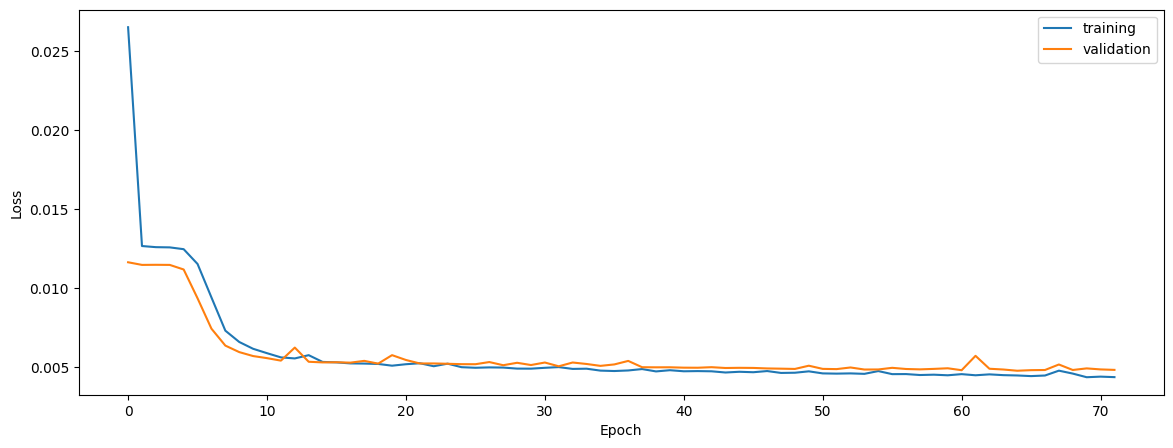

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8072854405296909
0.7636690395590308
0.8098713257947366


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.8072854405296909
0.7636690395590308
0.8098713257947366


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.8091942915625768
0.7772599437200003
0.7953730722238528


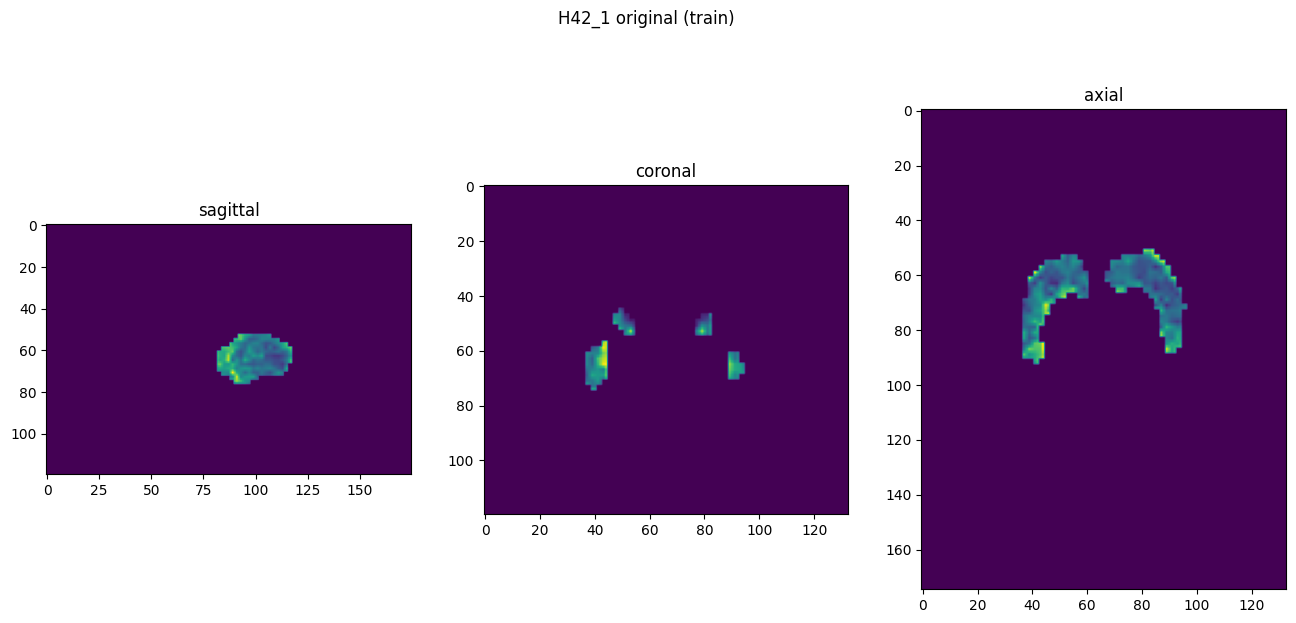

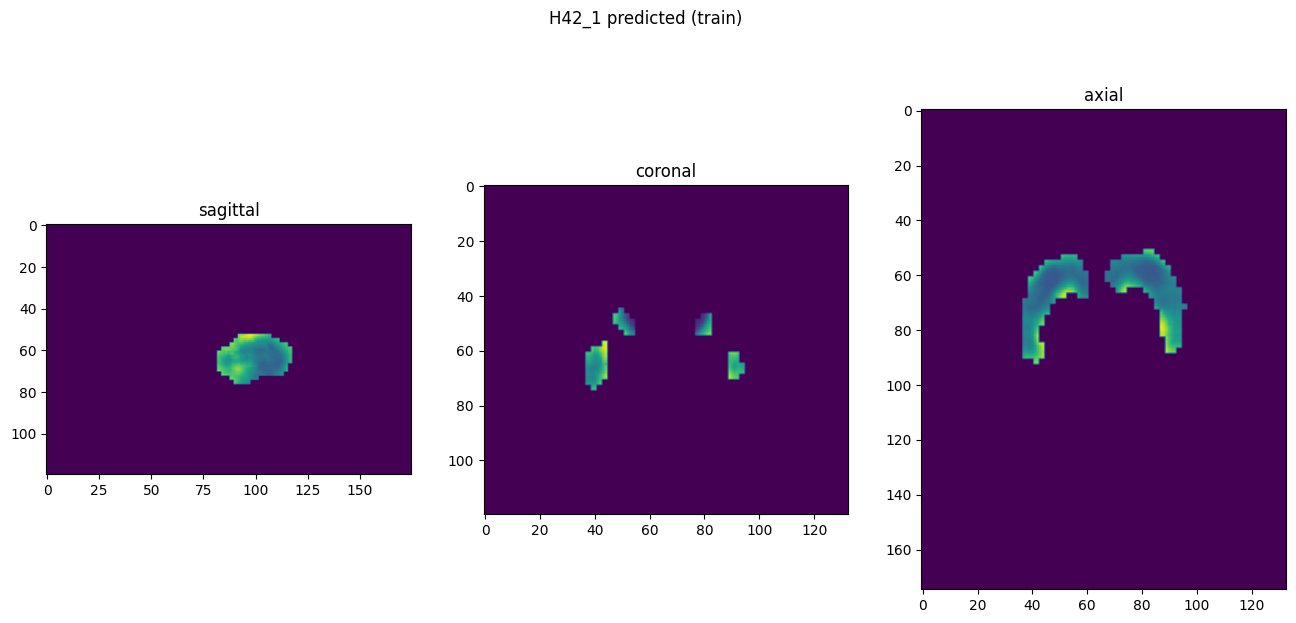

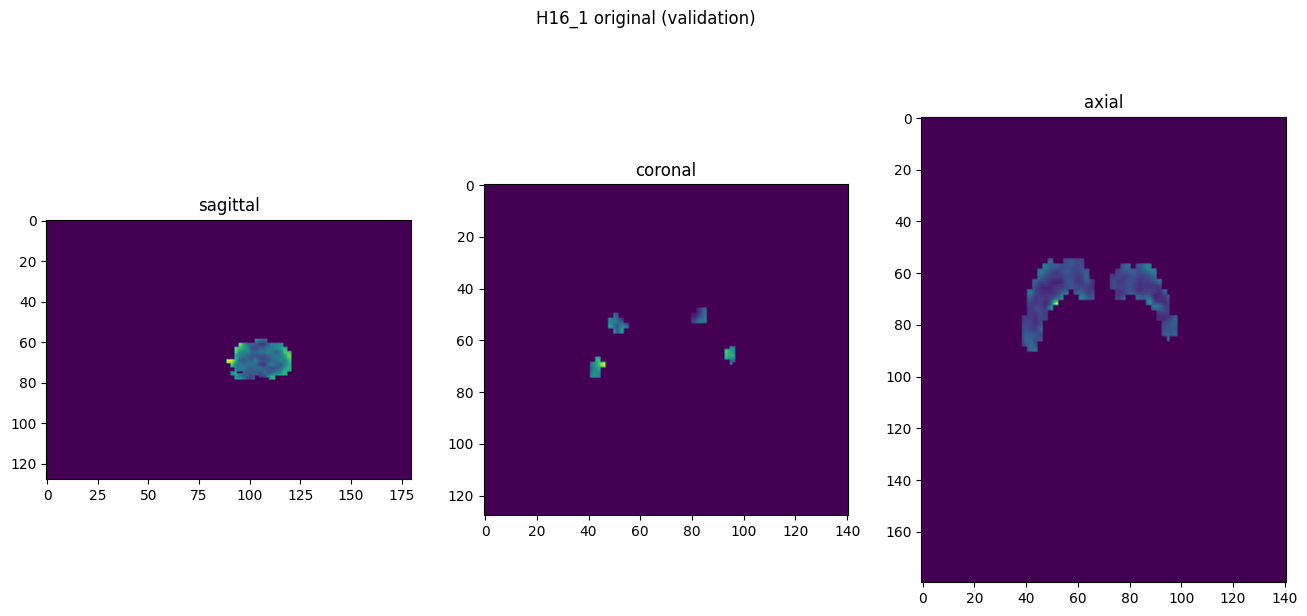

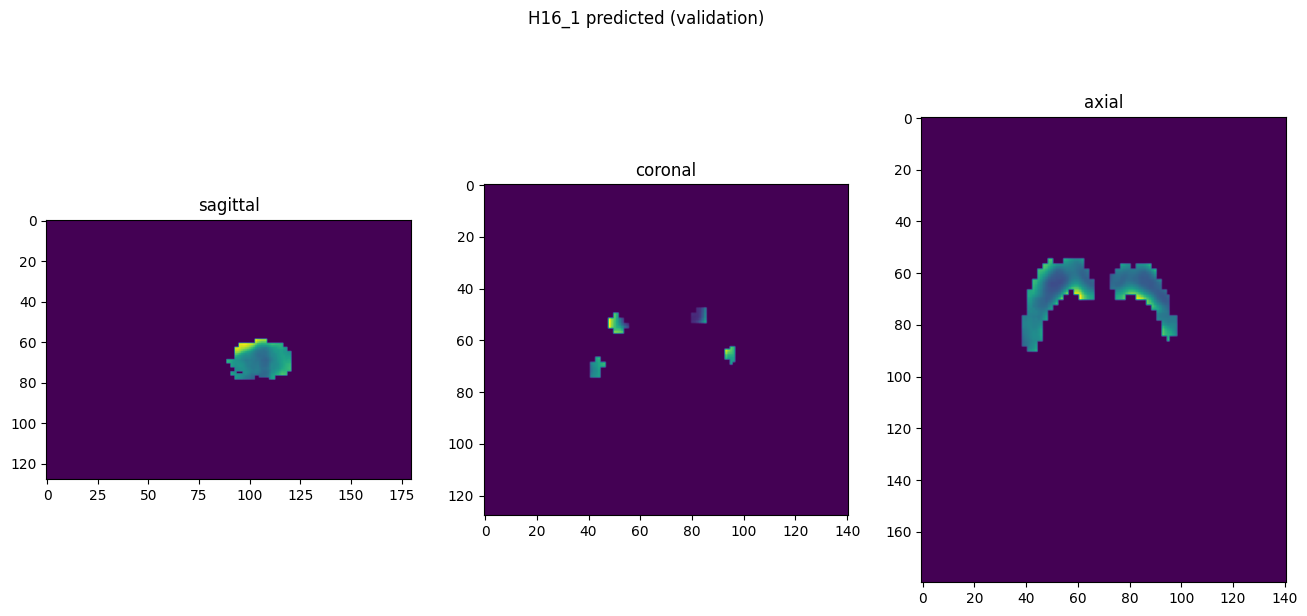

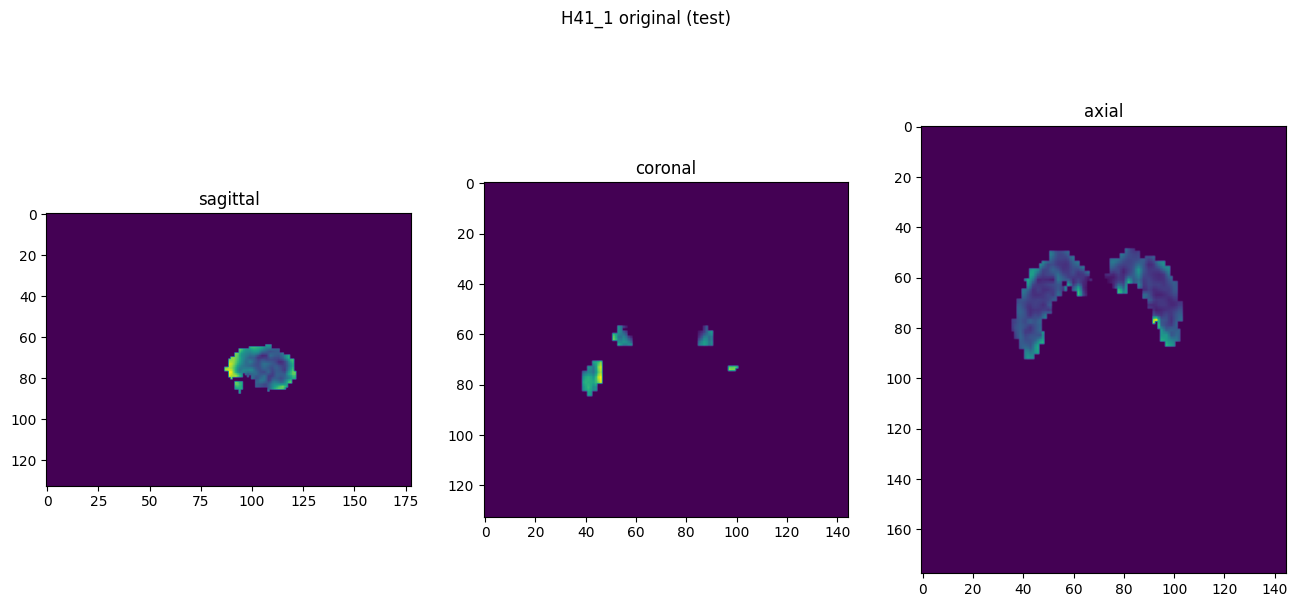

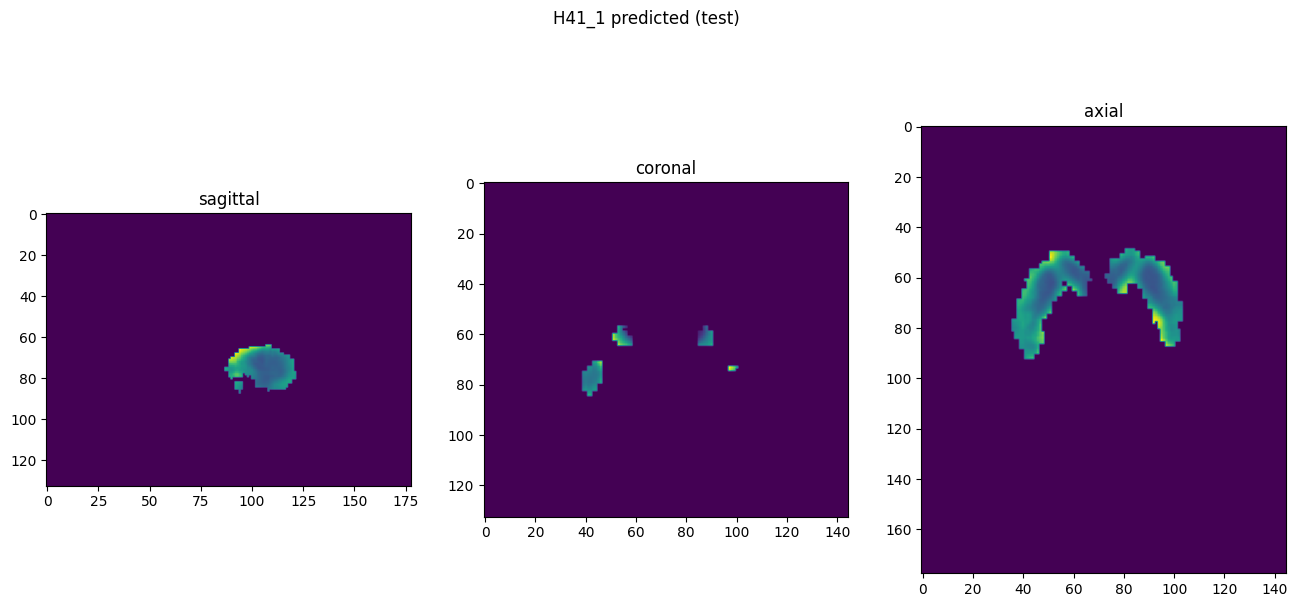

In [10]:
showResults(model, gen, threshold=None, background=False)